In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\dress\AppData\Local\Temp\ipykernel_15612\82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
from unidecode import unidecode

import requests                 # How Python gets the webpages
from bs4 import BeautifulSoup   # Creates structured, searchable object
import matplotlib.pyplot as plt
import json
from sklearn.impute import KNNImputer

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
!pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

## Introduction

The aim of this project is to find the best model to predict crop yield in New Zealand based on factors such as weather patterns, soil characteristics, and agricultural practices.

The project focuses on the yield of three crops: wheat, barley, and maize. Data is collected from the five recent years, spanning from 2019 to 2023, across all regions in New Zealand.

Following weather characteristics are considered for each month and for each region: total rainfall, number of wet days, mean air temperature in Celsius, total number of sunshine hours, and the mean wind speed.

The agricultural practice considered in the project is fertilizer application every year in each region.

Soil characteristics include the consideration of the following attributes: land use, soil types, values of available mineral nutrients in soil (AMN), bulk density (mass of soil per unit volume), total carbon content (TotalC), total nitrogen content (TotalN), and minimum/maximum target values.

In the first part of the project, data is collected from different sources and combined into one dataset for convenient reference in the following analysis.

Also, in the first part of the project, visualization techniques are applied to demonstrate the main patterns in the data.

The second part of the project demonstrates the application of different machine learning techniques to predict target variables such as wheat, barley, and maize grain yield. Regression, classification, and clustering models are applied.

## 1. Data preparation:

### Date.Crop yield

Coolect data for diffrent regions in NZ for 5 years. Information taked from the website:https://www.stats.govt.nz/publications?dateFiltersID=4&filters=Agricultural%20production%20statistics&start=12

The data is colleted in the middle of each year. So, the data related to 2022 relates to crop collected in th end 2022 from July 2022. So, apply following dates 1.01.2023 and 01.07.2023

In [ ]:
crop_2020_df = pd.read_excel("C:/Users/dress/Downloads/agricultural-production-statistics-june-2020-final.xlsx", sheet_name=8)
crop_2020_df.head(5)

C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 3'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 4'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


,Regions,Wheat Tonnes 2019,Wheat Tonnes 2020,Wheat Tonnes % change,Wheat Hectares \t\t 2019,Wheat Hectares \t\t 2020,Wheat Hectares % change,Barley Tonnes 2019,Barley Tonnes 2020,Barley Tonnes % change,Barley Hectares 2019,Barley Hectares 2020,Barley Hectares % change,Maize grain Tonnes 2019,Maize grain Tonnes 2020,Maize grain Tonnes % change,Maize grain Hectares \t\t 2019,Maize grain Hectares 2020,Maize grain Hectares % change
0,Northland,S,-,S,S,-,S,S,-,S,S,-,S,S,S,S,S,S,S
1,Auckland,S,-,S,S,-,S,600,1000,64.7,200,200,-6.9,3400,2400,-29.4,300,300,-6.7
2,Waikato,-,1400,100,-,100,100,2000,3000,53.2,400,500,33.2,37200,25500,-31.5,3300,2500,-24.1
3,Bay of Plenty,S,S,S,S,S,S,S,-,S,S,-,S,29200,33700,15.1,2600,2800,8.4
4,Gisborne,-,100,100,-,-,100,-,-,-,-,-,-,26900,33600,25,2700,2500,-6.9


In [ ]:
#generate the function to tune the multiple tables
def generate_table(data_set, new_data, year):
    # drop unnecessary columns
    data_set= data_set.drop(data_set.columns[[3,6,9,12,15,18]], axis=1)
    #get the data for first half of year:
    data_set_year= data_set.iloc[:, [0, 2, 4, 6, 8, 10, 12]].copy()
    #add column 'Year' and fill ****-07-01, date type:
    data_set_year['Date'] = pd.to_datetime(f'{year}-07-01', format='%Y-%m-%d')
    #and rename columns:
    data_set_year.columns.values[1] = 'Wheat Tonnes'
    data_set_year.columns.values[2] = 'Wheat Hectares'
    data_set_year.columns.values[3] = 'Barley Tonnes'
    data_set_year.columns.values[4] = 'Barley Hectares'
    data_set_year.columns.values[5] = 'Maize grain Tonnes'
    data_set_year.columns.values[6] = 'Maize grain Hectares'

    new_data=data_set_year

    return new_data

In [ ]:
#2020
crop_2020_df = pd.read_excel("C:/Users/dress/Downloads/agricultural-production-statistics-june-2020-final.xlsx", sheet_name=8)
crop_data_2020 = pd.DataFrame()  # Initialize an empty DataFrame
crop_data_2020 = generate_table(crop_2020_df, crop_data_2020, '2020')
crop_data_2020.head(5)

C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 3'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 4'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


,Regions,Wheat Tonnes,Wheat Hectares,Barley Tonnes,Barley Hectares,Maize grain Tonnes,Maize grain Hectares,Date
0,Northland,-,-,-,-,S,S,2020-07-01
1,Auckland,-,-,1000,200,2400,300,2020-07-01
2,Waikato,1400,100,3000,500,25500,2500,2020-07-01
3,Bay of Plenty,S,S,-,-,33700,2800,2020-07-01
4,Gisborne,100,-,-,-,33600,2500,2020-07-01


In [ ]:
#2023
crop_2023_df = pd.read_excel("C:/Users/dress/Downloads/agricultural-production-statistics-year-to-june-2023-final.xlsx", sheet_name=8)
crop_data_2023 = pd.DataFrame()  # Initialize an empty DataFrame
crop_data_2023 = generate_table(crop_2023_df, crop_data_2023, '2023')
crop_data_2023.head(5)

C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 3'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 4'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


,Regions,Wheat Tonnes,Wheat Hectares,Barley Tonnes,Barley Hectares,Maize grain Tonnes,Maize grain Hectares,Date
0,Northland,S,S,S,S,6200,S,2023-07-01
1,Auckland,S,S,S,S,5700,S,2023-07-01
2,Waikato,S,S,1800,300,41600,3700,2023-07-01
3,Bay of Plenty,S,S,S,S,23100,3000,2023-07-01
4,Gisborne,-,-,S,S,18200,1900,2023-07-01


In [ ]:
#2019
crop_2019_df = pd.read_excel("C:/Users/dress/Downloads/agricultural-production-statistics-june-2019-final.xlsx", sheet_name=8)
crop_data_2019 = pd.DataFrame()  # Initialize an empty DataFrame
crop_data_2019 = generate_table(crop_2019_df, crop_data_2019, '2019')
crop_data_2019.head(5)


C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 3'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 4'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


,Regions,Wheat Tonnes,Wheat Hectares,Barley Tonnes,Barley Hectares,Maize grain Tonnes,Maize grain Hectares,Date
0,Northland,S,S,S,S,S,S,2019-07-01
1,Auckland,S,S,600,200,3400,300,2019-07-01
2,Waikato,-,-,2000,400,37200,3300,2019-07-01
3,Bay of Plenty,S,S,S,S,29200,2600,2019-07-01
4,Gisborne,-,-,-,-,26900,2700,2019-07-01


In [ ]:
#2021
crop_2021_df = pd.read_excel("C:/Users/dress/Downloads/agricultural-production-statistics-june-2021-final.xlsx", sheet_name=8)
crop_data_2021 = pd.DataFrame()  # Initialize an empty DataFrame
crop_data_2021 = generate_table(crop_2021_df, crop_data_2021, '2021')
crop_data_2021.head(5)

C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 3'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 4'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


,Regions,Wheat Tonnes,Wheat Hectares,Barley Tonnes,Barley Hectares,Maize grain Tonnes,Maize grain Hectares,Date
0,Northland,S,S,S,S,S,S,2021-07-01
1,Auckland,S,S,2200,300,3800,300,2021-07-01
2,Waikato,S,S,3700,600,S,S,2021-07-01
3,Bay of Plenty,-,-,S,S,36100,3100,2021-07-01
4,Gisborne,100,-,S,S,29000,2200,2021-07-01


In [ ]:
#2022
crop_2022_df = pd.read_excel("C:/Users/dress/Downloads/agricultural-production-statistics-year-to-June-2022-final-revised.xlsx", sheet_name=8)
crop_data_2022 = pd.DataFrame()  # Initialize an empty DataFrame
crop_data_2022 = generate_table(crop_2022_df, crop_data_2022, '2022')
crop_data_2022.head(20)

C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 3'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 4'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 5'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\dress\anaconda3\Lib\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'Table 6'!$A:$K.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


,Regions,Wheat Tonnes,Wheat Hectares,Barley Tonnes,Barley Hectares,Maize grain Tonnes,Maize grain Hectares,Date
0,Northland,S,S,S,300,6800,800,2022-07-01
1,Auckland,-,-,400,100,8900,1000,2022-07-01
2,Waikato,-,-,1000,200,36400,3100,2022-07-01
3,Bay of Plenty,-,-,-,-,21700,2100,2022-07-01
4,Gisborne,200,-,-,-,31000,2700,2022-07-01
5,Hawke's Bay,3600,500,11200,3600,33400,2500,2022-07-01
6,Taranaki,S,S,S,S,1500,100,2022-07-01
7,Manawatu-Wanganui,2600,400,12000,2300,38600,3300,2022-07-01
8,Wellington,1700,200,11600,1900,3700,300,2022-07-01
9,Total North Island,9000,1300,38200,8600,182000,15900,2022-07-01


In [ ]:
#combine all dataset together:
crop_df=pd.concat([crop_data_2019, crop_data_2020, crop_data_2021,crop_data_2022,crop_data_2023], ignore_index=True)
#add column 'Year'
crop_df['Year']=crop_df['Date'].dt.year
crop_df.rename(columns={'Regions': 'Region'}, inplace=True)

#drop column 'Date':

crop_df = crop_df.drop(columns='Date')
crop_df.head(8)

,Region,Wheat Tonnes,Wheat Hectares,Barley Tonnes,Barley Hectares,Maize grain Tonnes,Maize grain Hectares,Year
0,Northland,S,S,S,S,S,S,2019
1,Auckland,S,S,600,200,3400,300,2019
2,Waikato,-,-,2000,400,37200,3300,2019
3,Bay of Plenty,S,S,S,S,29200,2600,2019
4,Gisborne,-,-,-,-,26900,2700,2019
5,Hawke's Bay,4000,600,9000,1700,33000,2600,2019
6,Taranaki,S,S,800,100,S,S,2019
7,Manawatū-Whanganui,S,S,S,S,S,S,2019


Replace the zero values for regions where wheat,barley or maize grain are not cultivated.

In [ ]:
#all missed values are repplaced by zero:
crop_df.replace(['S', '-'], np.nan, inplace=True)
crop_df.fillna(0, inplace=True)
crop_df

C:\Users\dress\AppData\Local\Temp\ipykernel_15612\3313245794.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  crop_df.replace(['S', '-'], np.nan, inplace=True)


,Region,Wheat Tonnes,Wheat Hectares,Barley Tonnes,Barley Hectares,Maize grain Tonnes,Maize grain Hectares,Year
0,Northland,0.0,0.0,0.0,0.0,0.0,0.0,2019
1,Auckland,0.0,0.0,600.0,200.0,3400.0,300.0,2019
2,Waikato,0.0,0.0,2000.0,400.0,37200.0,3300.0,2019
3,Bay of Plenty,0.0,0.0,0.0,0.0,29200.0,2600.0,2019
4,Gisborne,0.0,0.0,0.0,0.0,26900.0,2700.0,2019
...,...,...,...,...,...,...,...,...
95,Otago,0.0,0.0,0.0,0.0,0.0,0.0,2023
96,Southland,40400.0,4500.0,0.0,0.0,0.0,0.0,2023
97,Chatham Islands,0.0,0.0,0.0,0.0,0.0,0.0,2023
98,Total South Island,379700.0,38800.0,311600.0,41700.0,0.0,0.0,2023


Analize the data for yield crop. Compare the total yield of wheat, barley, and maize for New Zealand as a whole across different years.

Visualize how the total crop yield changes over 5 years.

Text(0, 0.5, 'Maize grain Tonnes')

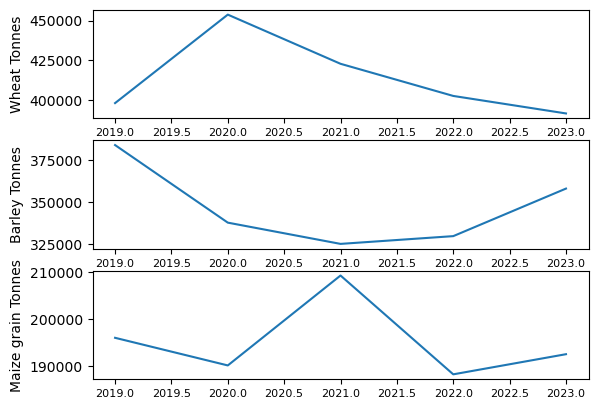

In [ ]:
plt.subplot(3, 1, 1)

total_NZ_data = crop_df[crop_df['Region'] == 'Total New Zealand']

plt.plot(total_NZ_data['Year'], total_NZ_data['Wheat Tonnes'])
plt.xticks(fontsize=8)
plt.ylabel('Wheat Tonnes')

plt.subplot(3, 1, 2)
plt.plot(total_NZ_data['Year'], total_NZ_data['Barley Tonnes'])
plt.xticks(fontsize=8)
plt.ylabel('Barley Tonnes')

plt.subplot(3, 1, 3)
plt.plot(total_NZ_data['Year'], total_NZ_data['Maize grain Tonnes'])
plt.xticks(fontsize=8)
plt.ylabel('Maize grain Tonnes')

According to the plot of total crop yield in New Zealand, which combines data from both the North and South Islands, the wheat yield significantly decreases after 2020. The barley yield was declining until 2021, after which it started to show a slow increase. The maize yield peaked in 2021, and its trend was not consistently smooth throughout the considered period.

Generate a plot to show how the crop yield changes over 5 years for the South Island and North Island of New Zealand.

In [ ]:
crop_yield_total = crop_df[crop_df['Region'].isin(['Total South Island', 'Total North Island'])]
crop_yield_total

,Region,Wheat Tonnes,Wheat Hectares,Barley Tonnes,Barley Hectares,Maize grain Tonnes,Maize grain Hectares,Year
9,Total North Island,0.0,0.0,0.0,0.0,182600.0,15600.0,2019
18,Total South Island,381800.0,42700.0,338400.0,48300.0,0.0,0.0,2019
29,Total North Island,0.0,0.0,51000.0,7200.0,184300.0,15700.0,2020
38,Total South Island,441100.0,44100.0,286700.0,37900.0,5800.0,400.0,2020
49,Total North Island,0.0,0.0,54900.0,8300.0,205300.0,17100.0,2021
58,Total South Island,405000.0,41500.0,270100.0,35900.0,0.0,0.0,2021
69,Total North Island,9000.0,1300.0,38200.0,8600.0,182000.0,15900.0,2022
78,Total South Island,393600.0,41600.0,291600.0,39600.0,6300.0,500.0,2022
89,Total North Island,11900.0,1700.0,0.0,0.0,179700.0,17900.0,2023
98,Total South Island,379700.0,38800.0,311600.0,41700.0,0.0,0.0,2023


Text(57.12050925925928, 0.5, 'Maize grain yield total')

<Figure size 1000x600 with 0 Axes>

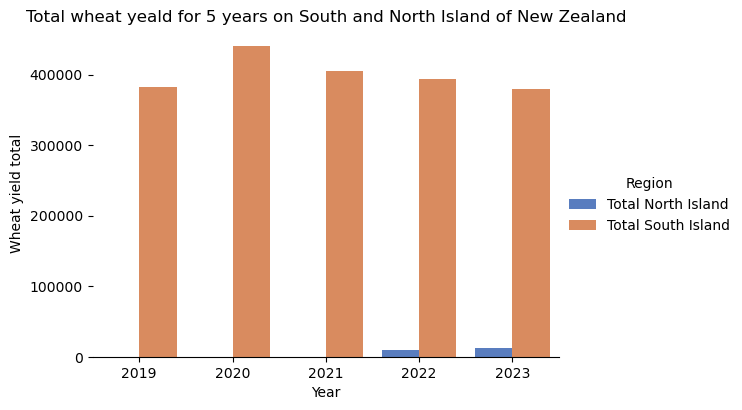

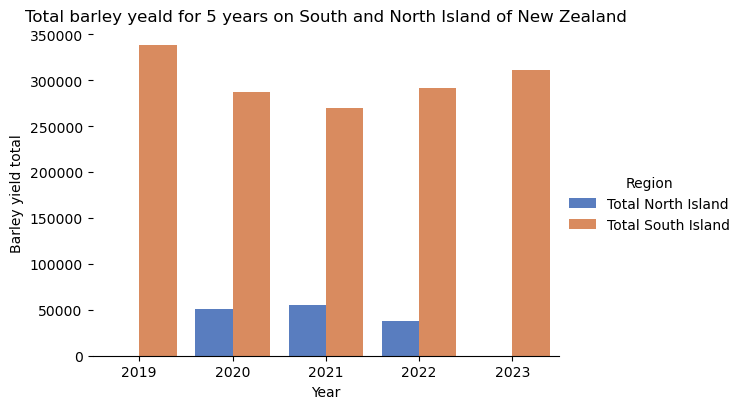

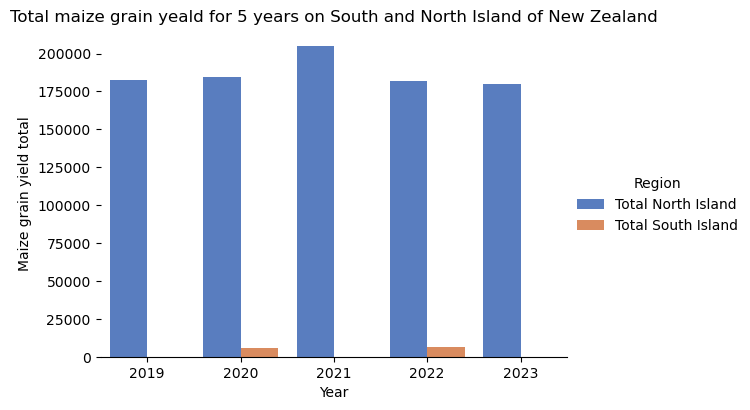

In [ ]:
plt.figure(figsize=(10, 6))

#wheat
plot_yield_wheat = sns.catplot(x="Year", y="Wheat Tonnes", hue="Region", data=crop_yield_total ,
                 height=4,aspect=1.5, kind="bar", palette="muted")

plot_yield_wheat.despine(left=True)
plt.title('Total wheat yeald for 5 years on South and North Island of New Zealand')
plt.ylabel("Wheat yield total")

#barley
plot_yield_barley = sns.catplot(x="Year", y="Barley Tonnes", hue="Region", data=crop_yield_total ,
                 height=4,aspect=1.5, kind="bar", palette="muted")

plot_yield_barley.despine(left=True)
plt.title('Total barley yeald for 5 years on South and North Island of New Zealand')
plt.ylabel("Barley yield total")

#Maize grain

plot_yield_maize = sns.catplot(x="Year", y="Maize grain Tonnes", hue="Region", data=crop_yield_total ,
                 height=4,aspect=1.5, kind="bar", palette="muted")

plot_yield_maize.despine(left=True)
plt.title('Total maize grain yeald for 5 years on South and North Island of New Zealand')
plt.ylabel("Maize grain yield total")

According to the plots of total crop yield for the past 5 years, it can be concluded that the South Island mainly excels in barley and wheat yield crops, while the North Island focuses on maize crops. Interestingly, the highest wheat yield was recorded on the South Island of New Zealand in 2020, during the Covid pandemic. The highest barley yield was achieved in 2019 on the South Island, and the North Island showed the highest maize yield in 2021. In general, there are no significant rises or drops in crop yield during the considered 5 years.


Visualize which regions are focusing on the cultivation of specific crops.

In [ ]:
crop_yield_regions = crop_df[['Region','Wheat Tonnes', 'Barley Tonnes','Maize grain Tonnes','Year']]
crop_yield_regions = crop_yield_regions[~crop_yield_regions['Region'].isin(['Total South Island', 'Total North Island', 'Total New Zealand'])]
crop_yield_melted = pd.melt(crop_yield_regions, id_vars=['Region','Year'], var_name='Crop', value_name='Tonnes')
crop_yield_melted

,Region,Year,Crop,Tonnes
0,Northland,2019,Wheat Tonnes,0.0
1,Auckland,2019,Wheat Tonnes,0.0
2,Waikato,2019,Wheat Tonnes,0.0
3,Bay of Plenty,2019,Wheat Tonnes,0.0
4,Gisborne,2019,Wheat Tonnes,0.0
...,...,...,...,...
250,West Coast,2023,Maize grain Tonnes,0.0
251,Canterbury,2023,Maize grain Tonnes,0.0
252,Otago,2023,Maize grain Tonnes,0.0
253,Southland,2023,Maize grain Tonnes,0.0


<Figure size 1000x600 with 0 Axes>

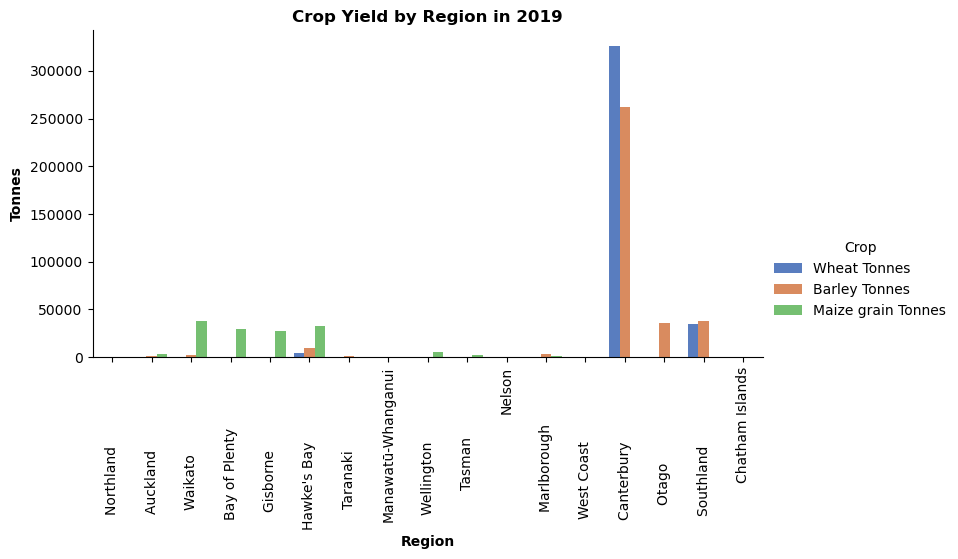

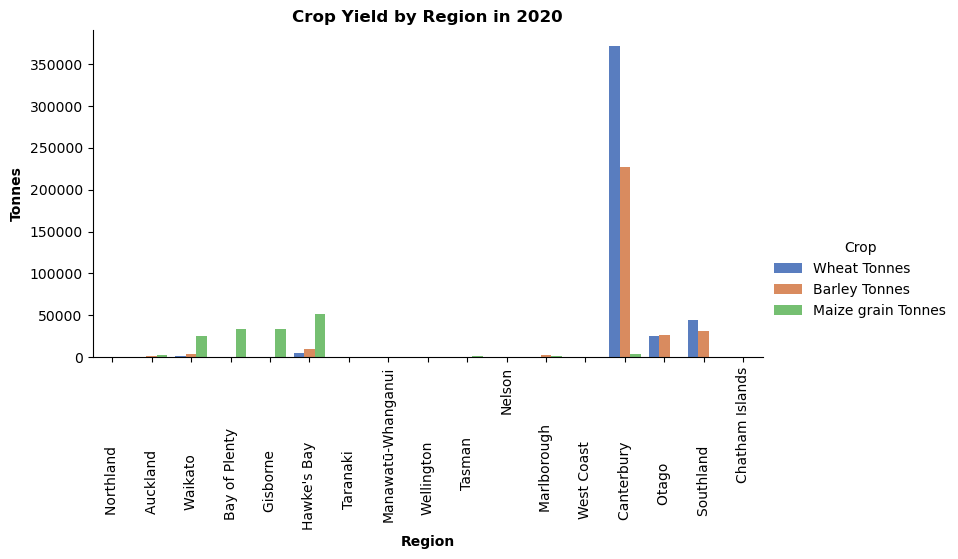

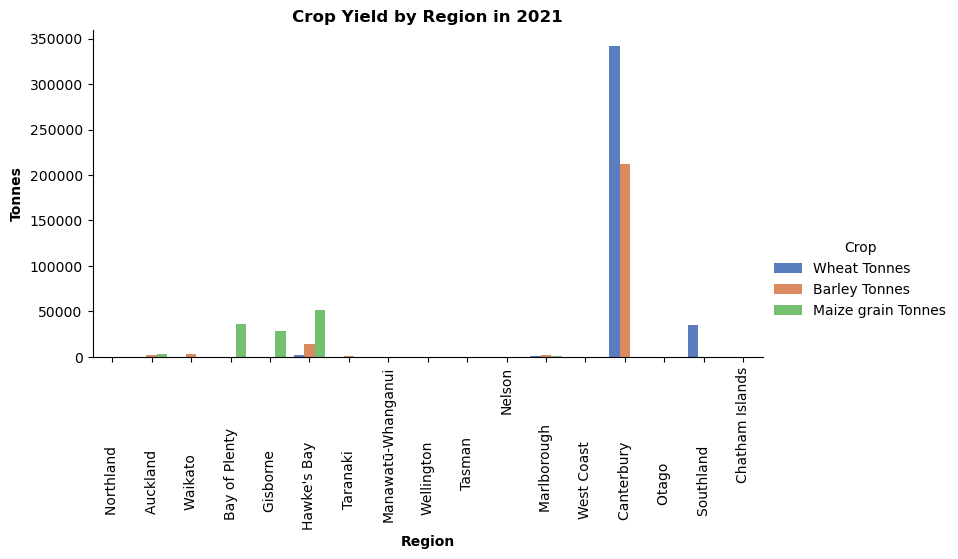

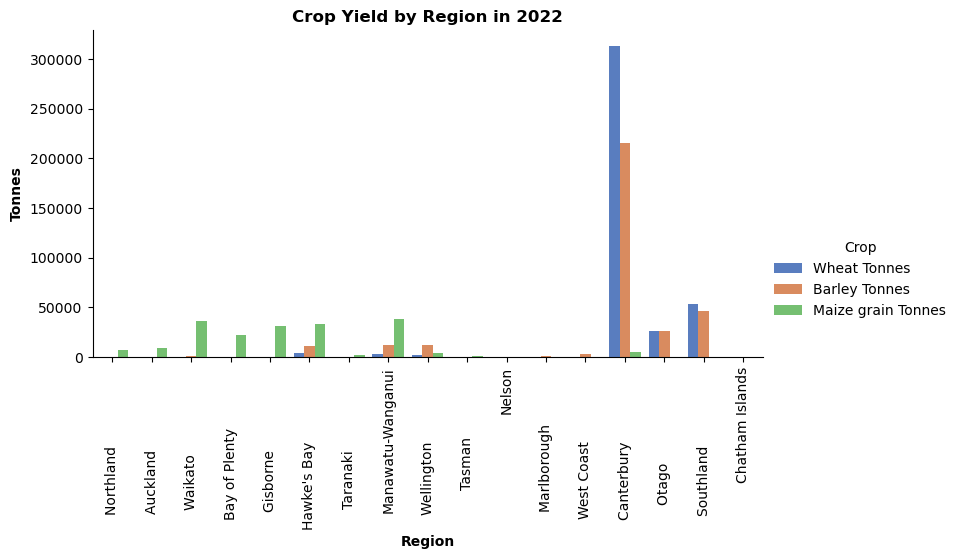

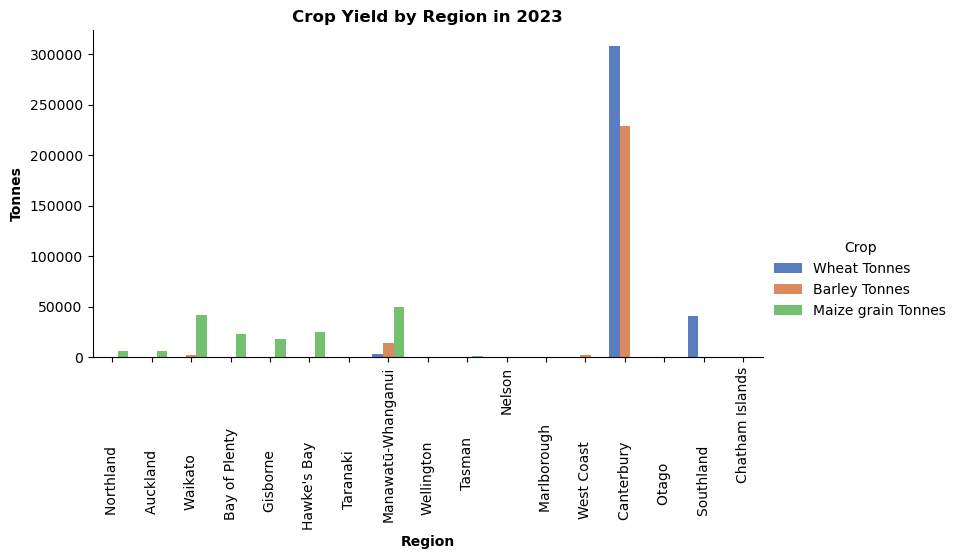

In [ ]:
plt.figure(figsize=(10, 6))

#2019
crop_yield_melted_2019 = crop_yield_melted[crop_yield_melted['Year'] == 2019]

sns.catplot(data=crop_yield_melted_2019, x='Region', y='Tonnes', hue='Crop', kind='bar', height=4, aspect=2, palette='muted')
plt.title('Crop Yield by Region in 2019', fontweight='bold')
plt.xlabel('Region', fontweight='bold')
plt.ylabel('Tonnes', fontweight='bold')
plt.xticks(rotation=90)
plt.show()

#2020

crop_yield_melted_2020 = crop_yield_melted[crop_yield_melted['Year'] == 2020]

sns.catplot(data=crop_yield_melted_2020, x='Region', y='Tonnes', hue='Crop', kind='bar', height=4, aspect=2, palette='muted')
plt.title('Crop Yield by Region in 2020', fontweight='bold')
plt.xlabel('Region', fontweight='bold')
plt.ylabel('Tonnes', fontweight='bold')
plt.xticks(rotation=90)
plt.show()

#2021

crop_yield_melted_2021 = crop_yield_melted[crop_yield_melted['Year'] == 2021]

sns.catplot(data=crop_yield_melted_2021, x='Region', y='Tonnes', hue='Crop', kind='bar', height=4, aspect=2, palette='muted')
plt.title('Crop Yield by Region in 2021', fontweight='bold')
plt.xlabel('Region', fontweight='bold')
plt.ylabel('Tonnes', fontweight='bold')
plt.xticks(rotation=90)
plt.show()

#2022

crop_yield_melted_2022 = crop_yield_melted[crop_yield_melted['Year'] == 2022]

sns.catplot(data=crop_yield_melted_2022, x='Region', y='Tonnes', hue='Crop', kind='bar', height=4, aspect=2, palette='muted')
plt.title('Crop Yield by Region in 2022', fontweight='bold')
plt.xlabel('Region', fontweight='bold')
plt.ylabel('Tonnes', fontweight='bold')
plt.xticks(rotation=90)
plt.show()

#2023

crop_yield_melted_2023 = crop_yield_melted[crop_yield_melted['Year'] == 2023]

sns.catplot(data=crop_yield_melted_2023, x='Region', y='Tonnes', hue='Crop', kind='bar', height=4, aspect=2, palette='muted')
plt.title('Crop Yield by Region in 2023', fontweight='bold')
plt.xlabel('Region', fontweight='bold')
plt.ylabel('Tonnes', fontweight='bold')
plt.xticks(rotation=90)
plt.show()

According to the five plots, the region of 'Canterbury' consistently demonstrates the highest yield of wheat and barley. Meanwhile, Hawke's Bay consistently exhibits high maize yields. The Auckland region shows no significant maize yield throughout all years, and in 2021, it also demonstrates no significant barley yield. Only Hawke's Bay, located on the North Island of New Zealand, regularly shows notable results for wheat, barley, and maize crops.

In [ ]:
#check all regions' names:
regions_names = crop_df['Region'].unique()
regions_names

array(['Northland                  ', 'Auckland                   ',
       'Waikato                    ', 'Bay of Plenty              ',
       'Gisborne                   ', "Hawke's Bay                 ",
       'Taranaki                   ', 'Manawatū-Whanganui',
       'Wellington                 ', 'Total North Island',
       'Tasman                ', 'Nelson', 'Marlborough             ',
       'West Coast                 ', 'Canterbury                 ',
       'Otago                      ', 'Southland                  ',
       'Chatham Islands', 'Total South Island', 'Total New Zealand',
       'Manawatu-Wanganui'], dtype=object)

In [ ]:
#there are two regions with diffrent spelling:Manawatū-Whanganui. Change to one name Manawatū-Whanganui:
crop_df['Region'] = crop_df['Region'].replace('Manawatu-Wanganui', 'Manawatū-Whanganui')

In [ ]:

regions_names = crop_df['Region'].unique()
regions_names

array(['Northland                  ', 'Auckland                   ',
       'Waikato                    ', 'Bay of Plenty              ',
       'Gisborne                   ', "Hawke's Bay                 ",
       'Taranaki                   ', 'Manawatū-Whanganui',
       'Wellington                 ', 'Total North Island',
       'Tasman                ', 'Nelson', 'Marlborough             ',
       'West Coast                 ', 'Canterbury                 ',
       'Otago                      ', 'Southland                  ',
       'Chatham Islands', 'Total South Island', 'Total New Zealand'],
      dtype=object)

## Data Weather

In [ ]:
northland_df = pd.read_excel("Weather Data from NIWA.xlsx", sheet_name="northland", skiprows = 26, header=0, usecols="A:D")
northland_df["Station"] = "Northland"
northland_df.head()
# northland_df.info()

,Station,Mon-YYYY(local),Stat Code,Stat Value
0,Northland,2017-01-01,0,20.2
1,Northland,2017-01-01,1,2.0
2,Northland,2017-01-01,2,20.2
3,Northland,2017-01-01,16,15.3
4,Northland,2017-01-01,33,3.4


In [ ]:
#auckland
auckland_df = pd.read_excel("Weather Data from NIWA.xlsx", sheet_name="auckland", skiprows = 26, header=0, usecols="A:D")
auckland_df["Station"] = "Auckland"
auckland_df.head()
# auckland_df.info()

,Station,Mon-YYYY(local),Stat Code,Stat Value
0,Auckland,2018-09-01,33,3.4
1,Auckland,2018-10-01,0,73.4
2,Auckland,2018-10-01,1,8.0
3,Auckland,2018-10-01,2,14.1
4,Auckland,2018-10-01,9,246.5


In [ ]:
#waikato
waikato_df = pd.read_excel("Weather Data from NIWA.xlsx", sheet_name="waikato", skiprows = 26, header=0, usecols="A:D")
waikato_df["Station"] = "Waikato"
waikato_df.head()
# waikato_df.info()

,Station,Mon-YYYY(local),Stat Code,Stat Value
0,Waikato,2017-01-01,0,60.0
1,Waikato,2017-01-01,1,9.0
2,Waikato,2017-01-01,2,17.0
3,Waikato,2017-01-01,11,18.8
4,Waikato,2017-01-01,16,16.0


In [ ]:
#bayofplenty
bayofplenty_df = pd.read_excel("Weather Data from NIWA.xlsx", sheet_name="bay_of_plenty", skiprows = 26, header=0, usecols="A:D")
bayofplenty_df["Station"] = "Bay of Plenty"
bayofplenty_df.head()
# bayofplenty_df.info()

,Station,Mon-YYYY(local),Stat Code,Stat Value
0,Bay of Plenty,2017-01-01,0,35.4
1,Bay of Plenty,2017-01-01,1,4.0
2,Bay of Plenty,2017-01-01,2,18.7
3,Bay of Plenty,2017-01-01,16,15.3
4,Bay of Plenty,2017-01-01,33,4.3


In [ ]:
#hawkesbay
hawkesbay_df = pd.read_excel("Weather Data from NIWA.xlsx", sheet_name="hawkes_bay", skiprows = 26, header=0, usecols="A:D")
hawkesbay_df["Station"] = "Hawke's Bay"
hawkesbay_df.head()
# hawkesbay_df.info()

,Station,Mon-YYYY(local),Stat Code,Stat Value
0,Hawke's Bay,2017-01-01,0,3.6
1,Hawke's Bay,2017-01-01,1,1.0
2,Hawke's Bay,2017-01-01,2,20.5
3,Hawke's Bay,2017-01-01,16,13.6
4,Hawke's Bay,2017-01-01,64,57.0


In [ ]:
#taranaki
taranaki_df = pd.read_excel("Weather Data from NIWA.xlsx", sheet_name="taranaki", skiprows = 26, header=0, usecols="A:D")
taranaki_df["Station"] = "Taranaki"
taranaki_df.head()
# taranaki_df.info()

,Station,Mon-YYYY(local),Stat Code,Stat Value
0,Taranaki,2017-01-01,0,115.8
1,Taranaki,2017-01-01,1,11.0
2,Taranaki,2017-01-01,2,14.9
3,Taranaki,2017-01-01,9,226.9
4,Taranaki,2017-01-01,11,15.8


In [ ]:
#manawatu-whanganui
manawatu_whanganui_df = pd.read_excel("Weather Data from NIWA.xlsx", sheet_name="manawatu-whanganui", skiprows = 26, header=0, usecols="A:D")
manawatu_whanganui_df["Station"] = "Manawatū-Whanganui"
manawatu_whanganui_df.head()
# manawatu_whanganui_df.info()

,Station,Mon-YYYY(local),Stat Code,Stat Value
0,Manawatū-Whanganui,2017-01-01,0,85.6
1,Manawatū-Whanganui,2017-01-01,1,10.0
2,Manawatū-Whanganui,2017-01-01,2,16.8
3,Manawatū-Whanganui,2017-01-01,9,215.2
4,Manawatū-Whanganui,2017-01-01,11,16.6


In [ ]:
#wellington
wellington_df = pd.read_excel("Weather Data from NIWA.xlsx", sheet_name="wellington", skiprows = 26, header=0, usecols="A:D")
wellington_df["Station"] = "Wellington"
wellington_df.head()
# wellington_df.info()

,Station,Mon-YYYY(local),Stat Code,Stat Value
0,Wellington,2017-01-01,0,41.8
1,Wellington,2017-01-01,1,7.0
2,Wellington,2017-01-01,2,17.0
3,Wellington,2017-01-01,9,215.3
4,Wellington,2017-01-01,11,17.2


In [ ]:
#tasman
tasman_df = pd.read_excel("Weather Data from NIWA.xlsx", sheet_name="tasman", skiprows = 26, header=0, usecols="A:D")
tasman_df["Station"] = "Tasman"
tasman_df.head()
# tasman_df.info()

,Station,Mon-YYYY(local),Stat Code,Stat Value
0,Tasman,2017-01-01,0,160.0
1,Tasman,2017-01-01,1,7.0
2,Tasman,2017-01-01,2,17.6
3,Tasman,2017-01-01,11,19.2
4,Tasman,2017-01-01,12,21.3


In [ ]:
#marlborough
marlborough_df = pd.read_excel("Weather Data from NIWA.xlsx", sheet_name="marlborough", skiprows = 26, header=0, usecols="A:D")
marlborough_df["Station"] = "Marlborough"
marlborough_df.head()
# marlborough_df.info()

,Station,Mon-YYYY(local),Stat Code,Stat Value
0,Marlborough,2017-01-01,0,27.2
1,Marlborough,2017-01-01,1,5.0
2,Marlborough,2017-01-01,2,18.6
3,Marlborough,2017-01-01,9,283.9
4,Marlborough,2017-01-01,11,18.9


In [ ]:
#canterbury
canterbury_df = pd.read_excel("Weather Data from NIWA.xlsx", sheet_name="canterbury", skiprows = 26, header=0, usecols="A:D")
canterbury_df["Station"] = "Canterbury"
canterbury_df.head()
# canterbury_df.info()

,Station,Mon-YYYY(local),Stat Code,Stat Value
0,Canterbury,2017-01-01,0,46.8
1,Canterbury,2017-01-01,1,8.0
2,Canterbury,2017-01-01,2,15.8
3,Canterbury,2017-01-01,11,15.6
4,Canterbury,2017-01-01,33,4.0


In [ ]:
#southland
southland_df = pd.read_excel("Weather Data from NIWA.xlsx", sheet_name="southland", skiprows = 26, header=0, usecols="A:D")
southland_df["Station"] = "Southland"
southland_df.head()
# southland_df.info()

,Station,Mon-YYYY(local),Stat Code,Stat Value
0,Southland,2019-05-01,0,37.0
1,Southland,2019-05-01,1,6.0
2,Southland,2019-05-01,2,8.2
3,Southland,2019-05-01,9,123.7
4,Southland,2019-05-01,11,5.5


In [ ]:
weather_df = pd.concat([northland_df, auckland_df, waikato_df, bayofplenty_df, hawkesbay_df, taranaki_df, manawatu_whanganui_df, wellington_df, tasman_df, marlborough_df,canterbury_df,southland_df], ignore_index=True)
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8957 entries, 0 to 8956
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Station          8957 non-null   object        
 1   Mon-YYYY(local)  8957 non-null   datetime64[ns]
 2   Stat Code        8957 non-null   int64         
 3   Stat Value       8957 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 280.0+ KB


In [ ]:
pivot_df = weather_df.pivot(index=['Station', 'Mon-YYYY(local)'], columns='Stat Code', values='Stat Value')
pivot_df = pivot_df.reset_index()
pivot_df.columns.name = None
pivot_df

,Station,Mon-YYYY(local),0,1,2,9,11,12,14,16,33,47,64,69
0,Auckland,2018-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.4,NaN,NaN,NaN
1,Auckland,2018-10-01,73.4,8.0,14.1,246.5,14.4,15.2,15.1,12.8,2.9,15.9,78.1,NaN
2,Auckland,2018-11-01,89.0,11.0,16.2,223.7,17.3,17.6,17.0,14.3,3.3,18.2,76.0,NaN
3,Auckland,2018-12-01,224.4,14.0,18.9,219.1,19.7,19.9,18.6,16.5,3.3,20.1,75.2,NaN
4,Auckland,2019-01-01,36.4,3.0,21.2,287.9,21.9,22.4,20.5,18.4,3.5,22.4,75.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,Wellington,2023-12-01,30.4,5.0,18.0,141.5,17.3,17.4,15.5,14.5,4.4,17.1,69.1,14.5
1003,Wellington,2024-01-01,33.4,3.0,19.6,222.9,19.6,20.3,17.9,15.4,3.9,20.1,68.6,10.0
1004,Wellington,2024-02-01,22.4,7.0,18.0,217.9,17.9,19.2,18.4,13.8,4.3,19.9,71.1,9.3
1005,Wellington,2024-03-01,26.4,5.0,15.1,187.5,14.3,15.8,17.3,11.9,3.9,17.5,77.6,8.7


In [ ]:
new_column_names = {
    'Station': 'Region',
    'Mon-YYYY(local)': 'Date',
    0: 'Total Rainfall (mm)',
    1: 'Wet Day - 1mm or more of Rain (day)',
    2: 'Mean Air Temperature (Celsius)',
    9: 'Total Sunshine (hrs)',
    11: '10cm Mean Earth Temp (Celsius)',
    12: '20cm Mean Earth Temp (Celsius)',
    14: '100cm Mean Earth Temp (Celsius)',
    16: 'Mean Vapour Pressure (Hpa)',
    33: 'Mean Wind Speed (M/Sec)',
    47: 'Mean 50cm Earth Temp (Celsius)',
    64: 'Mean of 9am Relative Humidity (%)',
    69: 'Mean Soil Moisture (%)'
}

pivot_df.rename(columns=new_column_names, inplace=True)
weather_df = pivot_df
weather_df

,Region,Date,Total Rainfall (mm),Wet Day - 1mm or more of Rain (day),Mean Air Temperature (Celsius),Total Sunshine (hrs),10cm Mean Earth Temp (Celsius),20cm Mean Earth Temp (Celsius),100cm Mean Earth Temp (Celsius),Mean Vapour Pressure (Hpa),Mean Wind Speed (M/Sec),Mean 50cm Earth Temp (Celsius),Mean of 9am Relative Humidity (%),Mean Soil Moisture (%)
0,Auckland,2018-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.4,NaN,NaN,NaN
1,Auckland,2018-10-01,73.4,8.0,14.1,246.5,14.4,15.2,15.1,12.8,2.9,15.9,78.1,NaN
2,Auckland,2018-11-01,89.0,11.0,16.2,223.7,17.3,17.6,17.0,14.3,3.3,18.2,76.0,NaN
3,Auckland,2018-12-01,224.4,14.0,18.9,219.1,19.7,19.9,18.6,16.5,3.3,20.1,75.2,NaN
4,Auckland,2019-01-01,36.4,3.0,21.2,287.9,21.9,22.4,20.5,18.4,3.5,22.4,75.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,Wellington,2023-12-01,30.4,5.0,18.0,141.5,17.3,17.4,15.5,14.5,4.4,17.1,69.1,14.5
1003,Wellington,2024-01-01,33.4,3.0,19.6,222.9,19.6,20.3,17.9,15.4,3.9,20.1,68.6,10.0
1004,Wellington,2024-02-01,22.4,7.0,18.0,217.9,17.9,19.2,18.4,13.8,4.3,19.9,71.1,9.3
1005,Wellington,2024-03-01,26.4,5.0,15.1,187.5,14.3,15.8,17.3,11.9,3.9,17.5,77.6,8.7


Text(0.5, 1.0, 'A Positive, Linear Relationship between Total Sunshine Hours and Mean Earth Temp at 10cm\n')

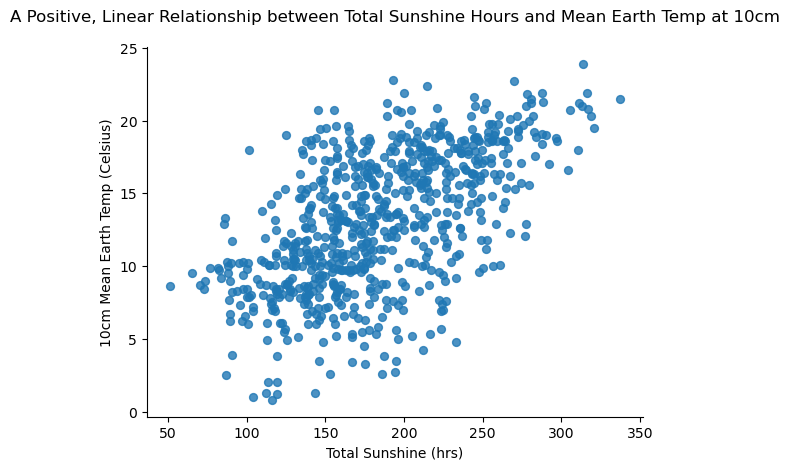

In [ ]:
from matplotlib import pyplot as plt
weather_df.plot(kind='scatter', x='Total Sunshine (hrs)', y='10cm Mean Earth Temp (Celsius)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title("A Positive, Linear Relationship between Total Sunshine Hours and Mean Earth Temp at 10cm\n")

The plot above visually shows us that there is a positive correlation between total sunshine hours and mean Earth Temp for all the data across NZ. It doesn't look to be a very strong relationship as the data points are rather scattered.


<Figure size 1200x600 with 0 Axes>

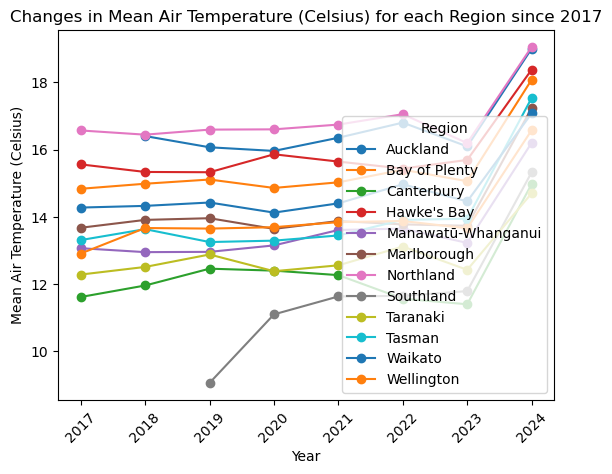

In [ ]:
weather_since_2017 = weather_df[weather_df['Date'] >= '2017-01-01']

grouped_data = weather_since_2017.groupby([weather_since_2017['Date'].dt.year, 'Region'])['Mean Air Temperature (Celsius)'].mean().unstack()

plt.figure(figsize=(12, 6))
grouped_data.plot(kind='line', marker='o')
plt.xlabel('Year')
plt.ylabel('Mean Air Temperature (Celsius)')
plt.title('Changes in Mean Air Temperature (Celsius) for each Region since 2017')
plt.xticks(rotation=45)
plt.show()

The graph above shows the how the yearly mean air temperature changes per region over the last 7 years. Generally, the mean yearly temperatures are lower the further down the country the region is, but there are a few regions that are consistently warmer than other more northern regions. Canterbury is overall the coldest region, and Northland is the warmest. The lines appear to escalate quickly for 2024 but that would be due to only data for summer and early autumn being recorded so far.

C:\Users\dress\AppData\Local\Temp\ipykernel_15612\892515643.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_rainfall = canterbury_df.resample('M', on='Date')['Total Rainfall (mm)'].mean()


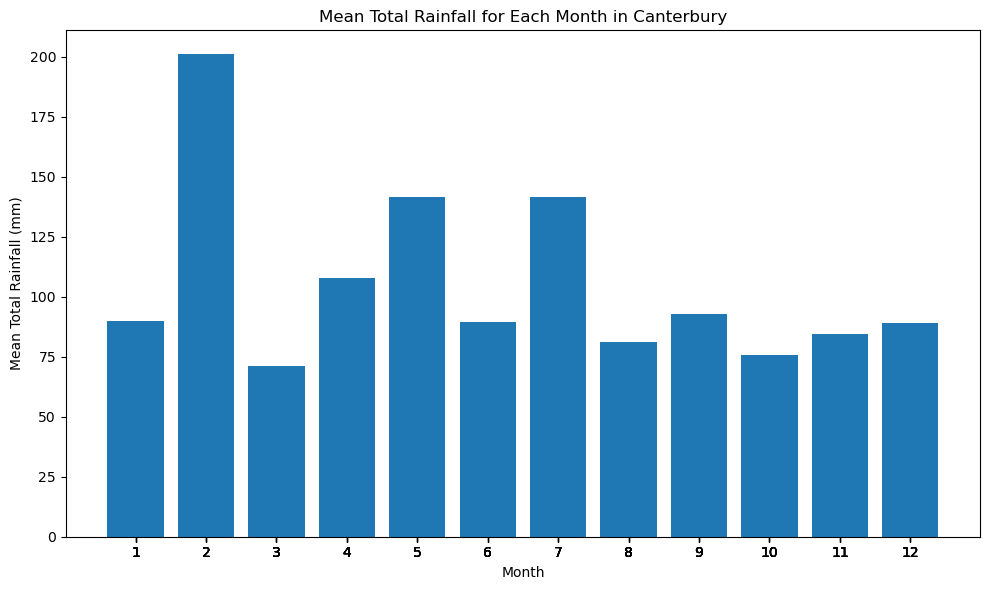

In [ ]:
import matplotlib.dates as mdates

canterbury_df = weather_df[weather_df['Region'] == 'Canterbury']
monthly_rainfall = canterbury_df.resample('M', on='Date')['Total Rainfall (mm)'].mean()
monthly_rainfall_df = pd.DataFrame({'Date': monthly_rainfall.index, 'Mean Rainfall (mm)': monthly_rainfall})

monthly_rainfall_df['Month'] = monthly_rainfall_df['Date'].dt.month

plt.figure(figsize=(10, 6))
plt.bar(monthly_rainfall_df['Month'], monthly_rainfall_df['Mean Rainfall (mm)'])
plt.xlabel('Month')
plt.ylabel('Mean Total Rainfall (mm)')
plt.title('Mean Total Rainfall for Each Month in Canterbury')
plt.xticks(monthly_rainfall_df['Month'])
plt.tight_layout()
plt.show()

The graph finds the wettest months of the year for one of the regions in NZ, Canterbury. We would expect winter to have the top wettest months, but we see that it is actually February with a mean total rainfall of about 200mm. The driest month is March with a mean total rainfall of about 70mm.

Update the weather dataset to show each variable categorized by month.

In [ ]:
region_names = weather_df['Region'].unique()
region_names

array(['Auckland', 'Bay of Plenty', 'Canterbury', "Hawke's Bay",
       'Manawatū-Whanganui', 'Marlborough', 'Northland', 'Southland',
       'Taranaki', 'Tasman', 'Waikato', 'Wellington'], dtype=object)

In [ ]:
waikato_weather_df = weather_df[weather_df['Region'] == 'Waikato']
waikato_weather_df

,Region,Date,Total Rainfall (mm),Wet Day - 1mm or more of Rain (day),Mean Air Temperature (Celsius),Total Sunshine (hrs),10cm Mean Earth Temp (Celsius),20cm Mean Earth Temp (Celsius),100cm Mean Earth Temp (Celsius),Mean Vapour Pressure (Hpa),Mean Wind Speed (M/Sec),Mean 50cm Earth Temp (Celsius),Mean of 9am Relative Humidity (%),Mean Soil Moisture (%)
831,Waikato,2017-01-01,60.0,9.0,17.0,208.5,18.8,NaN,NaN,16.0,4.1,NaN,84.1,NaN
832,Waikato,2017-02-01,139.4,10.0,19.2,155.3,20.7,NaN,NaN,18.1,2.9,NaN,90.8,NaN
833,Waikato,2017-03-01,216.2,11.0,18.2,164.2,19.6,NaN,NaN,17.5,3.0,NaN,93.6,NaN
834,Waikato,2017-04-01,NaN,NaN,15.5,176.9,16.1,NaN,NaN,15.9,2.5,NaN,94.3,NaN
835,Waikato,2017-05-01,124.2,12.0,11.1,NaN,12.1,NaN,NaN,11.9,2.8,NaN,93.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,Waikato,2023-12-01,89.8,10.0,18.5,154.7,18.6,NaN,NaN,17.5,3.3,NaN,82.5,NaN
915,Waikato,2024-01-01,67.0,6.0,20.1,NaN,20.9,NaN,NaN,18.7,2.9,NaN,82.0,NaN
916,Waikato,2024-02-01,71.8,9.0,18.5,253.0,19.2,NaN,NaN,17.2,2.8,NaN,89.0,NaN
917,Waikato,2024-03-01,155.0,12.0,15.3,207.3,15.8,NaN,NaN,14.8,2.9,NaN,93.5,NaN


In [ ]:
weather_df['Year']=weather_df['Date'].dt.year
weather_df['Month'] = weather_df['Date'].dt.strftime('%B')
weather_df.head(5)

,Region,Date,Total Rainfall (mm),Wet Day - 1mm or more of Rain (day),Mean Air Temperature (Celsius),Total Sunshine (hrs),10cm Mean Earth Temp (Celsius),20cm Mean Earth Temp (Celsius),100cm Mean Earth Temp (Celsius),Mean Vapour Pressure (Hpa),Mean Wind Speed (M/Sec),Mean 50cm Earth Temp (Celsius),Mean of 9am Relative Humidity (%),Mean Soil Moisture (%),Year,Month
0,Auckland,2018-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.4,NaN,NaN,NaN,2018,September
1,Auckland,2018-10-01,73.4,8.0,14.1,246.5,14.4,15.2,15.1,12.8,2.9,15.9,78.1,NaN,2018,October
2,Auckland,2018-11-01,89.0,11.0,16.2,223.7,17.3,17.6,17.0,14.3,3.3,18.2,76.0,NaN,2018,November
3,Auckland,2018-12-01,224.4,14.0,18.9,219.1,19.7,19.9,18.6,16.5,3.3,20.1,75.2,NaN,2018,December
4,Auckland,2019-01-01,36.4,3.0,21.2,287.9,21.9,22.4,20.5,18.4,3.5,22.4,75.4,NaN,2019,January


In [ ]:
weather_df = weather_df.drop(columns=[
    '10cm Mean Earth Temp (Celsius)',
    '20cm Mean Earth Temp (Celsius)',
    '100cm Mean Earth Temp (Celsius)',
    'Mean Vapour Pressure (Hpa)',
    'Mean 50cm Earth Temp (Celsius)',
    'Mean of 9am Relative Humidity (%)',
    'Mean Soil Moisture (%)'])
weather_df

,Region,Date,Total Rainfall (mm),Wet Day - 1mm or more of Rain (day),Mean Air Temperature (Celsius),Total Sunshine (hrs),Mean Wind Speed (M/Sec),Year,Month
0,Auckland,2018-09-01,NaN,NaN,NaN,NaN,3.4,2018,September
1,Auckland,2018-10-01,73.4,8.0,14.1,246.5,2.9,2018,October
2,Auckland,2018-11-01,89.0,11.0,16.2,223.7,3.3,2018,November
3,Auckland,2018-12-01,224.4,14.0,18.9,219.1,3.3,2018,December
4,Auckland,2019-01-01,36.4,3.0,21.2,287.9,3.5,2019,January
...,...,...,...,...,...,...,...,...,...
1002,Wellington,2023-12-01,30.4,5.0,18.0,141.5,4.4,2023,December
1003,Wellington,2024-01-01,33.4,3.0,19.6,222.9,3.9,2024,January
1004,Wellington,2024-02-01,22.4,7.0,18.0,217.9,4.3,2024,February
1005,Wellington,2024-03-01,26.4,5.0,15.1,187.5,3.9,2024,March


In [ ]:
# List of columns to pivot
columns_to_pivot = [
    'Total Rainfall (mm)',
    'Wet Day - 1mm or more of Rain (day)',
    'Mean Air Temperature (Celsius)',
    'Total Sunshine (hrs)',
    'Mean Wind Speed (M/Sec)'
]

In [ ]:
# Initialize the final DataFrame
weather_final_df = weather_df[['Region', 'Year']].drop_duplicates().reset_index(drop=True)

In [ ]:
# Function to pivot and merge data
months = weather_df['Month'].unique()

def pivot_and_merge(df, column, final_df):
    pivot_df = df.pivot_table(index=['Region', 'Year'], columns='Month', values=column, aggfunc='sum').reset_index()
    pivot_df = pivot_df.rename(columns={month: f'{month} {column}' for month in months})
    for month in months:
        if f'{month} {column}' not in pivot_df.columns:
            pivot_df[f'{month} {column}'] = pd.NA
    final_df = pd.merge(final_df, pivot_df, on=['Region', 'Year'], how='left')
    return final_df


In [ ]:
# Pivot and merge for each column
for column in columns_to_pivot:
    weather_final_df = pivot_and_merge(weather_df, column, weather_final_df)

In [ ]:
# Reorder columns to place 'Region' and 'Year' first
final_columns = ['Region', 'Year'] + [f'{month} {column}' for column in columns_to_pivot for month in months]
weather_final_df = weather_final_df[final_columns]

weather_final_df.head(5)

,Region,Year,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,November Mean Wind Speed (M/Sec),December Mean Wind Speed (M/Sec),January Mean Wind Speed (M/Sec),February Mean Wind Speed (M/Sec),March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec)
0,Auckland,2018,0.0,73.4,89.0,224.4,NaN,NaN,NaN,NaN,...,3.3,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Auckland,2019,122.8,75.4,56.4,55.6,36.4,22.0,56.8,65.4,...,3.5,3.7,3.5,3.0,2.5,2.4,2.6,2.5,2.5,3.9
2,Auckland,2020,43.4,33.0,96.6,25.6,8.4,12.4,27.2,24.8,...,3.6,3.5,3.4,3.1,2.9,2.8,2.6,3.0,3.0,3.2
3,Auckland,2021,124.0,126.2,28.4,0.0,54.0,59.0,48.4,81.4,...,2.8,3.5,3.1,3.2,2.8,2.7,2.9,2.7,3.1,3.4
4,Auckland,2022,105.2,109.4,152.8,97.0,5.4,64.6,107.8,22.6,...,3.5,2.9,3.2,3.7,3.3,2.8,2.7,3.0,3.5,2.8


In [ ]:
#check row names in column 'Region':
weather_region_names = weather_final_df['Region'].unique()
weather_region_names

array(['Auckland', 'Bay of Plenty', 'Canterbury', "Hawke's Bay",
       'Manawatū-Whanganui', 'Marlborough', 'Northland', 'Southland',
       'Taranaki', 'Tasman', 'Waikato', 'Wellington'], dtype=object)

## Data Soil

Generate the soil dataset for each region over a span of five years.

The Soil data is collected from the website:https://data.mfe.govt.nz/data/category/environmental-reporting/land/soils/

In [ ]:
data=pd.read_csv('Soil Data.csv')
data.head(10)

,region,site,land_use,soil_order,time_step,soil_indicator,trace_element,value,target_year,target_min,target_max,measure_units,meets_target_min,meets_target_max,within_target_range
0,Auckland,64250003,Drystock,Recent,1996 - 1999,AMN,False,149.836750,2017.0,50.00,NaN,µg/g,True,NaN,NaN
1,Auckland,64250003,Drystock,Recent,1996 - 1999,Bulk_density,False,0.923667,2017.0,0.70,1.4,Mg/m3,True,True,True
2,Auckland,64250003,Drystock,Recent,1996 - 1999,Macroporosity_m10,False,12.736667,2017.0,10.00,30.0,"-10 kPa, %vol/vol",True,True,True
3,Auckland,64250003,Drystock,Recent,1996 - 1999,OlsenP,False,35.437204,2017.0,15.00,45.0,µg/g,True,True,True
4,Auckland,64250003,Drystock,Recent,1996 - 1999,pH,False,5.670000,2017.0,5.00,6.6,-log10(H+),True,True,True
5,Auckland,64250003,Drystock,Recent,1996 - 1999,TotalC,False,6.525759,2017.0,2.00,NaN,%C gravimetric,True,NaN,NaN
6,Auckland,64250003,Drystock,Recent,1996 - 1999,TotalN,False,0.601010,2017.0,0.25,0.7,%N gravimetric,True,True,True
7,Auckland,64250005,Dairy,Recent,1996 - 1999,AMN,False,154.069559,2017.0,50.00,NaN,µg/g,True,NaN,NaN
8,Auckland,64250005,Dairy,Recent,1996 - 1999,Bulk_density,False,0.906000,2017.0,0.70,1.4,Mg/m3,True,True,True
9,Auckland,64250005,Dairy,Recent,1996 - 1999,Macroporosity_m10,False,13.830000,2017.0,10.00,30.0,"-10 kPa, %vol/vol",True,True,True


In [ ]:
mask = (data['time_step'] >= '2014') & (data['time_step'] <= '2018')
data = data.loc[mask]

In [ ]:
unique_values = data['soil_indicator'].unique()
print(unique_values)

['AMN' 'As' 'Bulk_density' 'Cd' 'Cr' 'Cu' 'Macroporosity_m10' 'Ni'
 'OlsenP' 'Pb' 'pH' 'TotalC' 'TotalN' 'Zn' 'F']


In [ ]:
values = ['ph', 'TotalC', 'TotalN', 'Bulk_density', 'AMN']
data = data[data['soil_indicator'].isin(values)]
data

,region,site,land_use,soil_order,time_step,soil_indicator,trace_element,value,target_year,target_min,target_max,measure_units,meets_target_min,meets_target_max,within_target_range
2618,Auckland,64250003,Drystock,Recent,2014 - 2018,AMN,False,133.606236,2017.0,50.00,NaN,µg/g,True,NaN,NaN
2620,Auckland,64250003,Drystock,Recent,2014 - 2018,Bulk_density,False,0.976667,2017.0,0.70,1.4,Mg/m3,True,True,True
2629,Auckland,64250003,Drystock,Recent,2014 - 2018,TotalC,False,3.453214,2017.0,2.00,NaN,%C gravimetric,True,NaN,NaN
2630,Auckland,64250003,Drystock,Recent,2014 - 2018,TotalN,False,0.325620,2017.0,0.25,0.7,%N gravimetric,True,True,True
2632,Auckland,64260001,Dairy,Organic,2014 - 2018,AMN,False,243.613965,2017.0,50.00,NaN,µg/g,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26529,Wellington,GW117,Drystock,Brown,2014 - 2018,TotalN,False,0.416153,2017.0,0.25,0.7,%N gravimetric,True,True,True
26531,Wellington,GW118,Drystock,Brown,2014 - 2018,AMN,False,163.412556,2017.0,50.00,NaN,µg/g,True,NaN,NaN
26533,Wellington,GW118,Drystock,Brown,2014 - 2018,Bulk_density,False,0.880000,2017.0,0.60,1.4,Mg/m3,True,True,True
26543,Wellington,GW118,Drystock,Brown,2014 - 2018,TotalC,False,8.682056,2017.0,2.50,NaN,%C gravimetric,True,NaN,NaN


In [ ]:
unique_values = data['region'].unique()
print(unique_values)

['Auckland' 'Bay of Plenty' 'Canterbury' "Hawke's Bay"
 'Manawatu-Whanganui' 'Marlborough' 'Northland' 'Southland' 'Taranaki'
 'Tasman' 'Waikato' 'Wellington']


In [ ]:
data = data[~data['region'].isin(['Northland'])]
data

,region,site,land_use,soil_order,time_step,soil_indicator,trace_element,value,target_year,target_min,target_max,measure_units,meets_target_min,meets_target_max,within_target_range
2618,Auckland,64250003,Drystock,Recent,2014 - 2018,AMN,False,133.606236,2017.0,50.00,NaN,µg/g,True,NaN,NaN
2620,Auckland,64250003,Drystock,Recent,2014 - 2018,Bulk_density,False,0.976667,2017.0,0.70,1.4,Mg/m3,True,True,True
2629,Auckland,64250003,Drystock,Recent,2014 - 2018,TotalC,False,3.453214,2017.0,2.00,NaN,%C gravimetric,True,NaN,NaN
2630,Auckland,64250003,Drystock,Recent,2014 - 2018,TotalN,False,0.325620,2017.0,0.25,0.7,%N gravimetric,True,True,True
2632,Auckland,64260001,Dairy,Organic,2014 - 2018,AMN,False,243.613965,2017.0,50.00,NaN,µg/g,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26529,Wellington,GW117,Drystock,Brown,2014 - 2018,TotalN,False,0.416153,2017.0,0.25,0.7,%N gravimetric,True,True,True
26531,Wellington,GW118,Drystock,Brown,2014 - 2018,AMN,False,163.412556,2017.0,50.00,NaN,µg/g,True,NaN,NaN
26533,Wellington,GW118,Drystock,Brown,2014 - 2018,Bulk_density,False,0.880000,2017.0,0.60,1.4,Mg/m3,True,True,True
26543,Wellington,GW118,Drystock,Brown,2014 - 2018,TotalC,False,8.682056,2017.0,2.50,NaN,%C gravimetric,True,NaN,NaN


In [ ]:
data = data.drop(columns=['measure_units', 'target_year','site','land_use'])
data

,region,soil_order,time_step,soil_indicator,trace_element,value,target_min,target_max,meets_target_min,meets_target_max,within_target_range
2618,Auckland,Recent,2014 - 2018,AMN,False,133.606236,50.00,NaN,True,NaN,NaN
2620,Auckland,Recent,2014 - 2018,Bulk_density,False,0.976667,0.70,1.4,True,True,True
2629,Auckland,Recent,2014 - 2018,TotalC,False,3.453214,2.00,NaN,True,NaN,NaN
2630,Auckland,Recent,2014 - 2018,TotalN,False,0.325620,0.25,0.7,True,True,True
2632,Auckland,Organic,2014 - 2018,AMN,False,243.613965,50.00,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
26529,Wellington,Brown,2014 - 2018,TotalN,False,0.416153,0.25,0.7,True,True,True
26531,Wellington,Brown,2014 - 2018,AMN,False,163.412556,50.00,NaN,True,NaN,NaN
26533,Wellington,Brown,2014 - 2018,Bulk_density,False,0.880000,0.60,1.4,True,True,True
26543,Wellington,Brown,2014 - 2018,TotalC,False,8.682056,2.50,NaN,True,NaN,NaN


In [ ]:
data = data.rename(columns={'soil_order': 'soil_type'})
data

,region,soil_type,time_step,soil_indicator,trace_element,value,target_min,target_max,meets_target_min,meets_target_max,within_target_range
2618,Auckland,Recent,2014 - 2018,AMN,False,133.606236,50.00,NaN,True,NaN,NaN
2620,Auckland,Recent,2014 - 2018,Bulk_density,False,0.976667,0.70,1.4,True,True,True
2629,Auckland,Recent,2014 - 2018,TotalC,False,3.453214,2.00,NaN,True,NaN,NaN
2630,Auckland,Recent,2014 - 2018,TotalN,False,0.325620,0.25,0.7,True,True,True
2632,Auckland,Organic,2014 - 2018,AMN,False,243.613965,50.00,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
26529,Wellington,Brown,2014 - 2018,TotalN,False,0.416153,0.25,0.7,True,True,True
26531,Wellington,Brown,2014 - 2018,AMN,False,163.412556,50.00,NaN,True,NaN,NaN
26533,Wellington,Brown,2014 - 2018,Bulk_density,False,0.880000,0.60,1.4,True,True,True
26543,Wellington,Brown,2014 - 2018,TotalC,False,8.682056,2.50,NaN,True,NaN,NaN


In [ ]:
data = data.reset_index(drop=True)
data

,region,soil_type,time_step,soil_indicator,trace_element,value,target_min,target_max,meets_target_min,meets_target_max,within_target_range
0,Auckland,Recent,2014 - 2018,AMN,False,133.606236,50.00,NaN,True,NaN,NaN
1,Auckland,Recent,2014 - 2018,Bulk_density,False,0.976667,0.70,1.4,True,True,True
2,Auckland,Recent,2014 - 2018,TotalC,False,3.453214,2.00,NaN,True,NaN,NaN
3,Auckland,Recent,2014 - 2018,TotalN,False,0.325620,0.25,0.7,True,True,True
4,Auckland,Organic,2014 - 2018,AMN,False,243.613965,50.00,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2287,Wellington,Brown,2014 - 2018,TotalN,False,0.416153,0.25,0.7,True,True,True
2288,Wellington,Brown,2014 - 2018,AMN,False,163.412556,50.00,NaN,True,NaN,NaN
2289,Wellington,Brown,2014 - 2018,Bulk_density,False,0.880000,0.60,1.4,True,True,True
2290,Wellington,Brown,2014 - 2018,TotalC,False,8.682056,2.50,NaN,True,NaN,NaN


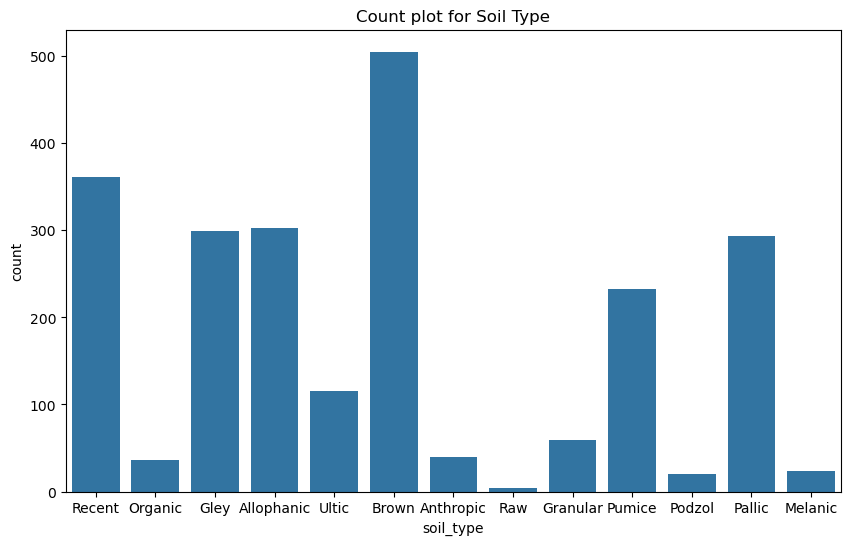

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='soil_type')
plt.title('Count plot for Soil Type')
plt.show()

The bar chart illustrates the frequency of various soil types. The soil types are displayed on the x-axis, and their counts are on the y-axis. Among the soil types, "Brown" has the highest count, exceeding 500, followed by "Pallic" and "Recent," each with counts around 300. "Pumice," "Gley," and "Allophanic" soils also have notable frequencies, while "Organic," "Anthropic," "Raw," "Podzol," and "Melanic" are less prevalent, with "Raw" and "Podzol" having the lowest counts. This distribution highlights the predominance of certain soil types within the dataset.

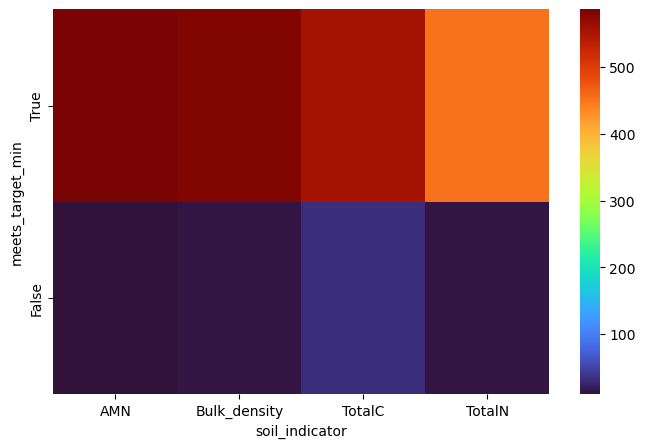

In [ ]:
plt.subplots(figsize=(8, 5))
df_2dhist = pd.DataFrame({
    x_label: grp['meets_target_min'].value_counts()
    for x_label, grp in data.groupby('soil_indicator')
})
sns.heatmap(df_2dhist, cmap='turbo')
plt.xlabel('soil_indicator')
_ = plt.ylabel('meets_target_min')

The heatmap visualizes the relationship between different soil indicators and their target minimum values. The x-axis represents various soil indicators: AMN, Bulk_density, TotalC, and TotalN. The y-axis indicates whether the soil meets the target minimum or not. The color intensity represents the count, with a scale ranging from dark purple to bright orange. The data shows that for all soil indicators, there is a significant number of cases meeting the target minimum, especially for the TotalN indicator, which exhibits the highest counts in the "True" category.

In [ ]:
pivot_table = data.pivot_table(index='soil_indicator', columns='region', values='value', aggfunc='mean')
pivot_table

region,Auckland,Bay of Plenty,Canterbury,Hawke's Bay,Manawatu-Whanganui,Marlborough,Southland,Taranaki,Tasman,Waikato,Wellington
soil_indicator,,,,,,,,,,,
AMN,140.199309,159.524892,120.261905,131.536585,102.525995,116.604167,154.000000,164.120357,116.305055,181.383234,120.730099
Bulk_density,0.924991,0.855296,1.059524,1.028230,1.098724,1.172318,0.994628,0.756481,1.136600,0.786088,1.117473
TotalC,6.124437,6.713099,4.828571,4.917683,4.741695,4.194271,5.568750,9.195387,3.714019,8.112309,4.633414
TotalN,0.507625,0.696233,0.401053,0.462245,0.463592,0.407075,0.431250,0.782822,0.380670,0.702582,0.472110


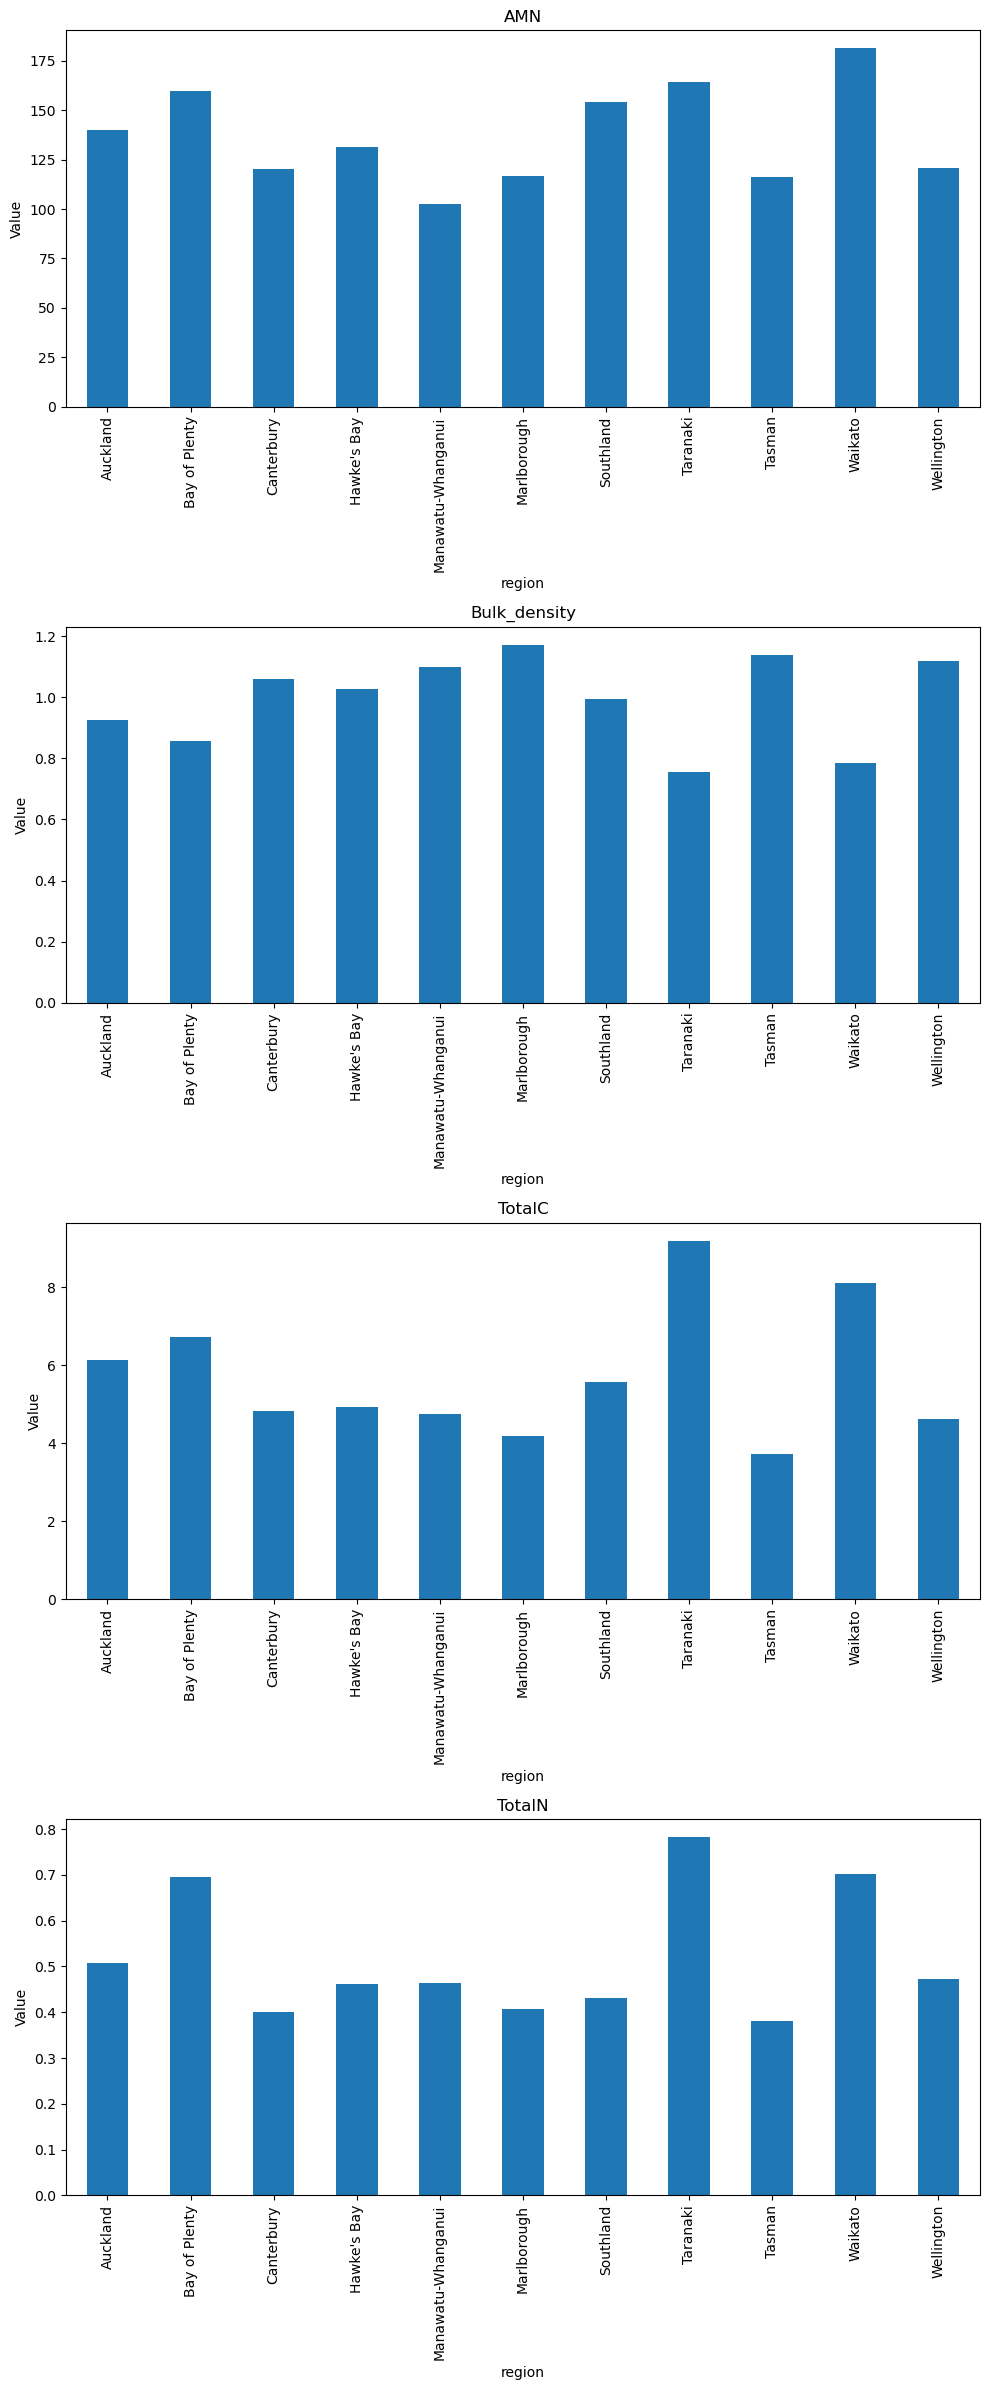

In [ ]:
pivot_table_transposed = pivot_table.T
fig, axes = plt.subplots(nrows=len(pivot_table_transposed.columns), figsize=(10, 6*len(pivot_table_transposed.columns)))
for i, column in enumerate(pivot_table_transposed.columns):
    pivot_table_transposed[column].plot(kind='bar', ax=axes[i])
    axes[i].set_title(str(column))
    axes[i].set_ylabel('Value')
plt.tight_layout()
plt.show()

The first subplot shows the AMN values across various regions. Bay of Plenty and Waikato exhibit the highest values, each exceeding 150, whereas Manawatu-Whanganui and Canterbury display the lowest values, both around 100.

The second subplot shows the Bulk_density values for the same regions. Marlborough has the highest bulk density at approximately 1.2, followed closely by Manawatu-Whanganui and Wellington. In contrast, Bay of Plenty and Southland have the lowest values, around 0.8.

The third subplot shows TotalC values. Taranaki stands out with the highest TotalC value above 8, followed by Waikato. Marlborough and Tasman, on the other hand, have the lowest TotalC values, both around 4.

The fourth subplot shows TotalN values across regions. Bay of Plenty and Taranaki have the highest TotalN values, each around 0.7, while Canterbury and Tasman show the lowest values, both below 0.4


In [ ]:
soil_df = data.rename(columns={'region': 'Region'})
soil_df

,Region,soil_type,time_step,soil_indicator,trace_element,value,target_min,target_max,meets_target_min,meets_target_max,within_target_range
0,Auckland,Recent,2014 - 2018,AMN,False,133.606236,50.00,NaN,True,NaN,NaN
1,Auckland,Recent,2014 - 2018,Bulk_density,False,0.976667,0.70,1.4,True,True,True
2,Auckland,Recent,2014 - 2018,TotalC,False,3.453214,2.00,NaN,True,NaN,NaN
3,Auckland,Recent,2014 - 2018,TotalN,False,0.325620,0.25,0.7,True,True,True
4,Auckland,Organic,2014 - 2018,AMN,False,243.613965,50.00,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2287,Wellington,Brown,2014 - 2018,TotalN,False,0.416153,0.25,0.7,True,True,True
2288,Wellington,Brown,2014 - 2018,AMN,False,163.412556,50.00,NaN,True,NaN,NaN
2289,Wellington,Brown,2014 - 2018,Bulk_density,False,0.880000,0.60,1.4,True,True,True
2290,Wellington,Brown,2014 - 2018,TotalC,False,8.682056,2.50,NaN,True,NaN,NaN


In [ ]:
column_names = soil_df.columns.drop(['Region', 'time_step', 'soil_indicator'])

soil_final_df = pd.DataFrame()
for column in column_names:
    pivot_df = soil_df.pivot_table(index=['Region', 'time_step'],  columns='soil_indicator', values=column, aggfunc='first').reset_index()
    new_column_names = {indicator: f"{indicator}_{column}" for indicator in soil_df['soil_indicator'].unique()}
    pivot_df = pivot_df.rename(columns=new_column_names)

    if soil_final_df.empty:
        soil_final_df = pivot_df
    else:
        soil_final_df = pd.merge(soil_final_df, pivot_df, on=['Region', 'time_step'], how='left')

soil_final_df

soil_indicator,Region,time_step,AMN_soil_type,Bulk_density_soil_type,TotalC_soil_type,TotalN_soil_type,AMN_trace_element,Bulk_density_trace_element,TotalC_trace_element,TotalN_trace_element,...,AMN_meets_target_min,Bulk_density_meets_target_min,TotalC_meets_target_min,TotalN_meets_target_min,Bulk_density_meets_target_max,TotalN_meets_target_max,AMN_within_target_range,Bulk_density_within_target_range,TotalC_within_target_range,TotalN_within_target_range
0,Auckland,2014 - 2018,Recent,Recent,Recent,Recent,False,False,False,False,...,True,True,True,True,True,True,False,True,False,True
1,Bay of Plenty,2014 - 2018,Recent,Recent,Recent,Recent,False,False,False,False,...,True,True,True,True,True,True,NaN,True,False,True
2,Canterbury,2014 - 2018,Brown,Brown,Brown,Brown,False,False,False,False,...,True,True,True,True,True,True,False,True,False,True
3,Hawke's Bay,2014 - 2018,Pallic,Pallic,Pallic,Pallic,False,False,False,False,...,True,True,True,True,True,True,NaN,True,False,True
4,Manawatu-Whanganui,2014 - 2018,Gley,Gley,Gley,Gley,False,False,False,False,...,True,True,True,True,True,True,False,True,False,True
5,Marlborough,2014 - 2018,Recent,Recent,Recent,Recent,False,False,False,False,...,True,True,True,True,True,True,False,True,False,True
6,Southland,2014 - 2018,Brown,Brown,Brown,Brown,False,False,False,False,...,True,True,True,True,True,True,NaN,True,NaN,True
7,Taranaki,2014 - 2018,Allophanic,Allophanic,Allophanic,Allophanic,False,False,False,False,...,True,True,True,True,True,True,NaN,True,NaN,True
8,Tasman,2014 - 2018,Brown,Brown,Brown,Brown,False,False,False,False,...,True,True,True,True,True,True,NaN,True,False,True
9,Waikato,2014 - 2018,Allophanic,Allophanic,Allophanic,Allophanic,False,False,False,False,...,True,True,True,True,True,False,NaN,True,NaN,False


In [ ]:
columns_names_soil= soil_final_df.columns
columns_names_soil

Index(['Region', 'time_step', 'AMN_soil_type', 'Bulk_density_soil_type',
       'TotalC_soil_type', 'TotalN_soil_type', 'AMN_trace_element',
       'Bulk_density_trace_element', 'TotalC_trace_element',
       'TotalN_trace_element', 'AMN_value', 'Bulk_density_value',
       'TotalC_value', 'TotalN_value', 'AMN_target_min',
       'Bulk_density_target_min', 'TotalC_target_min', 'TotalN_target_min',
       'Bulk_density_target_max', 'TotalN_target_max', 'AMN_meets_target_min',
       'Bulk_density_meets_target_min', 'TotalC_meets_target_min',
       'TotalN_meets_target_min', 'Bulk_density_meets_target_max',
       'TotalN_meets_target_max', 'AMN_within_target_range',
       'Bulk_density_within_target_range', 'TotalC_within_target_range',
       'TotalN_within_target_range'],
      dtype='object', name='soil_indicator')

In [ ]:
#check regions' names:
soil_region_names = soil_final_df['Region'].unique()
soil_region_names

array(['Auckland', 'Bay of Plenty', 'Canterbury', "Hawke's Bay",
       'Manawatu-Whanganui', 'Marlborough', 'Southland', 'Taranaki',
       'Tasman', 'Waikato', 'Wellington'], dtype=object)

In [ ]:
#chnage the name Manawatu-Whanganui to  Manawatū-Whanganui:
soil_final_df['Region'] = soil_final_df['Region'].replace('Manawatu-Whanganui', 'Manawatū-Whanganui', regex=True)
soil_region_names_1 = soil_final_df['Region'].unique()
soil_region_names_1

array(['Auckland', 'Bay of Plenty', 'Canterbury', "Hawke's Bay",
       'Manawatū-Whanganui', 'Marlborough', 'Southland', 'Taranaki',
       'Tasman', 'Waikato', 'Wellington'], dtype=object)

In [ ]:
#Some data in columns 'AMN_within_target_range','Bulk_density_within_target_range', 'TotalC_within_target_range','TotalN_within_target_range' is missed
#but this data  could be completed based on other available data

list_of_regions=['Waikato','Bay of Plenty',"Hawke's Bay",'Taranaki', 'Tasman','Southland' ]

for region in list_of_regions:
     soil_final_df.loc[soil_final_df['Region'] == region, 'AMN_within_target_range'] = 'NO_TARGET_MAX'

list_of_regions_totalC=['Waikato','Taranaki', 'Southland' ]
for region in list_of_regions_totalC:
     soil_final_df.loc[soil_final_df['Region'] == region, 'TotalC_within_target_range'] = 'NO_TARGET_MAX'

## Data Agricultural practices

Agricultural practices refer to the various techniques, methods, and processes that farmers use to cultivate crops and manage their farms. Include the fertilisers data to  the project.

Collect data for each region from followinf website: https://figure.nz/chart/7PbopFShHTmHPBno-1759TvWcpVpH0O2S

In [ ]:
soil_region_names_1

array(['Auckland', 'Bay of Plenty', 'Canterbury', "Hawke's Bay",
       'Manawatū-Whanganui', 'Marlborough', 'Southland', 'Taranaki',
       'Tasman', 'Waikato', 'Wellington'], dtype=object)

In [ ]:
#generate the function to scrape the data from website:
def scrape_data(url, region):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "lxml")
    tables = soup.find_all("table", {"class": "data-table"})
    data = []

    for table in tables:
        rows = table.find_all('tr')
        for row in rows:
            cells = row.find_all('td')
            if len(cells) > 0:
                category = cells[0].get_text(strip=True)
                tonnes_applied = cells[1].get_text(strip=True)
                data.append((region, category, tonnes_applied))

    return pd.DataFrame(data, columns=['Region', 'Year', 'Fertilizer Tonnes Applied'])

In [ ]:
regions_urls = {
    "Auckland": "https://figure.nz/chart/7PbopFShHTmHPBno-LRubqArqFN90Qsjl",
    "Bay of Plenty" : "https://figure.nz/chart/dO2jEHiP7M8lAtJK",
    "Canterbury": "https://figure.nz/chart/7PbopFShHTmHPBno-Vi5kmqbMuWya3Qw1",
    "Hawke's Bay" : "https://figure.nz/chart/7PbopFShHTmHPBno-VVckVRbCTkKIzaFM",
    "Marlborough": "https://figure.nz/chart/k6SF6pXNzPwVqE4U",
    "Manawatū-Whanganui": "https://figure.nz/chart/7PbopFShHTmHPBno-qDHaa7ZTvT8f3AMe",
    "Southland": "https://figure.nz/chart/7PbopFShHTmHPBno-reBEunOEMxxTzQja",
    "Taranaki":"https://figure.nz/chart/7PbopFShHTmHPBno-oYRJKN0Ir2N9lpUM",
    "Tasman": "https://figure.nz/chart/Z5LZNkSqwD8TliI0",
    "Waikato": "https://figure.nz/chart/7PbopFShHTmHPBno-1759TvWcpVpH0O2S",
    "Wellington" : "https://figure.nz/chart/nxqZ63ZMEtSEJzRn"
}


In [ ]:
fertiliser_regions_df = []
for region, url in regions_urls.items():
    df = scrape_data(url, region)
    fertiliser_regions_df.append(df)

# Concatenate DataFrames
fertiliser_df = pd.concat(fertiliser_regions_df, ignore_index=True)
fertiliser_df

,Region,Year,Fertilizer Tonnes Applied
0,Auckland,2002,"60,792"
1,Auckland,2003,"58,221"
2,Auckland,2004,"64,017"
3,Auckland,2005,"58,484"
4,Auckland,2006,"49,470"
...,...,...,...
237,Wellington,2019,"55,252"
238,Wellington,2020,"56,126"
239,Wellington,2021,"54,327"
240,Wellington,2022,"54,058"


In [ ]:
fertiliser_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Region                     242 non-null    object
 1   Year                       242 non-null    object
 2   Fertilizer Tonnes Applied  242 non-null    object
dtypes: object(3)
memory usage: 5.8+ KB


In [ ]:
none_values = fertiliser_df[fertiliser_df['Fertilizer Tonnes Applied'] == 'None']
none_values

,Region,Year,Fertilizer Tonnes Applied
19,Auckland,2021,None
31,Bay of Plenty,2011,None
97,Marlborough,2011,None
109,Marlborough,2023,None
185,Tasman,2011,None
229,Wellington,2011,None


In [ ]:
#convert 'Fertilizer Tonnes Applied' column to numeric:
fertiliser_df['Fertilizer Tonnes Applied'] = pd.to_numeric(fertiliser_df['Fertilizer Tonnes Applied'].str.replace(',', ''), errors='coerce')
fertiliser_df['Year'] = pd.to_numeric(fertiliser_df['Year'], errors='coerce')

In [ ]:
fertiliser_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Region                     242 non-null    object 
 1   Year                       242 non-null    int64  
 2   Fertilizer Tonnes Applied  236 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.8+ KB


In [ ]:
fertiliser_df

,Region,Year,Fertilizer Tonnes Applied
0,Auckland,2002,60792.0
1,Auckland,2003,58221.0
2,Auckland,2004,64017.0
3,Auckland,2005,58484.0
4,Auckland,2006,49470.0
...,...,...,...
237,Wellington,2019,55252.0
238,Wellington,2020,56126.0
239,Wellington,2021,54327.0
240,Wellington,2022,54058.0


In [ ]:
nan_values = fertiliser_df[pd.isna(fertiliser_df['Fertilizer Tonnes Applied'])]
nan_values

,Region,Year,Fertilizer Tonnes Applied
19,Auckland,2021,NaN
31,Bay of Plenty,2011,NaN
97,Marlborough,2011,NaN
109,Marlborough,2023,NaN
185,Tasman,2011,NaN
229,Wellington,2011,NaN


In [ ]:
#check how many missed values in the dataset "fertiliser_df":
missing_values_count = fertiliser_df.isna().sum()
missing_values_count

Region                       0
Year                         0
Fertilizer Tonnes Applied    6
dtype: int64

Refill each missed value by the mean applied fertiliser for each region.

In [ ]:
average_values = fertiliser_df.groupby('Region')['Fertilizer Tonnes Applied'].transform('mean')

fertiliser_df['Fertilizer Tonnes Applied'] = fertiliser_df['Fertilizer Tonnes Applied'].fillna(average_values)

#check if there any missing values are left:
nan_values_1 = fertiliser_df[pd.isna(fertiliser_df['Fertilizer Tonnes Applied'])]
nan_values_1

,Region,Year,Fertilizer Tonnes Applied


Visualize how the amount of fertilizer changes through the years for different regions.

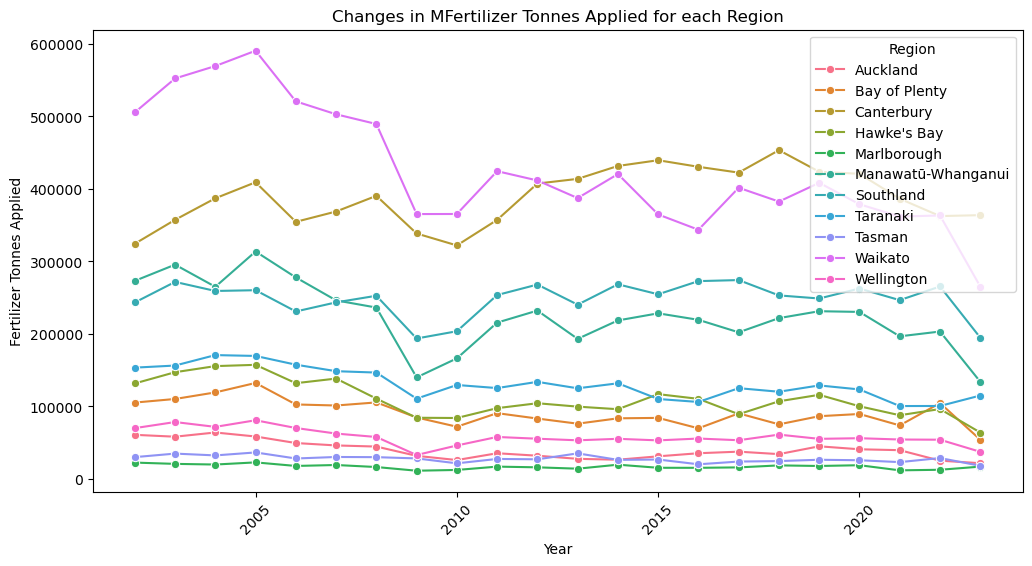

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=fertiliser_df, x='Year', y='Fertilizer Tonnes Applied', hue='Region', marker='o')
plt.xlabel('Year')
plt.ylabel('Fertilizer Tonnes Applied')
plt.title('Changes in MFertilizer Tonnes Applied for each Region')
plt.xticks(rotation=45)
plt.show()

In general, for all regions, it is visible that there is a tendency for a decrease in fertilizer application, for some rgions this decrease is not significant, for other regions is more sufficient.  The amount of applied fertilizers has dramatically dropped for the Waikato region by 2023 compared to the year 2005.

However, this project is focused on the data from the years 2019-2023 (inclusive). Apply the filter to get the dataset for these years.


In [ ]:
fertiliser_final_df = fertiliser_df[(fertiliser_df['Year'] >= 2019)]
fertiliser_final_df.loc[:, 'Fertilizer Tonnes Applied'] = fertiliser_final_df['Fertilizer Tonnes Applied'].round()
fertiliser_final_df.head(5)

,Region,Year,Fertilizer Tonnes Applied
17,Auckland,2019,44957.0
18,Auckland,2020,40852.0
19,Auckland,2021,39616.0
20,Auckland,2022,25174.0
21,Auckland,2023,21648.0


In [ ]:
unique_years_fert = fertiliser_final_df['Year'].unique()
unique_years_fert

array([2019, 2020, 2021, 2022, 2023], dtype=int64)

## Merge datasets: Crop yield, weather, soil, fertiliser.

Prepare a combined dataset for use in the upcoming modeling analysis and prediction.

In [ ]:
# trim whitespace from all datasets:
crop_df['Region'] = crop_df['Region'].str.strip()
weather_final_df['Region'] = weather_final_df['Region'].str.strip()
soil_final_df['Region'] = soil_final_df['Region'].str.strip()
fertiliser_final_df.loc[:, 'Region'] = fertiliser_final_df['Region'].str.strip()

#merge all datasets together:
crop_weather_df = pd.merge(crop_df, weather_final_df, on=['Region', 'Year'], how='outer')
crop_weather_soils_df = pd.merge(crop_weather_df, soil_final_df, on=['Region'], how='outer')
crop_weather_soils_fertiliser_df = pd.merge(crop_weather_soils_df, fertiliser_final_df, on=['Region', 'Year'], how='outer')
crop_weather_soils_fertiliser_df.tail(100)

,Region,Wheat Tonnes,Wheat Hectares,Barley Tonnes,Barley Hectares,Maize grain Tonnes,Maize grain Hectares,Year,September Total Rainfall (mm),October Total Rainfall (mm),...,Bulk_density_meets_target_min,TotalC_meets_target_min,TotalN_meets_target_min,Bulk_density_meets_target_max,TotalN_meets_target_max,AMN_within_target_range,Bulk_density_within_target_range,TotalC_within_target_range,TotalN_within_target_range,Fertilizer Tonnes Applied
33,Hawke's Bay,NaN,NaN,NaN,NaN,NaN,NaN,2017,110.2,49.4,...,True,True,True,True,True,NO_TARGET_MAX,True,False,True,NaN
34,Hawke's Bay,NaN,NaN,NaN,NaN,NaN,NaN,2018,205.8,50.4,...,True,True,True,True,True,NO_TARGET_MAX,True,False,True,NaN
35,Hawke's Bay,4000.0,600.0,9000.0,1700.0,33000.0,2600.0,2019,58.2,91.6,...,True,True,True,True,True,NO_TARGET_MAX,True,False,True,115984.0
36,Hawke's Bay,4700.0,600.0,9400.0,1500.0,51200.0,4000.0,2020,97.4,85.2,...,True,True,True,True,True,NO_TARGET_MAX,True,False,True,100182.0
37,Hawke's Bay,2600.0,300.0,13800.0,2000.0,52000.0,4400.0,2021,150.2,37.0,...,True,True,True,True,True,NO_TARGET_MAX,True,False,True,87826.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,West Coast,0.0,0.0,0.0,0.0,200.0,0.0,2019,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,West Coast,0.0,0.0,0.0,0.0,0.0,0.0,2020,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,West Coast,0.0,0.0,0.0,0.0,0.0,0.0,2021,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,West Coast,200.0,0.0,2700.0,400.0,0.0,0.0,2022,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#drop columns for region Northland, Gisborn ,Nelson,West Coast,Chatham Islands,Otago because many data is missed:
crop_wether_soils_fertiliser_df = crop_weather_soils_fertiliser_df[~crop_weather_soils_fertiliser_df['Region'].isin(['Northland','Gisborne','Nelson','West Coast','Chatham Islands','Otago'])]

#also remove rows 'Total South Island','Total New Zealand','Total North Island'
crop_wether_soils_fertiliser_df = crop_wether_soils_fertiliser_df[~crop_wether_soils_fertiliser_df['Region'].isin(['Total South Island','Total New Zealand','Total North Island'])]

In [ ]:
#chasnge the data type of column 'Year' to int:
crop_wether_soils_fertiliser_df['Year'] = crop_wether_soils_fertiliser_df['Year'].astype(int)

In [ ]:
#drop rows for columnd "Year" = 2017,2018 and 2024.
crop_wether_soils_fertiliser_df = crop_wether_soils_fertiliser_df[~crop_wether_soils_fertiliser_df['Year'].isin([2017, 2018, 2024])]
crop_wether_soils_fertiliser_df.head(15)

,Region,Wheat Tonnes,Wheat Hectares,Barley Tonnes,Barley Hectares,Maize grain Tonnes,Maize grain Hectares,Year,September Total Rainfall (mm),October Total Rainfall (mm),...,Bulk_density_meets_target_min,TotalC_meets_target_min,TotalN_meets_target_min,Bulk_density_meets_target_max,TotalN_meets_target_max,AMN_within_target_range,Bulk_density_within_target_range,TotalC_within_target_range,TotalN_within_target_range,Fertilizer Tonnes Applied
1,Auckland,0.0,0.0,600.0,200.0,3400.0,300.0,2019,122.8,75.4,...,True,True,True,True,True,False,True,False,True,44957.0
2,Auckland,0.0,0.0,1000.0,200.0,2400.0,300.0,2020,43.4,33.0,...,True,True,True,True,True,False,True,False,True,40852.0
3,Auckland,0.0,0.0,2200.0,300.0,3800.0,300.0,2021,124.0,126.2,...,True,True,True,True,True,False,True,False,True,39616.0
4,Auckland,0.0,0.0,400.0,100.0,8900.0,1000.0,2022,105.2,109.4,...,True,True,True,True,True,False,True,False,True,25174.0
5,Auckland,0.0,0.0,0.0,0.0,5700.0,0.0,2023,127.8,53.4,...,True,True,True,True,True,False,True,False,True,21648.0
9,Bay of Plenty,0.0,0.0,0.0,0.0,29200.0,2600.0,2019,95.8,95.4,...,True,True,True,True,True,NO_TARGET_MAX,True,False,True,86492.0
10,Bay of Plenty,0.0,0.0,0.0,0.0,33700.0,2800.0,2020,32.6,25.0,...,True,True,True,True,True,NO_TARGET_MAX,True,False,True,89546.0
11,Bay of Plenty,0.0,0.0,0.0,0.0,36100.0,3100.0,2021,128.8,187.4,...,True,True,True,True,True,NO_TARGET_MAX,True,False,True,73784.0
12,Bay of Plenty,0.0,0.0,0.0,0.0,21700.0,2100.0,2022,224.0,102.0,...,True,True,True,True,True,NO_TARGET_MAX,True,False,True,104573.0
13,Bay of Plenty,0.0,0.0,0.0,0.0,23100.0,3000.0,2023,286.8,0.0,...,True,True,True,True,True,NO_TARGET_MAX,True,False,True,54134.0


In [ ]:
#all missed values are repplaced by zero:
crop_wether_soils_fertiliser_df.replace(['S', '-'], np.nan, inplace=True)
crop_wether_soils_fertiliser_df.fillna(0, inplace=True)

C:\Users\dress\AppData\Local\Temp\ipykernel_15612\471047463.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  crop_wether_soils_fertiliser_df.replace(['S', '-'], np.nan, inplace=True)


In [ ]:
#douwnload the document
crop_wether_soils_fertiliser_df.to_csv('crop_wether_soils_fertiliser.csv')

## 2. A machine learning model to forecast crop yields

### Regression

The dataset includes several continuous numerical variables. However, the number of predictor variables exceeds that of the target variables. In this scenario, the analysis could focus on specific predictors with the aim of reducing their number.

In [ ]:
crop_wether_soils_fertiliser_w_df=crop_wether_soils_fertiliser_df[[
 'Wheat Tonnes',
 'Wheat Hectares',
 'September Total Rainfall (mm)',
 'October Total Rainfall (mm)',
 'November Total Rainfall (mm)',
 'December Total Rainfall (mm)',
 'January Total Rainfall (mm)',
 'February Total Rainfall (mm)',
 'March Total Rainfall (mm)',
 'April Total Rainfall (mm)',
 'May Total Rainfall (mm)',
 'June Total Rainfall (mm)',
 'July Total Rainfall (mm)',
 'August Total Rainfall (mm)',
 'September Wet Day - 1mm or more of Rain (day)',
 'October Wet Day - 1mm or more of Rain (day)',
 'November Wet Day - 1mm or more of Rain (day)',
 'December Wet Day - 1mm or more of Rain (day)',
 'January Wet Day - 1mm or more of Rain (day)',
 'February Wet Day - 1mm or more of Rain (day)',
 'March Wet Day - 1mm or more of Rain (day)',
 'April Wet Day - 1mm or more of Rain (day)',
 'May Wet Day - 1mm or more of Rain (day)',
 'June Wet Day - 1mm or more of Rain (day)',
 'July Wet Day - 1mm or more of Rain (day)',
 'August Wet Day - 1mm or more of Rain (day)',
 'September Mean Air Temperature (Celsius)',
 'October Mean Air Temperature (Celsius)',
 'November Mean Air Temperature (Celsius)',
 'December Mean Air Temperature (Celsius)',
 'January Mean Air Temperature (Celsius)',
 'February Mean Air Temperature (Celsius)',
 'March Mean Air Temperature (Celsius)',
 'April Mean Air Temperature (Celsius)',
 'May Mean Air Temperature (Celsius)',
 'June Mean Air Temperature (Celsius)',
 'July Mean Air Temperature (Celsius)',
 'August Mean Air Temperature (Celsius)',
 'September Total Sunshine (hrs)',
 'October Total Sunshine (hrs)',
 'November Total Sunshine (hrs)',
 'December Total Sunshine (hrs)',
 'January Total Sunshine (hrs)',
 'February Total Sunshine (hrs)',
 'March Total Sunshine (hrs)',
 'April Total Sunshine (hrs)',
 'May Total Sunshine (hrs)',
 'June Total Sunshine (hrs)',
 'July Total Sunshine (hrs)',
 'August Total Sunshine (hrs)',
 'September Mean Wind Speed (M/Sec)',
 'October Mean Wind Speed (M/Sec)',
 'November Mean Wind Speed (M/Sec)',
 'December Mean Wind Speed (M/Sec)',
 'January Mean Wind Speed (M/Sec)',
 'February Mean Wind Speed (M/Sec)',
 'March Mean Wind Speed (M/Sec)',
 'April Mean Wind Speed (M/Sec)',
 'May Mean Wind Speed (M/Sec)',
 'June Mean Wind Speed (M/Sec)',
 'July Mean Wind Speed (M/Sec)',
 'August Mean Wind Speed (M/Sec)',
 'AMN_value',
 'Bulk_density_value',
 'TotalC_value',
 'TotalN_value']]
crop_wether_soils_fertiliser_w_df = crop_wether_soils_fertiliser_w_df.loc[crop_wether_soils_fertiliser_w_df['Wheat Tonnes'] != 0]

In [ ]:
# fill the missing values by finding the mean tonne to hectare ratio
ratio = []
total = 0
for index, row in crop_wether_soils_fertiliser_w_df.iterrows():
  if (row['Wheat Hectares'] == 0):
    continue
  ratio.append(row['Wheat Tonnes']/row['Wheat Hectares'])

for index, row in crop_wether_soils_fertiliser_w_df.iterrows():
  if (row['Wheat Hectares'] == 0):
    row['Wheat Hectares'] = row['Wheat Tonnes']/np.mean(ratio)

In [ ]:
crop_wether_soils_fertiliser_w_df['Wheat Tonnes per Hect'] = crop_wether_soils_fertiliser_w_df['Wheat Tonnes']/crop_wether_soils_fertiliser_w_df['Wheat Hectares']
crop_wether_soils_fertiliser_w_df.drop(['Wheat Tonnes', 'Wheat Hectares'], axis=1, inplace=True)
crop_wether_soils_fertiliser_w_df.corr()

,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),May Total Rainfall (mm),June Total Rainfall (mm),...,April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value,Wheat Tonnes per Hect
September Total Rainfall (mm),1.000000,0.318585,0.648280,0.571597,0.329098,0.388711,0.667925,0.565701,0.592360,0.463747,...,0.645489,0.693824,0.685632,0.786163,0.464638,-0.046071,0.236774,-0.258769,0.250667,-0.323551
October Total Rainfall (mm),0.318585,1.000000,0.216768,0.335466,0.553920,0.050224,0.018295,0.425945,0.300669,0.230217,...,0.390222,0.529236,0.244836,0.514459,0.407607,0.024440,0.206048,-0.096148,0.196593,-0.111995
November Total Rainfall (mm),0.648280,0.216768,1.000000,0.372335,0.151951,0.175530,0.273792,0.363226,0.357396,0.698535,...,0.674038,0.464024,0.622906,0.576469,0.474702,0.404144,0.046484,0.021999,0.514242,0.069963
December Total Rainfall (mm),0.571597,0.335466,0.372335,1.000000,0.296230,0.468208,0.247505,0.321050,0.431083,0.089359,...,0.421791,0.715788,0.548025,0.536814,0.579262,-0.053266,-0.058884,-0.030127,0.257890,-0.477840
January Total Rainfall (mm),0.329098,0.553920,0.151951,0.296230,1.000000,0.120769,0.142623,0.622651,0.410373,0.090426,...,0.202737,0.266872,-0.013043,0.351049,0.006642,-0.145023,0.098851,-0.095059,-0.066150,-0.203217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMN_value,-0.046071,0.024440,0.404144,-0.053266,-0.145023,-0.218706,0.011699,0.137883,-0.013104,0.054000,...,0.068302,0.027173,0.102295,0.024364,0.169786,1.000000,-0.514833,0.761750,0.774951,0.694791
Bulk_density_value,0.236774,0.206048,0.046484,-0.058884,0.098851,0.218166,0.120734,0.116587,0.240660,0.373608,...,0.354015,0.378869,0.365747,0.396963,0.232847,-0.514833,1.000000,-0.804039,-0.233204,-0.273669
TotalC_value,-0.258769,-0.096148,0.021999,-0.030127,-0.095059,-0.112343,-0.202075,0.041861,-0.044508,-0.254531,...,-0.287344,-0.295848,-0.278273,-0.276227,-0.212935,0.761750,-0.804039,1.000000,0.577985,0.595985
TotalN_value,0.250667,0.196593,0.514242,0.257890,-0.066150,0.151275,0.117486,0.229253,0.202270,0.281651,...,0.429183,0.402927,0.445427,0.412491,0.519796,0.774951,-0.233204,0.577985,1.000000,0.485809


In [ ]:
crop_wether_soils_fertiliser_w_df.columns = [col.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_') for col in crop_wether_soils_fertiliser_w_df.columns]

In [ ]:
X_w = crop_wether_soils_fertiliser_w_df.iloc[:, 1:]
y_w = crop_wether_soils_fertiliser_w_df.iloc[:, 0]

Splitting the data before automated wrapper feature selection to reduce bias.

In [ ]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

selector = RFECV(estimator=LinearRegression(), step=1, cv=5)
selector.fit(X_train_w, y_train_w)

selected_features = X_train_w.columns[selector.support_]
print(selected_features)

Index(['May_Total_Sunshine_hrs'], dtype='object')


In [ ]:
multi_linear = smf.ols(formula='Wheat_Tonnes_per_Hect ~ 1 + May_Wet_Day___1mm_or_more_of_Rain_day + October_Total_Sunshine_hrs', data=crop_wether_soils_fertiliser_w_df).fit()
print(multi_linear.params[0:4])
print('R-Squared: ', multi_linear.rsquared)
multi_linear.summary()

Intercept                                6.454762
May_Wet_Day___1mm_or_more_of_Rain_day   -0.007141
October_Total_Sunshine_hrs               0.013189
dtype: float64
R-Squared:  0.09505481989060993


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Wheat_Tonnes_per_Hect   R-squared:                       0.095
Model:                               OLS   Adj. R-squared:                 -0.000
Method:                    Least Squares   F-statistic:                    0.9979
Date:                   Mon, 27 May 2024   Prob (F-statistic):              0.387
Time:                           11:10:44   Log-Likelihood:                -40.445
No. Observations:                     22   AIC:                             86.89
Df Residuals:                         19   BIC:                             90.16
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 6.4548      2.092      3.086      0.006       2.076      10.833
May_Wet_Day___1mm_or_more_of_Rain_day    -0.0071      0.087     -0.082      0.935      -0.189       0.175
October_Total_Sunshine_hrs                0.0132      0.009      1.397      0.178      -0.007       0.033
==============================================================================
Omnibus:                       26.252   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.258
Skew:                           2.080   Prob(JB):                     2.01e-11
Kurtosis:                       9.035   Cond. No.                     1.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model does not have a significant p value which means that we cannot reject the null hypothesis that there is no relationship between the x and y variable. The Fstatistic is not greater than one and nonsignificant coefficients apart from the intercept also support this.

In [ ]:
predictions = multi_linear.predict(pd.DataFrame(X_test_w))

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test_w, predictions)
mse = mean_squared_error(y_test_w, predictions)
rmse = mean_squared_error(y_test_w, predictions, squared=False)
r2 = r2_score(y_test_w, predictions)
print(mae, mse, rmse, r2)

62.39186349810565 6826.7803747677945 82.62433282494808 -1.3583899250320153


C:\Users\dress\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
print(predictions)
print(y_test_w)

17    9.072452
54    9.692131
38    8.422438
18    9.234457
76    9.419204
dtype: float64
17     42.4
54     38.6
38    167.0
18     92.8
76     17.0
Name: September_Total_Rainfall_mm, dtype: float64


As seen above, the predicted and actual y values are quite far off. This model also does not have a good adjusted R squared number so it is not a sufficient model. Backwards stepwise regression may not be a good approach with this dataset.

In [ ]:
data_w_sunshine = crop_wether_soils_fertiliser_df[['Wheat Tonnes', 'Wheat Hectares', 'September Total Sunshine (hrs)', 'October Total Sunshine (hrs)',
       'November Total Sunshine (hrs)', 'December Total Sunshine (hrs)',
       'January Total Sunshine (hrs)', 'February Total Sunshine (hrs)',
       'March Total Sunshine (hrs)', 'April Total Sunshine (hrs)',
       'May Total Sunshine (hrs)', 'June Total Sunshine (hrs)',
       'July Total Sunshine (hrs)', 'August Total Sunshine (hrs)']]
#drop zero values in column 'Wheat Tonnes'
data_w_sunshine = data_w_sunshine[data_w_sunshine['Wheat Tonnes'] != 0].reset_index(drop=True)

In [ ]:
# fill the missing values by finding the mean tonne to hectare ratio
ratio = []
total = 0
for index, row in data_w_sunshine.iterrows():
  if (row['Wheat Hectares'] == 0):
    continue
  ratio.append(row['Wheat Tonnes']/row['Wheat Hectares'])

for index, row in data_w_sunshine.iterrows():
  if (row['Wheat Hectares'] == 0):
    row['Wheat Hectares'] = row['Wheat Tonnes']/np.mean(ratio)

In [ ]:
# make new column for wheat yield in tonnes per hectare and drop source columns
data_w_sunshine['Wheat Tonnes per Hect'] = data_w_sunshine['Wheat Tonnes']/data_w_sunshine['Wheat Hectares']
data_w_sunshine.drop(['Wheat Tonnes', 'Wheat Hectares'], axis=1, inplace=True)

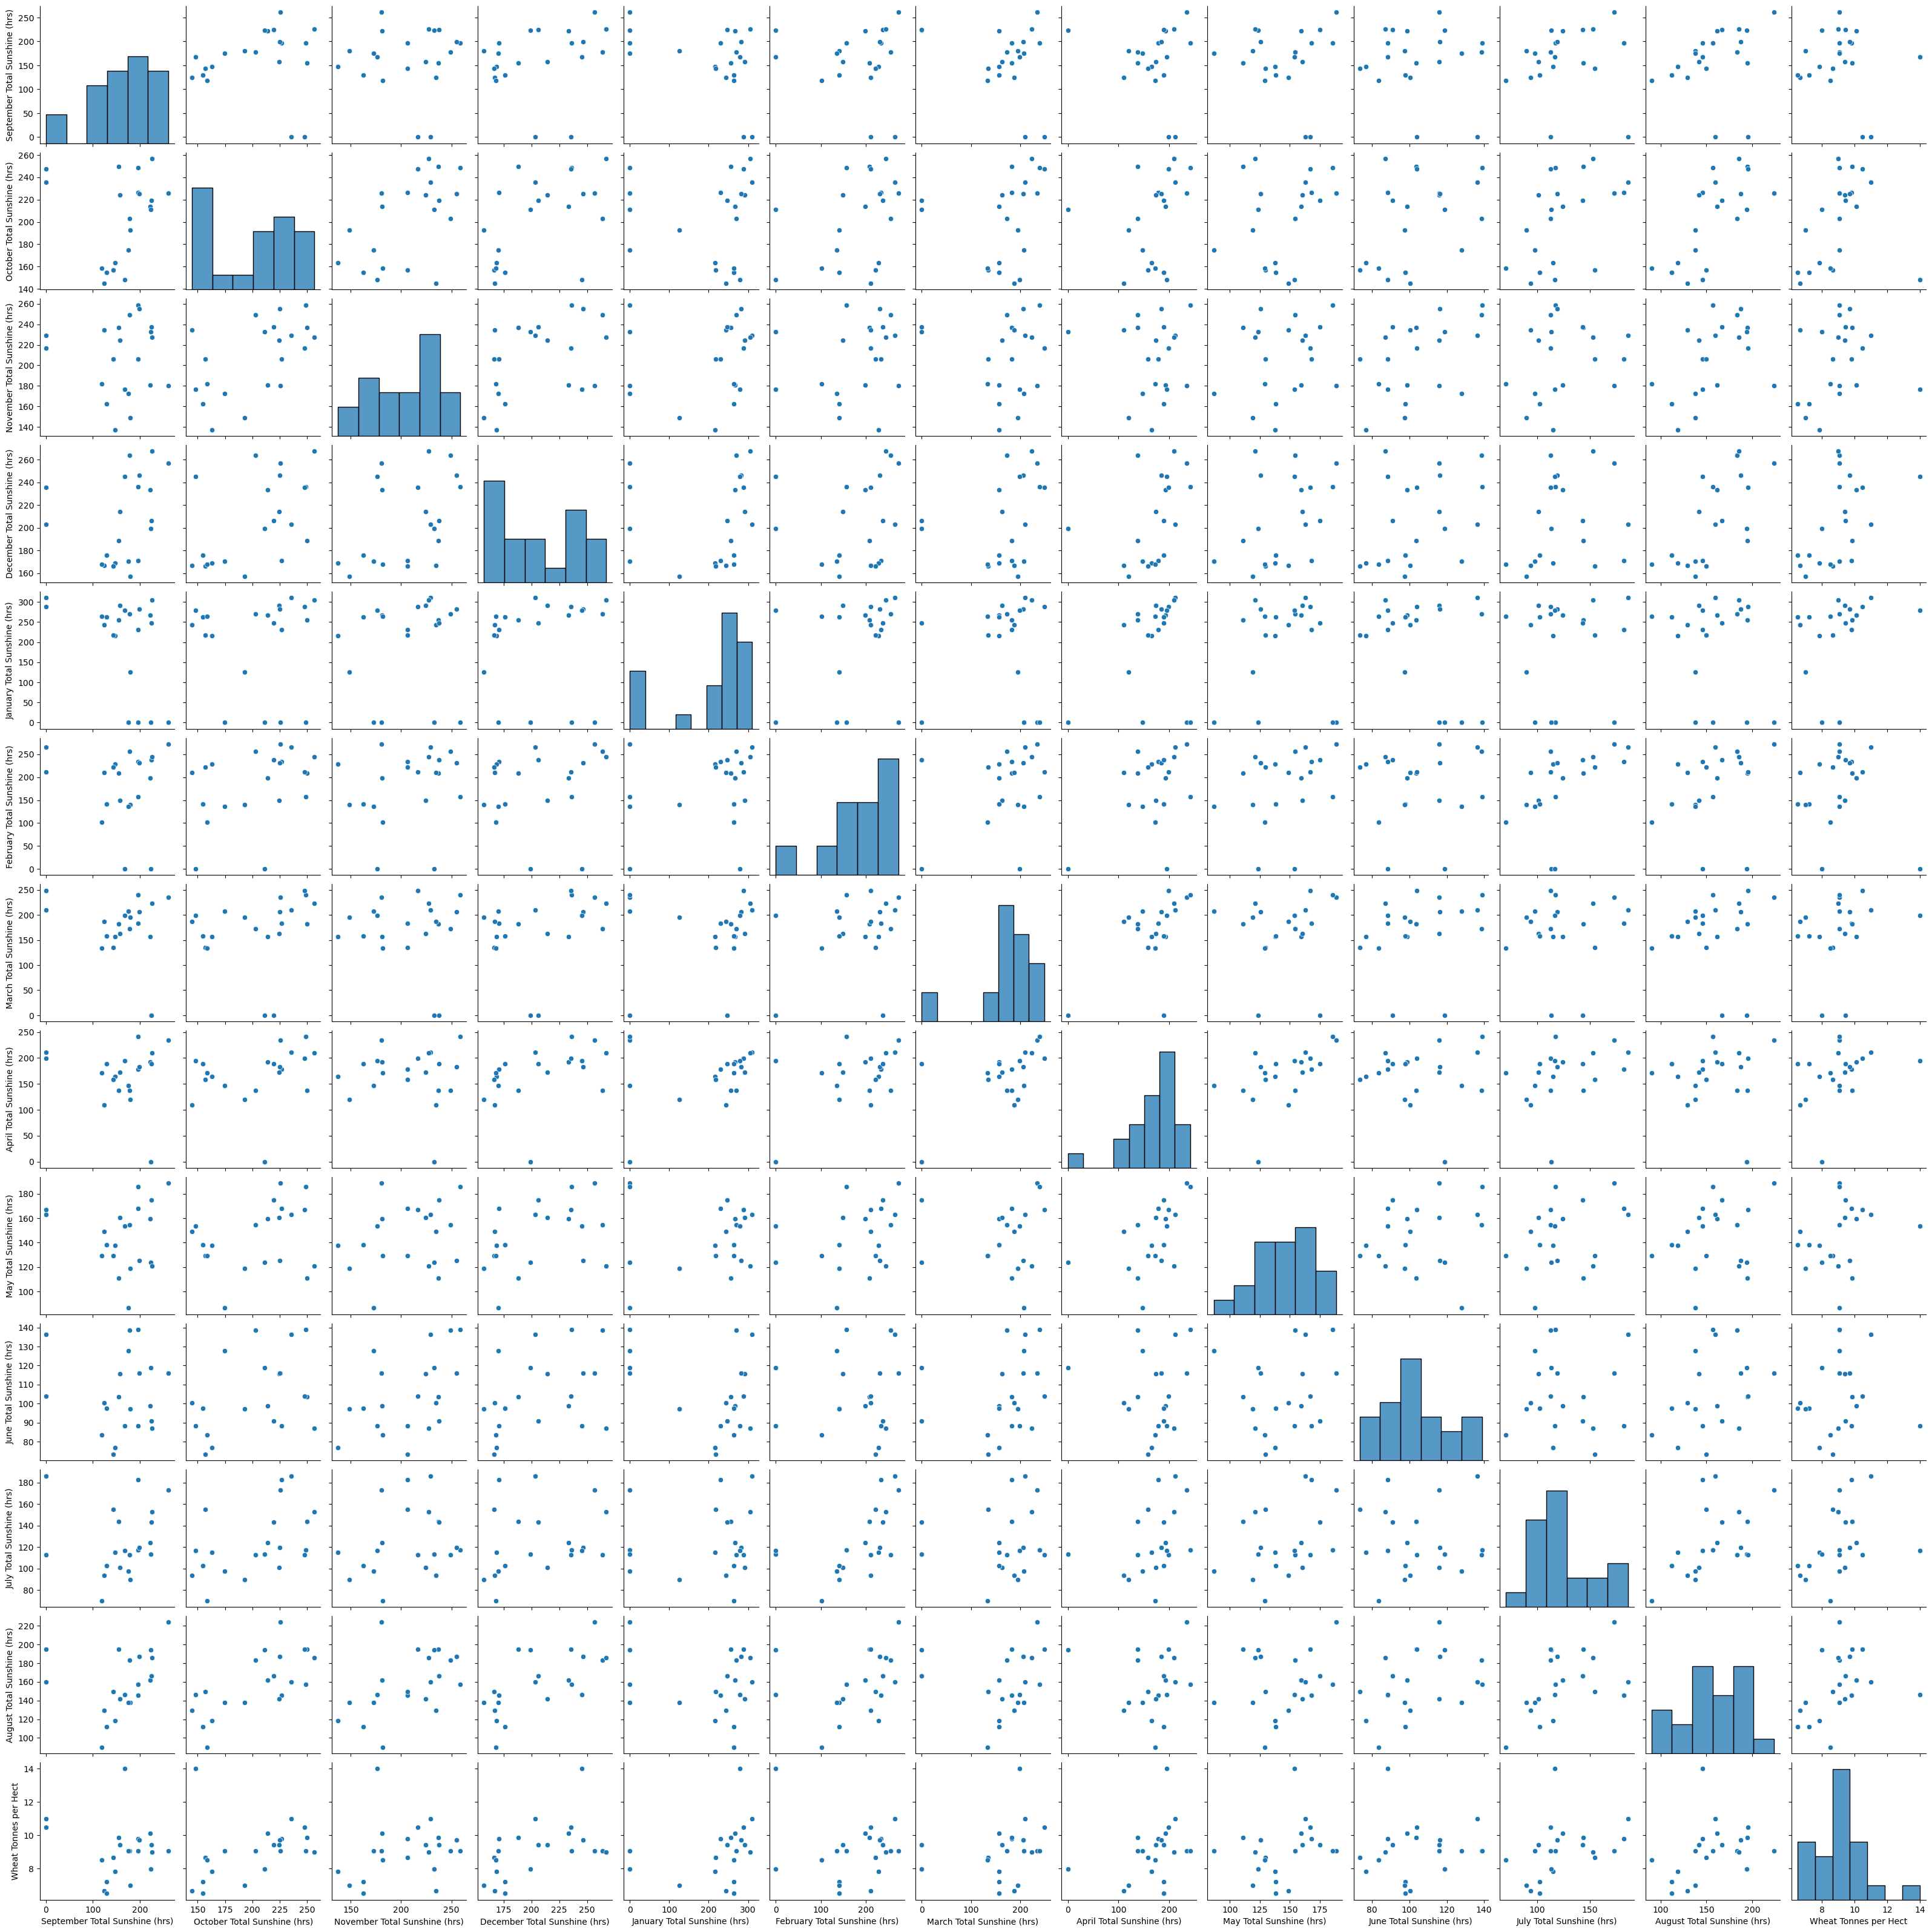

In [ ]:
sns.pairplot(data_w_sunshine)
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [ ]:
data_w_sunshine.columns = data_w_sunshine.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
data_w_sunshine.replace(0, np.nan, inplace=True)
data_w_sunshine

,September_Total_Sunshine_hrs,October_Total_Sunshine_hrs,November_Total_Sunshine_hrs,December_Total_Sunshine_hrs,January_Total_Sunshine_hrs,February_Total_Sunshine_hrs,March_Total_Sunshine_hrs,April_Total_Sunshine_hrs,May_Total_Sunshine_hrs,June_Total_Sunshine_hrs,July_Total_Sunshine_hrs,August_Total_Sunshine_hrs,Wheat_Tonnes_per_Hect
0,177.8,202.8,249.0,264.0,270.7,255.8,172.4,137.7,154.6,138.7,112.8,183.2,9.063889
1,222.4,214.0,181.0,233.2,267.4,198.6,157.1,192.3,159.4,98.8,124.0,161.9,10.108696
2,196.4,226.5,206.2,171.0,230.6,234.3,182.8,178.6,167.9,88.4,182.4,145.8,9.799427
3,157.0,224.4,224.2,214.3,291.8,148.9,163.2,172.8,160.4,115.8,101.0,141.7,9.411411
4,154.6,249.9,236.9,188.4,255.6,208.4,182.4,137.6,110.8,103.7,144.0,194.8,9.849840
5,124.4,144.8,234.6,166.9,243.1,210.6,187.3,109.7,149.0,100.3,93.6,129.3,6.666667
6,147.7,163.1,137.3,168.8,216.1,228.7,156.6,164.6,137.6,76.8,115.0,118.7,7.833333
7,143.6,157.0,206.3,166.3,217.3,221.9,134.6,158.0,129.4,73.3,154.8,149.6,8.666667
8,129.3,154.6,162.6,176.0,263.3,140.8,157.5,189.3,138.3,97.6,102.5,112.2,7.200000
9,129.3,154.6,162.6,176.0,263.3,140.8,157.5,189.3,138.3,97.6,102.5,112.2,6.500000


In [ ]:
# generate the model
mod_lm_w = smf.ols(formula='Wheat_Tonnes_per_Hect ~ 1 + September_Total_Sunshine_hrs + October_Total_Sunshine_hrs + November_Total_Sunshine_hrs	+ December_Total_Sunshine_hrs + January_Total_Sunshine_hrs + February_Total_Sunshine_hrs + March_Total_Sunshine_hrs + April_Total_Sunshine_hrs + May_Total_Sunshine_hrs + June_Total_Sunshine_hrs + July_Total_Sunshine_hrs + August_Total_Sunshine_hrs', data=data_w_sunshine).fit()

mod_lm_w.summary()

C:\Users\dress\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Wheat_Tonnes_per_Hect   R-squared:                       0.988
Model:                               OLS   Adj. R-squared:                  0.846
Method:                    Least Squares   F-statistic:                     6.961
Date:                   Mon, 27 May 2024   Prob (F-statistic):              0.289
Time:                           11:13:28   Log-Likelihood:                 8.4537
No. Observations:                     14   AIC:                             9.093
Df Residuals:                          1   BIC:                             17.40
Df Model:                             12                                         
Covariance Type:               nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        6.2792      3.594      1.747      0.331     -39.387      51.946
September_Total_Sunshine_hrs     0.0394      0.029      1.377      0.400      -0.324       0.402
October_Total_Sunshine_hrs       0.0324      0.011      2.948      0.208      -0.107       0.172
November_Total_Sunshine_hrs      0.0218      0.010      2.205      0.271      -0.104       0.148
December_Total_Sunshine_hrs     -0.0352      0.020     -1.791      0.324      -0.285       0.214
January_Total_Sunshine_hrs       0.0066      0.018      0.376      0.771      -0.218       0.231
February_Total_Sunshine_hrs      0.0197      0.010      2.055      0.288      -0.102       0.142
March_Total_Sunshine_hrs        -0.0517      0.013     -4.038      0.155      -0.215       0.111
April_Total_Sunshine_hrs         0.0115      0.023      0.495      0.708      -0.283       0.306
May_Total_Sunshine_hrs          -0.0252      0.034     -0.740      0.595      -0.458       0.408
June_Total_Sunshine_hrs          0.0251      0.035      0.713      0.606      -0.423       0.473
July_Total_Sunshine_hrs         -0.0213      0.022     -0.978      0.507      -0.298       0.255
August_Total_Sunshine_hrs       -0.0197      0.034     -0.581      0.665      -0.451       0.412
==============================================================================
Omnibus:                        9.120   Durbin-Watson:                   3.000
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.333
Skew:                           0.000   Prob(JB):                      0.00940
Kurtosis:                       7.000   Cond. No.                     1.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This multi linear regression model is to investigate if there is a significant relationship between sunshine hours and wheat crop yield. We have an adjusted R squared value of 0.846 which means that about 84.6% of the variance in y is explained by the monthly sunshine variables. We also have an F statistic of more than 1 but we have an insignificant p value of 0.289 as this is a lot higher than 0.05. None of the coefficients have significant p values either.

In [ ]:
mod_lm_w2 = smf.ols(formula='Wheat_Tonnes_per_Hect ~ 1 + September_Total_Sunshine_hrs + October_Total_Sunshine_hrs + November_Total_Sunshine_hrs	+ December_Total_Sunshine_hrs + February_Total_Sunshine_hrs + March_Total_Sunshine_hrs + April_Total_Sunshine_hrs + May_Total_Sunshine_hrs + June_Total_Sunshine_hrs', data=data_w_sunshine).fit()

mod_lm_w2.summary()

C:\Users\dress\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Wheat_Tonnes_per_Hect   R-squared:                       0.889
Model:                               OLS   Adj. R-squared:                  0.746
Method:                    Least Squares   F-statistic:                     6.220
Date:                   Mon, 27 May 2024   Prob (F-statistic):             0.0125
Time:                           11:14:46   Log-Likelihood:                -7.4177
No. Observations:                     17   AIC:                             34.84
Df Residuals:                          7   BIC:                             43.17
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.6081      1.236      3.728      0.007       1.685       7.531
September_Total_Sunshine_hrs     0.0300      0.010      2.957      0.021       0.006       0.054
October_Total_Sunshine_hrs       0.0150      0.008      1.931      0.095      -0.003       0.033
November_Total_Sunshine_hrs      0.0165      0.007      2.260      0.058      -0.001       0.034
December_Total_Sunshine_hrs     -0.0227      0.009     -2.500      0.041      -0.044      -0.001
February_Total_Sunshine_hrs      0.0050      0.005      0.967      0.366      -0.007       0.017
March_Total_Sunshine_hrs        -0.0385      0.009     -4.532      0.003      -0.059      -0.018
April_Total_Sunshine_hrs         0.0141      0.007      1.929      0.095      -0.003       0.031
May_Total_Sunshine_hrs          -0.0175      0.008     -2.258      0.059      -0.036       0.001
June_Total_Sunshine_hrs          0.0309      0.014      2.275      0.057      -0.001       0.063
==============================================================================
Omnibus:                        1.268   Durbin-Watson:                   1.159
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                0.363
Skew:                          -0.345   Prob(JB):                        0.834
Kurtosis:                       3.192   Cond. No.                     4.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model above had coefficients taken out one by one based on highest p value. Stopped here as removing February seemed to make all the other p values to increase significantly. This model is overall significant as we can see from the small p value, however, this model is still likely overfitted and won't be very helpful for use in the wild.

In [ ]:
data_b_sunshine = crop_wether_soils_fertiliser_df[['Barley Tonnes', 'Barley Hectares', 'September Total Sunshine (hrs)', 'October Total Sunshine (hrs)',
       'November Total Sunshine (hrs)', 'December Total Sunshine (hrs)',
       'January Total Sunshine (hrs)', 'February Total Sunshine (hrs)',
       'March Total Sunshine (hrs)', 'April Total Sunshine (hrs)',
       'May Total Sunshine (hrs)', 'June Total Sunshine (hrs)',
       'July Total Sunshine (hrs)', 'August Total Sunshine (hrs)']]
#drop zero values in column 'Barley Tonnes'
data_b_sunshine = data_b_sunshine[data_b_sunshine['Barley Tonnes'] != 0].reset_index(drop=True)

In [ ]:
# fill the missing values by finding the mean tonne to hectare ratio
ratio = []
total = 0
for index, row in data_b_sunshine.iterrows():
  if (row['Barley Hectares'] == 0):
    continue
  ratio.append(row['Barley Tonnes']/row['Barley Hectares'])

for index, row in data_b_sunshine.iterrows():
  if (row['Barley Hectares'] == 0):
    row['Barley Hectares'] = row['Barley Tonnes']/np.mean(ratio)

In [ ]:
# make new column for barley yield in tonnes per hectare and drop source columns
data_b_sunshine['Barley Tonnes per Hect'] = data_b_sunshine['Barley Tonnes']/data_b_sunshine['Barley Hectares']
data_b_sunshine.drop(['Barley Tonnes', 'Barley Hectares'], axis=1, inplace=True)

In [ ]:
data_b_sunshine.columns = data_b_sunshine.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
data_b_sunshine.replace(0, np.nan, inplace=True)

In [ ]:
mod_lm_b = smf.ols(formula='Barley_Tonnes_per_Hect ~ 1 + September_Total_Sunshine_hrs + October_Total_Sunshine_hrs + November_Total_Sunshine_hrs	+ December_Total_Sunshine_hrs + January_Total_Sunshine_hrs + February_Total_Sunshine_hrs + March_Total_Sunshine_hrs + April_Total_Sunshine_hrs + May_Total_Sunshine_hrs + June_Total_Sunshine_hrs + July_Total_Sunshine_hrs + August_Total_Sunshine_hrs', data=data_b_sunshine).fit()

mod_lm_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Barley_Tonnes_per_Hect   R-squared:                       0.671
Model:                                OLS   Adj. R-squared:                  0.108
Method:                     Least Squares   F-statistic:                     1.191
Date:                    Mon, 27 May 2024   Prob (F-statistic):              0.424
Time:                            11:15:56   Log-Likelihood:                -30.166
No. Observations:                      20   AIC:                             86.33
Df Residuals:                           7   BIC:                             99.28
Df Model:                              12                                         
Covariance Type:                nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        6.9269      4.793      1.445      0.192      -4.406      18.260
September_Total_Sunshine_hrs     0.1128      0.058      1.941      0.093      -0.025       0.250
October_Total_Sunshine_hrs      -0.0077      0.025     -0.306      0.768      -0.067       0.052
November_Total_Sunshine_hrs      0.0015      0.024      0.063      0.952      -0.056       0.059
December_Total_Sunshine_hrs     -0.0997      0.059     -1.677      0.137      -0.240       0.041
January_Total_Sunshine_hrs       0.0625      0.037      1.670      0.139      -0.026       0.151
February_Total_Sunshine_hrs      0.0277      0.023      1.213      0.264      -0.026       0.082
March_Total_Sunshine_hrs        -0.0327      0.032     -1.036      0.335      -0.107       0.042
April_Total_Sunshine_hrs        -0.0347      0.030     -1.152      0.287      -0.106       0.037
May_Total_Sunshine_hrs          -0.0532      0.042     -1.257      0.249      -0.153       0.047
June_Total_Sunshine_hrs          0.0400      0.075      0.532      0.611      -0.138       0.218
July_Total_Sunshine_hrs         -0.0269      0.026     -1.035      0.335      -0.088       0.035
August_Total_Sunshine_hrs       -0.0062      0.039     -0.160      0.877      -0.098       0.086
==============================================================================
Omnibus:                        1.712   Durbin-Watson:                   2.440
Prob(Omnibus):                  0.425   Jarque-Bera (JB):                0.598
Skew:                           0.385   Prob(JB):                        0.741
Kurtosis:                       3.352   Cond. No.                     7.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model for Barley has a low adjusted R squared value which means it isn't explaining much of the variance in y. The F statistic is very small and the p value is insignificant also. None of the coefficients in this model are significant either.

In [ ]:
data_m_sunshine = crop_wether_soils_fertiliser_df[['Maize grain Tonnes', 'Maize grain Hectares', 'September Total Sunshine (hrs)', 'October Total Sunshine (hrs)',
       'November Total Sunshine (hrs)', 'December Total Sunshine (hrs)',
       'January Total Sunshine (hrs)', 'February Total Sunshine (hrs)',
       'March Total Sunshine (hrs)', 'April Total Sunshine (hrs)',
       'May Total Sunshine (hrs)', 'June Total Sunshine (hrs)',
       'July Total Sunshine (hrs)', 'August Total Sunshine (hrs)']]
#drop zero values in column 'Maize grain Tonnes'
data_m_sunshine = data_m_sunshine[data_m_sunshine['Maize grain Tonnes'] != 0].reset_index(drop=True)

In [ ]:
# fill the missing values by finding the mean tonne to hectare ratio
ratio = []
total = 0
for index, row in data_m_sunshine.iterrows():
  if (row['Maize grain Hectares'] == 0):
    continue
  ratio.append(row['Maize grain Tonnes']/row['Maize grain Hectares'])

for index, row in data_m_sunshine.iterrows():
  if (row['Maize grain Hectares'] == 0):
    row['Maize grain Hectares'] = row['Maize grain Tonnes']/np.mean(ratio)

In [ ]:
# make new column for maize grain yield in tonnes per hectare and drop source columns
data_m_sunshine['Maize grain Tonnes per Hect'] = data_m_sunshine['Maize grain Tonnes']/data_m_sunshine['Maize grain Hectares']
data_m_sunshine.drop(['Maize grain Tonnes', 'Maize grain Hectares'], axis=1, inplace=True)

In [ ]:
data_m_sunshine.columns = data_m_sunshine.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
data_m_sunshine.replace(0, np.nan, inplace=True)

In [ ]:
mod_lm_m = smf.ols(formula='Maize_grain_Tonnes_per_Hect ~ 1 + September_Total_Sunshine_hrs + October_Total_Sunshine_hrs + November_Total_Sunshine_hrs	+ December_Total_Sunshine_hrs + January_Total_Sunshine_hrs + February_Total_Sunshine_hrs + March_Total_Sunshine_hrs + April_Total_Sunshine_hrs + May_Total_Sunshine_hrs + June_Total_Sunshine_hrs + July_Total_Sunshine_hrs + August_Total_Sunshine_hrs', data=data_m_sunshine).fit()

mod_lm_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Maize_grain_Tonnes_per_Hect   R-squared:                       0.529
Model:                                     OLS   Adj. R-squared:                  0.058
Method:                          Least Squares   F-statistic:                     1.123
Date:                         Mon, 27 May 2024   Prob (F-statistic):              0.422
Time:                                 11:16:42   Log-Likelihood:                -41.177
No. Observations:                           25   AIC:                             108.4
Df Residuals:                               12   BIC:                             124.2
Df Model:                                   12                                         
Covariance Type:                     nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       14.8101      4.456      3.324      0.006       5.101      24.519
September_Total_Sunshine_hrs     0.0456      0.036      1.267      0.229      -0.033       0.124
October_Total_Sunshine_hrs      -0.0316      0.026     -1.225      0.244      -0.088       0.025
November_Total_Sunshine_hrs      0.0078      0.019      0.419      0.683      -0.033       0.049
December_Total_Sunshine_hrs      0.0079      0.032      0.246      0.810      -0.062       0.077
January_Total_Sunshine_hrs       0.0058      0.022      0.269      0.792      -0.041       0.053
February_Total_Sunshine_hrs     -0.0149      0.015     -1.000      0.337      -0.047       0.018
March_Total_Sunshine_hrs        -0.0482      0.019     -2.565      0.025      -0.089      -0.007
April_Total_Sunshine_hrs        -0.0079      0.026     -0.306      0.765      -0.064       0.048
May_Total_Sunshine_hrs          -0.0159      0.050     -0.317      0.756      -0.125       0.093
June_Total_Sunshine_hrs          0.0012      0.041      0.030      0.977      -0.089       0.092
July_Total_Sunshine_hrs          0.0129      0.026      0.494      0.630      -0.044       0.070
August_Total_Sunshine_hrs        0.0334      0.037      0.899      0.386      -0.048       0.114
==============================================================================
Omnibus:                        0.587   Durbin-Watson:                   2.301
Prob(Omnibus):                  0.746   Jarque-Bera (JB):                0.532
Skew:                          -0.316   Prob(JB):                        0.767
Kurtosis:                       2.667   Cond. No.                     7.97e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model also has a very low adjusted R squared value so not much of the variance in y is explained by this model. Again the F statistic is small and there is a nonsignificant p value. We do get two significant coefficients which are the intercept and March_Total_Sunshine_hrs.

To see if we can make a better model, we try a new one with just the two significant coefficients.

In [ ]:
mod_lm_m2 = smf.ols(formula='Maize_grain_Tonnes_per_Hect ~ 1 + March_Total_Sunshine_hrs', data=data_m_sunshine).fit()

mod_lm_m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Maize_grain_Tonnes_per_Hect   R-squared:                       0.056
Model:                                     OLS   Adj. R-squared:                  0.027
Method:                          Least Squares   F-statistic:                     1.908
Date:                         Mon, 27 May 2024   Prob (F-statistic):              0.177
Time:                                 11:17:02   Log-Likelihood:                -80.744
No. Observations:                           34   AIC:                             165.5
Df Residuals:                               32   BIC:                             168.5
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   14.6681      2.575      5.697      0.000       9.423      19.913
March_Total_Sunshine_hrs    -0.0168      0.012     -1.381      0.177      -0.042       0.008
==============================================================================
Omnibus:                       15.975   Durbin-Watson:                   2.181
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.607
Skew:                          -1.043   Prob(JB):                     1.01e-06
Kurtosis:                       6.890   Cond. No.                     1.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model is also not very good for much the same reasons as the models above.

In [ ]:
crop_w_soils = crop_wether_soils_fertiliser_w_df[['AMN_value', 'Bulk_density_value', 'TotalC_value', 'TotalN_value', 'Wheat_Tonnes_per_Hect']]
crop_w_soils

,AMN_value,Bulk_density_value,TotalC_value,TotalN_value,Wheat_Tonnes_per_Hect
17,134.000000,0.800000,6.700000,0.520000,9.063889
18,134.000000,0.800000,6.700000,0.520000,10.108696
19,134.000000,0.800000,6.700000,0.520000,9.799427
20,134.000000,0.800000,6.700000,0.520000,9.411411
21,134.000000,0.800000,6.700000,0.520000,9.849840
35,122.000000,0.903374,4.000000,0.420000,6.666667
36,122.000000,0.903374,4.000000,0.420000,7.833333
37,122.000000,0.903374,4.000000,0.420000,8.666667
38,122.000000,0.903374,4.000000,0.420000,7.200000
46,78.502360,1.220000,3.675442,0.367750,6.500000


In [ ]:
import statsmodels.formula.api as smf

formula = 'Wheat_Tonnes_per_Hect ~ AMN_value * Bulk_density_value * TotalC_value * TotalN_value'

model = smf.ols(formula=formula, data=crop_wether_soils_fertiliser_w_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Wheat_Tonnes_per_Hect   R-squared:                       0.841
Model:                               OLS   Adj. R-squared:                  0.762
Method:                    Least Squares   F-statistic:                     10.59
Date:                   Mon, 27 May 2024   Prob (F-statistic):           0.000119
Time:                           11:17:35   Log-Likelihood:                -21.307
No. Observations:                     22   AIC:                             58.61
Df Residuals:                         14   BIC:                             67.34
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 -0.0452      0.022     -2.046      0.060      -0.093       0.002
AMN_value                                                 -0.3312      0.075     -4.425      0.001      -0.492      -0.171
Bulk_density_value                                        -0.0330      0.019     -1.773      0.098      -0.073       0.007
AMN_value:Bulk_density_value                               0.2408      0.071      3.401      0.004       0.089       0.393
TotalC_value                                              -0.3471      0.174     -1.991      0.066      -0.721       0.027
AMN_value:TotalC_value                                     0.0619      0.038      1.644      0.123      -0.019       0.143
Bulk_density_value:TotalC_value                           -0.2875      0.143     -2.005      0.065      -0.595       0.020
AMN_value:Bulk_density_value:TotalC_value                 -0.0298      0.057     -0.526      0.607      -0.151       0.092
TotalN_value                                              -0.0308      0.016     -1.893      0.079      -0.066       0.004
AMN_value:TotalN_value                                     0.1050      0.095      1.107      0.287      -0.098       0.308
Bulk_density_value:TotalN_value                           -0.0216      0.012     -1.754      0.101      -0.048       0.005
AMN_value:Bulk_density_value:TotalN_value                  0.3246      0.094      3.442      0.004       0.122       0.527
TotalC_value:TotalN_value                                 -0.3134      0.165     -1.896      0.079      -0.668       0.041
AMN_value:TotalC_value:TotalN_value                       -0.0042      0.059     -0.071      0.944      -0.130       0.122
Bulk_density_value:TotalC_value:TotalN_value              -0.2385      0.125     -1.905      0.078      -0.507       0.030
AMN_value:Bulk_density_value:TotalC_value:TotalN_value    -0.0635      0.097     -0.658      0.521      -0.271       0.144
==============================================================================
Omnibus:                        0.380   Durbin-Watson:                   2.527
Prob(Omnibus):                  0.827   Jarque-Bera (JB):                0.154
Skew:                           0.195   Prob(JB):                        0.926
Kurtosis:                       2.873   Cond. No.                     3.61e+35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.82e-64. This might indicate that there are
strong multicollinearity problems or that the design matrix is 

It was suspected that the soil characteristics could have an interation effect with eachother. This model tests the interaction with all 4 of the soil data to see if this could be true. With this model we can see that it has a significant p value which means we can reject the null hypothesis that none of these variables don't have a significant relationship with wheat yield. The F statistic is greater than 1 and the adjusted R squared is 0.762 which means that about 76% of the variation in y is explained with this model. This model has a lot of coefficients which is not ideal, and we can also see that a few of them are not significant.

In [ ]:
from itertools import combinations

train_data, test_data = train_test_split(crop_w_soils, test_size=0.2, random_state=42)

X_train = train_data.drop(columns=['Wheat_Tonnes_per_Hect'])
y_train = train_data['Wheat_Tonnes_per_Hect']

for (col1, col2) in combinations(X_train.columns, 2):
    X_train[f'{col1}:{col2}'] = X_train[col1] * X_train[col2]

X_train = sm.add_constant(X_train)

initial_model = sm.OLS(y_train, X_train).fit()
print(initial_model.summary())

def backward_elimination(data, target, significance_level=0.05):
    while True:
        model = sm.OLS(target, data).fit()
        p_values = model.pvalues
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            data = data.drop(columns=[excluded_feature])
        else:
            break
    return data

X_train_selected = backward_elimination(X_train, y_train)

final_model = sm.OLS(y_train, X_train_selected).fit()
print(final_model.summary())

X_test = test_data.drop(columns=['Wheat_Tonnes_per_Hect'])
y_test = test_data['Wheat_Tonnes_per_Hect']

for (col1, col2) in combinations(X_test.columns, 2):
    X_test[f'{col1}:{col2}'] = X_test[col1] * X_test[col2]

X_test = sm.add_constant(X_test)

X_test_selected = X_test[X_train_selected.columns]

y_pred = final_model.predict(X_test_selected)
print(f'Predicted values: {y_pred}')

                              OLS Regression Results                             
Dep. Variable:     Wheat_Tonnes_per_Hect   R-squared:                       0.857
Model:                               OLS   Adj. R-squared:                  0.745
Method:                    Least Squares   F-statistic:                     7.681
Date:                   Mon, 27 May 2024   Prob (F-statistic):            0.00340
Time:                           11:18:14   Log-Likelihood:                -16.996
No. Observations:                     17   AIC:                             49.99
Df Residuals:                          9   BIC:                             56.66
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

C:\Users\dress\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\dress\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(mae,mse,rmse)

1.1710906874661784 4.540117930684239 2.130755248892805


C:\Users\dress\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
print(y_test, y_pred)

27     6.166667
15     6.000000
23    12.000000
17     5.500000
8      7.623333
9      5.294118
29     6.000000
Name: Barley_Tonnes_per_Hect, dtype: float64 27    5.473025
15    5.592038
23    6.532359
17    5.592038
8     6.648239
9     5.259835
29    5.473025
dtype: float64


This model utilised backward stepwise elimination to reduce the model down to only significant coefficients. Interaction terms were limited to pairs so as to not overcomplicate the model. The final model resulted in a higher adjusted R2 value, larger F statistic, and more significant p value. The resulting coefficients are all very significant and we see some similar results between our predicted and actual values from this model.

In [ ]:
crop_b_soils = crop_wether_soils_fertiliser_df[['AMN_value', 'Bulk_density_value', 'TotalC_value', 'TotalN_value', 'Barley Tonnes', 'Barley Hectares']]
crop_b_soils = crop_b_soils[crop_b_soils['Barley Tonnes'] != 0].reset_index(drop=True)

In [ ]:
# fill the missing values by finding the mean tonne to hectare ratio
ratio = []
total = 0
for index, row in crop_b_soils.iterrows():
  if (row['Barley Hectares'] == 0):
    continue
  ratio.append(row['Barley Tonnes']/row['Barley Hectares'])

for index, row in crop_b_soils.iterrows():
  if (row['Barley Hectares'] == 0):
    row['Barley Hectares'] = row['Barley Tonnes']/np.mean(ratio)

In [ ]:
crop_b_soils['Barley Tonnes per Hect'] = crop_b_soils['Barley Tonnes']/crop_b_soils['Barley Hectares']
crop_b_soils.drop(['Barley Tonnes', 'Barley Hectares'], axis=1, inplace=True)

In [ ]:
crop_b_soils.columns = crop_b_soils.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [ ]:
train_data, test_data = train_test_split(crop_b_soils, test_size=0.2, random_state=42)

X_train = train_data.drop(columns=['Barley_Tonnes_per_Hect'])
y_train = train_data['Barley_Tonnes_per_Hect']

for (col1, col2) in combinations(X_train.columns, 2):
    X_train[f'{col1}:{col2}'] = X_train[col1] * X_train[col2]

X_train = sm.add_constant(X_train)

initial_model = sm.OLS(y_train, X_train).fit()
print(initial_model.summary())

X_train_selected = backward_elimination(X_train, y_train)

final_model = sm.OLS(y_train, X_train_selected).fit()
print(final_model.summary())

X_test = test_data.drop(columns=['Barley_Tonnes_per_Hect'])
y_test = test_data['Barley_Tonnes_per_Hect']

for (col1, col2) in combinations(X_test.columns, 2):
    X_test[f'{col1}:{col2}'] = X_test[col1] * X_test[col2]

X_test = sm.add_constant(X_test)

X_test_selected = X_test[X_train_selected.columns]

y_pred = final_model.predict(X_test_selected)
print(f'Predicted values: {y_pred}')

                              OLS Regression Results                              
Dep. Variable:     Barley_Tonnes_per_Hect   R-squared:                       0.425
Model:                                OLS   Adj. R-squared:                  0.119
Method:                     Least Squares   F-statistic:                     1.387
Date:                    Mon, 27 May 2024   Prob (F-statistic):              0.278
Time:                            11:19:05   Log-Likelihood:                -36.093
No. Observations:                      24   AIC:                             90.19
Df Residuals:                          15   BIC:                             100.8
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [ ]:
y_test

27     6.166667
15     6.000000
23    12.000000
17     5.500000
8      7.623333
9      5.294118
29     6.000000
Name: Barley_Tonnes_per_Hect, dtype: float64

This model for Barley is not as strong as the one for Wheat. The p value of this model is significant though, and the adjusted R2 value of our final model means that about 49% of the variation in y is explained with this model. The F statistic is a little bit greater than 1. Using backwards elimination reduced the size of the model and decreased its complexity.

In [ ]:
crop_m_soils = crop_wether_soils_fertiliser_df[['AMN_value', 'Bulk_density_value', 'TotalC_value', 'TotalN_value', 'Maize grain Tonnes', 'Maize grain Hectares']]
crop_m_soils = crop_m_soils[crop_m_soils['Maize grain Tonnes'] != 0].reset_index(drop=True)

In [ ]:
# fill the missing values by finding the mean tonne to hectare ratio
ratio = []
total = 0
for index, row in crop_m_soils.iterrows():
  if (row['Maize grain Hectares'] == 0):
    continue
  ratio.append(row['Maize grain Tonnes']/row['Maize grain Hectares'])

for index, row in crop_m_soils.iterrows():
  if (row['Maize grain Hectares'] == 0):
    row['Maize grain Hectares'] = row['Maize grain Tonnes']/np.mean(ratio)

In [ ]:
crop_m_soils['Maize grain Tonnes per Hect'] = crop_m_soils['Maize grain Tonnes']/crop_m_soils['Maize grain Hectares']
crop_m_soils.drop(['Maize grain Tonnes', 'Maize grain Hectares'], axis=1, inplace=True)

In [ ]:
crop_m_soils.columns = crop_m_soils.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [ ]:
train_data, test_data = train_test_split(crop_m_soils, test_size=0.2, random_state=42)

X_train = train_data.drop(columns=['Maize_grain_Tonnes_per_Hect'])
y_train = train_data['Maize_grain_Tonnes_per_Hect']

for (col1, col2) in combinations(X_train.columns, 2):
    X_train[f'{col1}:{col2}'] = X_train[col1] * X_train[col2]

X_train = sm.add_constant(X_train)

initial_model = sm.OLS(y_train, X_train).fit()
print(initial_model.summary())

X_train_selected = backward_elimination(X_train, y_train)

final_model = sm.OLS(y_train, X_train_selected).fit()
print(final_model.summary())

X_test = test_data.drop(columns=['Maize_grain_Tonnes_per_Hect'])
y_test = test_data['Maize_grain_Tonnes_per_Hect']

for (col1, col2) in combinations(X_test.columns, 2):
    X_test[f'{col1}:{col2}'] = X_test[col1] * X_test[col2]

X_test = sm.add_constant(X_test)

X_test_selected = X_test[X_train_selected.columns]

y_pred = final_model.predict(X_test_selected)
print(f'Predicted values: {y_pred}')

                                 OLS Regression Results                                
Dep. Variable:     Maize_grain_Tonnes_per_Hect   R-squared:                       0.427
Model:                                     OLS   Adj. R-squared:                  0.140
Method:                          Least Squares   F-statistic:                     1.490
Date:                         Mon, 27 May 2024   Prob (F-statistic):              0.225
Time:                                 11:21:05   Log-Likelihood:                -52.160
No. Observations:                           28   AIC:                             124.3
Df Residuals:                               18   BIC:                             137.6
Df Model:                                    9                                         
Covariance Type:                     nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [ ]:
y_test

26     2.000000
13    12.800000
24    16.000000
21     8.000000
15    13.360000
29    11.272727
19    11.000000
Name: Maize_grain_Tonnes_per_Hect, dtype: float64

There is a drastic improvement between the first and last iterations for Maize with this method. The adjusted R2 is very high meaning that the model explains a lot of the variation, and there is a large F statistic and very small p value meaning that the null hypothesis can be rejected. We are left with four significant coefficients and we can see the similarity between the predicted and actual y values.

### Classification

The target variable (crop yield) is a numerical variable that cannot be predicted using a classification model. To address this limitation, an additional column with categorical values will be added to the dataset, providing ranges for the crop yield.

Initally generate the hist to visualize the distribution of crop yield.

In [ ]:
data = crop_wether_soils_fertiliser_df[[
 'Wheat Tonnes',
 'Wheat Hectares',
'Barley Tonnes',
 'Barley Hectares',
'Maize grain Tonnes',
 'Maize grain Hectares',
 'September Total Rainfall (mm)',
 'October Total Rainfall (mm)',
 'November Total Rainfall (mm)',
 'December Total Rainfall (mm)',
 'January Total Rainfall (mm)',
 'February Total Rainfall (mm)',
 'March Total Rainfall (mm)',
 'April Total Rainfall (mm)',
 'May Total Rainfall (mm)',
 'June Total Rainfall (mm)',
 'July Total Rainfall (mm)',
 'August Total Rainfall (mm)',
 'September Wet Day - 1mm or more of Rain (day)',
 'October Wet Day - 1mm or more of Rain (day)',
 'November Wet Day - 1mm or more of Rain (day)',
 'December Wet Day - 1mm or more of Rain (day)',
 'January Wet Day - 1mm or more of Rain (day)',
 'February Wet Day - 1mm or more of Rain (day)',
 'March Wet Day - 1mm or more of Rain (day)',
 'April Wet Day - 1mm or more of Rain (day)',
 'May Wet Day - 1mm or more of Rain (day)',
 'June Wet Day - 1mm or more of Rain (day)',
 'July Wet Day - 1mm or more of Rain (day)',
 'August Wet Day - 1mm or more of Rain (day)',
 'September Mean Air Temperature (Celsius)',
 'October Mean Air Temperature (Celsius)',
 'November Mean Air Temperature (Celsius)',
 'December Mean Air Temperature (Celsius)',
 'January Mean Air Temperature (Celsius)',
 'February Mean Air Temperature (Celsius)',
 'March Mean Air Temperature (Celsius)',
 'April Mean Air Temperature (Celsius)',
 'May Mean Air Temperature (Celsius)',
 'June Mean Air Temperature (Celsius)',
 'July Mean Air Temperature (Celsius)',
 'August Mean Air Temperature (Celsius)',
 'September Total Sunshine (hrs)',
 'October Total Sunshine (hrs)',
 'November Total Sunshine (hrs)',
 'December Total Sunshine (hrs)',
 'January Total Sunshine (hrs)',
 'February Total Sunshine (hrs)',
 'March Total Sunshine (hrs)',
 'April Total Sunshine (hrs)',
 'May Total Sunshine (hrs)',
 'June Total Sunshine (hrs)',
 'July Total Sunshine (hrs)',
 'August Total Sunshine (hrs)',
 'September Mean Wind Speed (M/Sec)',
 'October Mean Wind Speed (M/Sec)',
 'November Mean Wind Speed (M/Sec)',
 'December Mean Wind Speed (M/Sec)',
 'January Mean Wind Speed (M/Sec)',
 'February Mean Wind Speed (M/Sec)',
 'March Mean Wind Speed (M/Sec)',
 'April Mean Wind Speed (M/Sec)',
 'May Mean Wind Speed (M/Sec)',
 'June Mean Wind Speed (M/Sec)',
 'July Mean Wind Speed (M/Sec)',
 'August Mean Wind Speed (M/Sec)',
 'AMN_value',
 'Bulk_density_value',
 'TotalC_value',
 'TotalN_value']]

In [ ]:
#wheat
crop_wether_soils_fertiliser_w_df = data.drop(columns=['Barley Tonnes',
 'Barley Hectares',
'Maize grain Tonnes',
 'Maize grain Hectares',])

#remove all rows with zero values in 'Wheat Tonnes' column
crop_wether_soils_fertiliser_w_df = crop_wether_soils_fertiliser_w_df.loc[crop_wether_soils_fertiliser_w_df['Wheat Tonnes'] != 0]
crop_wether_soils_fertiliser_w_df.head(5)

,Wheat Tonnes,Wheat Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value
17,326300.0,36000.0,42.4,63.8,35.0,44.2,15.4,46.4,25.2,59.0,...,1.8,1.8,2.3,1.7,2.0,2.4,134.0,0.8,6.7,0.52
18,372000.0,36800.0,92.8,47.0,76.8,60.0,3.4,22.8,55.4,8.8,...,2.1,2.1,1.5,1.6,1.6,2.2,134.0,0.8,6.7,0.52
19,342000.0,34900.0,54.4,32.6,61.4,89.0,68.8,11.6,16.2,10.2,...,1.7,2.3,2.1,1.6,1.5,2.4,134.0,0.8,6.7,0.52
20,313400.0,33300.0,28.6,16.2,83.8,61.6,21.6,201.0,17.6,20.2,...,1.2,1.6,1.7,2.2,1.9,2.1,134.0,0.8,6.7,0.52
21,308300.0,31300.0,81.6,62.6,38.2,32.6,89.8,67.6,70.8,36.2,...,2.3,1.5,1.7,1.3,2.4,2.0,134.0,0.8,6.7,0.52


To replace the zero values in the 'Wheat Hectares' column with the mean value using kNN (k-nearest neighbors) with k = 4:

In [ ]:
zero_indices_w = crop_wether_soils_fertiliser_w_df[crop_wether_soils_fertiliser_w_df['Wheat Hectares'] == 0]
zero_indices_w

,Wheat Tonnes,Wheat Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value
52,100.0,0.0,64.6,22.4,81.8,22.8,0.2,8.6,11.2,24.2,...,2.3,2.6,1.8,2.1,2.3,2.4,83.833333,1.307611,3.016667,0.370000
54,200.0,0.0,38.6,16.8,72.6,49.8,12.6,153.4,17.0,9.6,...,1.9,2.1,2.3,2.4,2.2,2.5,83.833333,1.307611,3.016667,0.370000
87,100.0,0.0,181.6,111.4,138.6,140.8,176.2,149.4,166.6,233.8,...,2.6,2.8,3.4,2.6,3.8,2.4,125.099587,1.023333,5.785669,0.525917


In [ ]:
imputer = KNNImputer(n_neighbors=4)
crop_wether_soils_fertiliser_w_df['Wheat Hectares'] = imputer.fit_transform(crop_wether_soils_fertiliser_w_df.drop(columns=['Wheat Hectares']))[:, 1]
zero_indices_w_update = crop_wether_soils_fertiliser_w_df[crop_wether_soils_fertiliser_w_df['Wheat Hectares'] == 0]
zero_indices_w_update

,Wheat Tonnes,Wheat Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value


Genearte the histogramm to find the range of yield and add the ectra column to the dataset with categories.

Text(0.5, 1.0, 'Wheat')

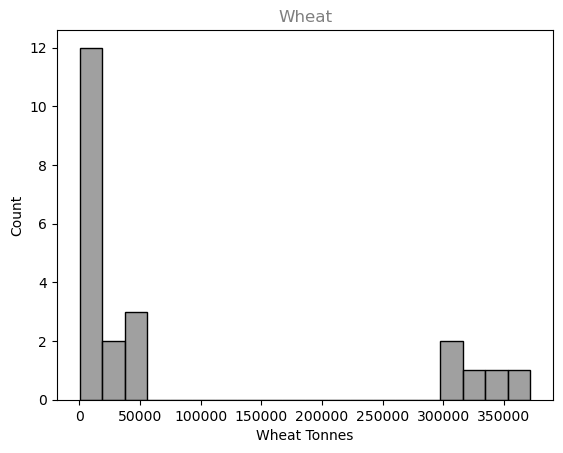

In [ ]:
wheat_tonnes = crop_wether_soils_fertiliser_w_df['Wheat Tonnes']

sns.histplot(data=wheat_tonnes, bins=20, kde=False, color='grey', edgecolor='black')
plt.title("Wheat", alpha=0.5)

For wheat yield following categories could be applied:
- low (less 100000)
- moderate(from 100001 to 350000)
- high (higher then 350001).

Add the category to the dataset 'crop_wether_soils_fertiliser_w_df'.

In [ ]:
category_wheat = pd.DataFrame({
    'Category': ['low', 'moderate', 'high'],
    'Range min': [0, 100001, 350001],
    'Range max': [100000, 350000, np.inf]
})
category_wheat

,Category,Range min,Range max
0,low,0,100000.0
1,moderate,100001,350000.0
2,high,350001,inf


In [ ]:
#generate the function to allocate  the category based on the crop yield
def categorize_tonnes(row, category_df):
    for _,category in category_df.iterrows():
        if category['Range min'] <= row <= category['Range max']:
            return category['Category']
    return np.nan

In [ ]:
crop_wether_soils_fertiliser_w_df['Category'] = crop_wether_soils_fertiliser_w_df['Wheat Tonnes'].apply(categorize_tonnes, args=(category_wheat,))
crop_wether_soils_fertiliser_w_df.head(5)

,Wheat Tonnes,Wheat Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value,Category
17,326300.0,42.4,42.4,63.8,35.0,44.2,15.4,46.4,25.2,59.0,...,1.8,2.3,1.7,2.0,2.4,134.0,0.8,6.7,0.52,moderate
18,372000.0,92.8,92.8,47.0,76.8,60.0,3.4,22.8,55.4,8.8,...,2.1,1.5,1.6,1.6,2.2,134.0,0.8,6.7,0.52,high
19,342000.0,54.4,54.4,32.6,61.4,89.0,68.8,11.6,16.2,10.2,...,2.3,2.1,1.6,1.5,2.4,134.0,0.8,6.7,0.52,moderate
20,313400.0,28.6,28.6,16.2,83.8,61.6,21.6,201.0,17.6,20.2,...,1.6,1.7,2.2,1.9,2.1,134.0,0.8,6.7,0.52,moderate
21,308300.0,81.6,81.6,62.6,38.2,32.6,89.8,67.6,70.8,36.2,...,1.5,1.7,1.3,2.4,2.0,134.0,0.8,6.7,0.52,moderate


In [ ]:
#barley

crop_wether_soils_fertiliser_b_df = data.drop(columns=['Wheat Tonnes',
 'Wheat Hectares',
'Maize grain Tonnes',
 'Maize grain Hectares',])

#remove all rows with zero values in 'Barley Tonnes' column
crop_wether_soils_fertiliser_b_df = crop_wether_soils_fertiliser_b_df.loc[crop_wether_soils_fertiliser_b_df['Barley Tonnes'] != 0]
crop_wether_soils_fertiliser_b_df.head(5)


,Barley Tonnes,Barley Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value
1,600.0,200.0,122.8,75.4,56.4,55.6,36.4,22.0,56.8,65.4,...,2.5,2.4,2.6,2.5,2.5,3.9,133.606236,0.976667,3.453214,0.32562
2,1000.0,200.0,43.4,33.0,96.6,25.6,8.4,12.4,27.2,24.8,...,2.9,2.8,2.6,3.0,3.0,3.2,133.606236,0.976667,3.453214,0.32562
3,2200.0,300.0,124.0,126.2,28.4,0.0,54.0,59.0,48.4,81.4,...,2.8,2.7,2.9,2.7,3.1,3.4,133.606236,0.976667,3.453214,0.32562
4,400.0,100.0,105.2,109.4,152.8,97.0,5.4,64.6,107.8,22.6,...,3.3,2.8,2.7,3.0,3.5,2.8,133.606236,0.976667,3.453214,0.32562
17,261900.0,36700.0,42.4,63.8,35.0,44.2,15.4,46.4,25.2,59.0,...,1.8,1.8,2.3,1.7,2.0,2.4,134.000000,0.800000,6.700000,0.52000


In [ ]:
#find zero values in column 'Barley Hectares'
zero_indices_b = crop_wether_soils_fertiliser_b_df[crop_wether_soils_fertiliser_b_df['Barley Hectares'] == 0]
zero_indices_b

,Barley Tonnes,Barley Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value
47,14200.0,0.0,90.2,98.0,71.6,51.4,186.2,174.8,66.8,109.6,...,2.9,2.4,2.6,2.7,4.0,2.9,78.50236,1.22,3.675442,0.36775


In [ ]:
#replace zero value
imputer = KNNImputer(n_neighbors=4)
crop_wether_soils_fertiliser_b_df['Barley Hectares'] = imputer.fit_transform(crop_wether_soils_fertiliser_b_df.drop(columns=['Barley Hectares']))[:, 1]
zero_indices_b_update = crop_wether_soils_fertiliser_b_df[crop_wether_soils_fertiliser_b_df['Barley Hectares'] == 0]
zero_indices_b_update

,Barley Tonnes,Barley Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value


Text(0.5, 1.0, 'Barley')

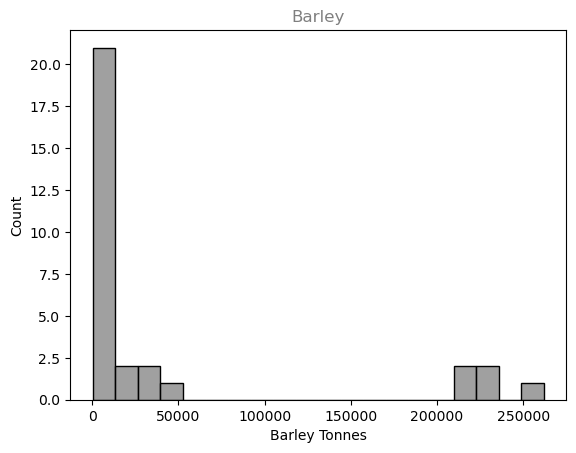

In [ ]:
barley_tonnes = crop_wether_soils_fertiliser_b_df['Barley Tonnes']

sns.histplot(data=barley_tonnes, bins=20, kde=False, color='grey', edgecolor='black')
plt.title("Barley", alpha=0.5)

For barley yioeld following categories could be applied:
- low (less 100000),
- moderate(from 100001 to 250000)
- high (higher then 250001).

In [ ]:
category_barley = pd.DataFrame({
    'Category': ['low', 'moderate', 'high'],
    'Range min': [0, 100001, 250001],
    'Range max': [100000, 250000, np.inf]
})
category_barley

,Category,Range min,Range max
0,low,0,100000.0
1,moderate,100001,250000.0
2,high,250001,inf


In [ ]:
crop_wether_soils_fertiliser_b_df['Category'] = crop_wether_soils_fertiliser_b_df['Barley Tonnes'].apply(categorize_tonnes, args=(category_barley,))
crop_wether_soils_fertiliser_b_df.head(5)

,Barley Tonnes,Barley Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value,Category
1,600.0,122.8,122.8,75.4,56.4,55.6,36.4,22.0,56.8,65.4,...,2.4,2.6,2.5,2.5,3.9,133.606236,0.976667,3.453214,0.32562,low
2,1000.0,43.4,43.4,33.0,96.6,25.6,8.4,12.4,27.2,24.8,...,2.8,2.6,3.0,3.0,3.2,133.606236,0.976667,3.453214,0.32562,low
3,2200.0,124.0,124.0,126.2,28.4,0.0,54.0,59.0,48.4,81.4,...,2.7,2.9,2.7,3.1,3.4,133.606236,0.976667,3.453214,0.32562,low
4,400.0,105.2,105.2,109.4,152.8,97.0,5.4,64.6,107.8,22.6,...,2.8,2.7,3.0,3.5,2.8,133.606236,0.976667,3.453214,0.32562,low
17,261900.0,42.4,42.4,63.8,35.0,44.2,15.4,46.4,25.2,59.0,...,1.8,2.3,1.7,2.0,2.4,134.000000,0.800000,6.700000,0.52000,high


In [ ]:
# maize
crop_wether_soils_fertiliser_m_df = data.drop(columns=['Barley Tonnes',
 'Barley Hectares',
'Wheat Tonnes',
 'Wheat Hectares',])

#remove all rows with zero values in 'Maize grain Tonnes' column
crop_wether_soils_fertiliser_m_df = crop_wether_soils_fertiliser_m_df.loc[crop_wether_soils_fertiliser_m_df['Maize grain Tonnes'] != 0]
crop_wether_soils_fertiliser_m_df.head(5)

,Maize grain Tonnes,Maize grain Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value
1,3400.0,300.0,122.8,75.4,56.4,55.6,36.4,22.0,56.8,65.4,...,2.5,2.4,2.6,2.5,2.5,3.9,133.606236,0.976667,3.453214,0.32562
2,2400.0,300.0,43.4,33.0,96.6,25.6,8.4,12.4,27.2,24.8,...,2.9,2.8,2.6,3.0,3.0,3.2,133.606236,0.976667,3.453214,0.32562
3,3800.0,300.0,124.0,126.2,28.4,0.0,54.0,59.0,48.4,81.4,...,2.8,2.7,2.9,2.7,3.1,3.4,133.606236,0.976667,3.453214,0.32562
4,8900.0,1000.0,105.2,109.4,152.8,97.0,5.4,64.6,107.8,22.6,...,3.3,2.8,2.7,3.0,3.5,2.8,133.606236,0.976667,3.453214,0.32562
5,5700.0,0.0,127.8,53.4,65.8,111.4,478.4,189.6,36.6,95.4,...,2.5,3.5,3.6,2.7,3.8,2.4,133.606236,0.976667,3.453214,0.32562


In [ ]:
#find zero values in column 'Barley Hectares'
zero_indices_m = crop_wether_soils_fertiliser_m_df[crop_wether_soils_fertiliser_m_df['Maize grain Hectares'] == 0]
zero_indices_m

,Maize grain Tonnes,Maize grain Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value
5,5700.0,0.0,127.8,53.4,65.8,111.4,478.4,189.6,36.6,95.4,...,2.5,3.5,3.6,2.7,3.8,2.4,133.606236,0.976667,3.453214,0.325620
85,300.0,0.0,177.4,224.4,84.8,329.2,86.0,100.8,190.4,79.4,...,2.9,2.6,3.2,2.7,3.4,3.2,125.099587,1.023333,5.785669,0.525917


In [ ]:
crop_wether_soils_fertiliser_m_df_imputed = crop_wether_soils_fertiliser_m_df.copy()
crop_wether_soils_fertiliser_m_df_imputed['Maize grain Hectares'].replace(0, np.nan, inplace=True)
imputer = KNNImputer(n_neighbors=4)

crop_wether_soils_fertiliser_m_df_imputed['Maize grain Hectares'] = imputer.fit_transform(crop_wether_soils_fertiliser_m_df_imputed[['Maize grain Hectares']])
crop_wether_soils_fertiliser_m_df['Maize grain Hectares'] = pd.DataFrame(crop_wether_soils_fertiliser_m_df_imputed['Maize grain Hectares'])

zero_indices_m_update = crop_wether_soils_fertiliser_m_df[crop_wether_soils_fertiliser_m_df['Maize grain Hectares'] == 0]
zero_indices_m_update

C:\Users\dress\AppData\Local\Temp\ipykernel_15612\216485389.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crop_wether_soils_fertiliser_m_df_imputed['Maize grain Hectares'].replace(0, np.nan, inplace=True)


,Maize grain Tonnes,Maize grain Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value


Text(0.5, 1.0, 'Maize')

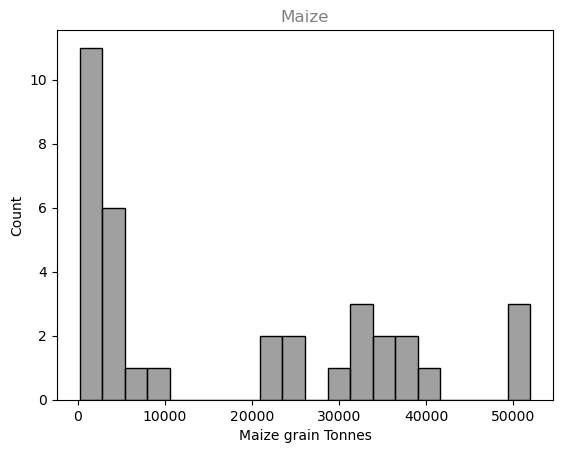

In [ ]:
maize_tonnes = crop_wether_soils_fertiliser_m_df['Maize grain Tonnes']

sns.histplot(data=maize_tonnes, bins=20, kde=False, color='grey', edgecolor='black')
plt.title("Maize", alpha=0.5)

The maize yield has diffrent categories. For maize yioeld following categories could be applied:
- low (less 10000),
- moderate(from 10001 to 30000)
- high (higher then 30000).

In [ ]:
category_maize = pd.DataFrame({
    'Category': ['low', 'moderate', 'high'],
    'Range min': [0, 10001, 30001],
    'Range max': [10000, 30000, np.inf]
})
category_maize

,Category,Range min,Range max
0,low,0,10000.0
1,moderate,10001,30000.0
2,high,30001,inf


In [ ]:
crop_wether_soils_fertiliser_m_df['Category'] = crop_wether_soils_fertiliser_m_df['Maize grain Tonnes'].apply(categorize_tonnes, args=(category_maize,))
crop_wether_soils_fertiliser_m_df.head(5)

,Maize grain Tonnes,Maize grain Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value,Category
1,3400.0,300.000000,122.8,75.4,56.4,55.6,36.4,22.0,56.8,65.4,...,2.4,2.6,2.5,2.5,3.9,133.606236,0.976667,3.453214,0.32562,low
2,2400.0,300.000000,43.4,33.0,96.6,25.6,8.4,12.4,27.2,24.8,...,2.8,2.6,3.0,3.0,3.2,133.606236,0.976667,3.453214,0.32562,low
3,3800.0,300.000000,124.0,126.2,28.4,0.0,54.0,59.0,48.4,81.4,...,2.7,2.9,2.7,3.1,3.4,133.606236,0.976667,3.453214,0.32562,low
4,8900.0,1000.000000,105.2,109.4,152.8,97.0,5.4,64.6,107.8,22.6,...,2.8,2.7,3.0,3.5,2.8,133.606236,0.976667,3.453214,0.32562,low
5,5700.0,1636.363636,127.8,53.4,65.8,111.4,478.4,189.6,36.6,95.4,...,3.5,3.6,2.7,3.8,2.4,133.606236,0.976667,3.453214,0.32562,low


Use the following classification models to predict the category of crop yield for wheat, barley, and maize grain:

- Random forest classifier
- Decision tree classifier
- Gaussian Naive Bayes classifier

In [ ]:
crop_wether_soils_fertiliser_w_df.columns

Index(['Wheat Tonnes', 'Wheat Hectares', 'September Total Rainfall (mm)',
       'October Total Rainfall (mm)', 'November Total Rainfall (mm)',
       'December Total Rainfall (mm)', 'January Total Rainfall (mm)',
       'February Total Rainfall (mm)', 'March Total Rainfall (mm)',
       'April Total Rainfall (mm)', 'May Total Rainfall (mm)',
       'June Total Rainfall (mm)', 'July Total Rainfall (mm)',
       'August Total Rainfall (mm)',
       'September Wet Day - 1mm or more of Rain (day)',
       'October Wet Day - 1mm or more of Rain (day)',
       'November Wet Day - 1mm or more of Rain (day)',
       'December Wet Day - 1mm or more of Rain (day)',
       'January Wet Day - 1mm or more of Rain (day)',
       'February Wet Day - 1mm or more of Rain (day)',
       'March Wet Day - 1mm or more of Rain (day)',
       'April Wet Day - 1mm or more of Rain (day)',
       'May Wet Day - 1mm or more of Rain (day)',
       'June Wet Day - 1mm or more of Rain (day)',
       'July Wet Day 

In [ ]:
#split the data on training and test datasets - wheat data:
from sklearn.model_selection import train_test_split
X_w = crop_wether_soils_fertiliser_w_df.drop(['Wheat Tonnes','Category'], axis=1)
y_w = crop_wether_soils_fertiliser_w_df['Category']

# Split the dataset
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.25, random_state=42) #rendom set =42 , because there is a small dataset

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

nb = GaussianNB()
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
print("Test accuracy for NB (no feature selection):", nb.fit(X_train_w, y_train_w).score(X_test_w, y_test_w))
print("Test accuracy for DT (no feature selection):", dt.fit(X_train_w, y_train_w).score(X_test_w, y_test_w))
print("Test accuracy for RF (no feature selection):", rf.fit(X_train_w, y_train_w).score(X_test_w, y_test_w))

Test accuracy for NB (no feature selection): 0.6666666666666666
Test accuracy for DT (no feature selection): 0.5
Test accuracy for RF (no feature selection): 0.6666666666666666


The accuracy of prediction for the rendom forest and Gaussian Naive Bayes classifier model is highest equal 0.83, compared to other model random forest - 0.7 and decision tree - 0.5.

Predict categories and compare them with the actual categories for wheat dataset applying Gaussian Naive Bayes classifier.

In [ ]:
# initialize and train the regressor
nb.fit(X_train_w, y_train_w)

GaussianNB()

In [ ]:
# create dataset with actual and predicted categories - wheat:
# predict and evaluate
y_pred_w = nb.predict(X_test_w)

# create dataset with actual and predicted values - wheat
results_wheat_df = pd.DataFrame({'Actual': y_test_w, 'Predicted': y_pred_w})
results_wheat_df['Crop_type'] = 'Wheat'
results_wheat_df

,Actual,Predicted,Crop_type
17,moderate,low,Wheat
54,low,low,Wheat
38,low,low,Wheat
18,high,moderate,Wheat
76,low,low,Wheat
35,low,low,Wheat


Run the same modelling with *barley* yield.

In [ ]:
#split the data on training and test datasets - barley data:
X_b = crop_wether_soils_fertiliser_b_df.drop(['Barley Tonnes','Category'], axis=1)
y_b = crop_wether_soils_fertiliser_b_df['Category']

# Split the dataset
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.25, random_state=42)
print("Test accuracy for NB (no feature selection):", nb.fit(X_train_b, y_train_b).score(X_test_b, y_test_b))
print("Test accuracy for DT (no feature selection):", dt.fit(X_train_b, y_train_b).score(X_test_b, y_test_b))
print("Test accuracy for RF (no feature selection):", rf.fit(X_train_b, y_train_b).score(X_test_b, y_test_b))

Test accuracy for NB (no feature selection): 0.875
Test accuracy for DT (no feature selection): 1.0
Test accuracy for RF (no feature selection): 1.0


Two models, such as Decision Tree Classifier and Random Forest Classifier, showed identical accuracy results - 1. This suggests that these models may be overfitting the data. However, the Gaussian Naive Bayes Classifier achieved an accuracy of 0.875. Therefore, it is recommended to apply this model.

Predict categories and compare them with actula categories.

In [ ]:
# create dataset with actual and predicted categories - barley:
# predict and evaluate
y_pred_b = nb.predict(X_test_b)

# create dataset with actual and predicted categories
results_barley_df = pd.DataFrame({'Actual': y_test_b, 'Predicted': y_pred_b})
results_barley_df['Crop_type'] = 'Barley'
results_barley_df

,Actual,Predicted,Crop_type
116,low,low,Barley
51,low,low,Barley
85,low,low,Barley
53,low,low,Barley
21,moderate,low,Barley
35,low,low,Barley
118,low,low,Barley
87,low,low,Barley


Rub the same process for *maize grain* yield.

In [ ]:
#split the data on training and test datasets - maize grain data:
X_m = crop_wether_soils_fertiliser_m_df.drop(['Maize grain Tonnes','Category'], axis=1)
y_m = crop_wether_soils_fertiliser_m_df['Category']

# Split the dataset
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.25, random_state=42) #rendom set =42 , because there is a small dataset

print("Test accuracy for NB (no feature selection):", nb.fit(X_train_m, y_train_m).score(X_test_m, y_test_m))
print("Test accuracy for DT (no feature selection):", dt.fit(X_train_m, y_train_m).score(X_test_m, y_test_m))
print("Test accuracy for RF (no feature selection):", rf.fit(X_train_m, y_train_m).score(X_test_m, y_test_m))

Test accuracy for NB (no feature selection): 0.5555555555555556
Test accuracy for DT (no feature selection): 0.7777777777777778
Test accuracy for RF (no feature selection): 0.8888888888888888


The Random forest classifier shows the best accuracy 0.88, while other two models Decision tree classifier and Gaussian Naive Bayes classifier shows accuracy 0.77 and 0.55 accordingly.

 Aply Random forest classifier to predict the categories for maize grain yield.

In [ ]:
# predict and evaluate
y_pred_m = rf.predict(X_test_m)

# create dataset with actual and predicted categories - maize grain
results_maize_df = pd.DataFrame({'Actual': y_test_m, 'Predicted': y_pred_m})
results_maize_df['Crop_type'] = 'Maize'
results_maize_df

,Actual,Predicted,Crop_type
93,low,low,Maize
36,high,high,Maize
91,low,low,Maize
53,low,low,Maize
38,high,high,Maize
114,high,high,Maize
51,low,low,Maize
35,high,high,Maize
12,moderate,high,Maize


## **C**

In [ ]:
#find if there are any missed values in column 'Wheat Hectares':
zero_values = crop_wether_soils_fertiliser_w_df[crop_wether_soils_fertiliser_w_df['Wheat Hectares'] == 0]
zero_values

,Wheat Tonnes,Wheat Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value
52,100.0,0.0,64.6,22.4,81.8,22.8,0.2,8.6,11.2,24.2,...,2.3,2.6,1.8,2.1,2.3,2.4,83.833333,1.307611,3.016667,0.370000
54,200.0,0.0,38.6,16.8,72.6,49.8,12.6,153.4,17.0,9.6,...,1.9,2.1,2.3,2.4,2.2,2.5,83.833333,1.307611,3.016667,0.370000
87,100.0,0.0,181.6,111.4,138.6,140.8,176.2,149.4,166.6,233.8,...,2.6,2.8,3.4,2.6,3.8,2.4,125.099587,1.023333,5.785669,0.525917


To replace the zero values in the 'Wheat Hectares' column with the mean value using kNN (k-nearest neighbors) with k = 4:

In [ ]:
imputer = KNNImputer(n_neighbors=4)
crop_wether_soils_fertiliser_w_df_imputed = crop_wether_soils_fertiliser_w_df.copy()  # Create a copy to avoid modifying the original DataFrame
crop_wether_soils_fertiliser_w_df_imputed['Wheat Hectares'] = imputer.fit_transform(crop_wether_soils_fertiliser_w_df_imputed.drop(columns=['Wheat Hectares']))[:, 1]
zero_values_w = crop_wether_soils_fertiliser_w_df_imputed[crop_wether_soils_fertiliser_w_df_imputed['Wheat Hectares'] == 0]
zero_values_w

,Wheat Tonnes,Wheat Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value


To avoid multicollinearity, add an extra column indicating the yield per hectare, calculated as the total tonnes obtained divided by the hectares cultivated.

In [ ]:
#add extra column
crop_wether_soils_fertiliser_w_df_imputed['yield_from_one_hect'] = crop_wether_soils_fertiliser_w_df_imputed['Wheat Tonnes'] /crop_wether_soils_fertiliser_w_df_imputed['Wheat Hectares']
crop_wether_soils_fertiliser_w_df_imputed = crop_wether_soils_fertiliser_w_df_imputed.drop(columns=['Wheat Tonnes', 'Wheat Hectares'])

crop_wether_soils_fertiliser_w_df_imputed.head(5)

,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),May Total Rainfall (mm),June Total Rainfall (mm),...,April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value,yield_from_one_hect
17,42.4,63.8,35.0,44.2,15.4,46.4,25.2,59.0,50.8,19.4,...,1.8,2.3,1.7,2.0,2.4,134.0,0.8,6.7,0.52,7695.754717
18,92.8,47.0,76.8,60.0,3.4,22.8,55.4,8.8,91.6,55.4,...,2.1,1.5,1.6,1.6,2.2,134.0,0.8,6.7,0.52,4008.620690
19,54.4,32.6,61.4,89.0,68.8,11.6,16.2,10.2,141.4,69.8,...,2.3,2.1,1.6,1.5,2.4,134.0,0.8,6.7,0.52,6286.764706
20,28.6,16.2,83.8,61.6,21.6,201.0,17.6,20.2,80.0,89.6,...,1.6,1.7,2.2,1.9,2.1,134.0,0.8,6.7,0.52,10958.041958
21,81.6,62.6,38.2,32.6,89.8,67.6,70.8,36.2,20.0,40.2,...,1.5,1.7,1.3,2.4,2.0,134.0,0.8,6.7,0.52,3778.186275


Generate the column of classification. Initally to find  ranges for wheat, barley and maize grain.

Text(0.5, 1.0, 'Wheat')

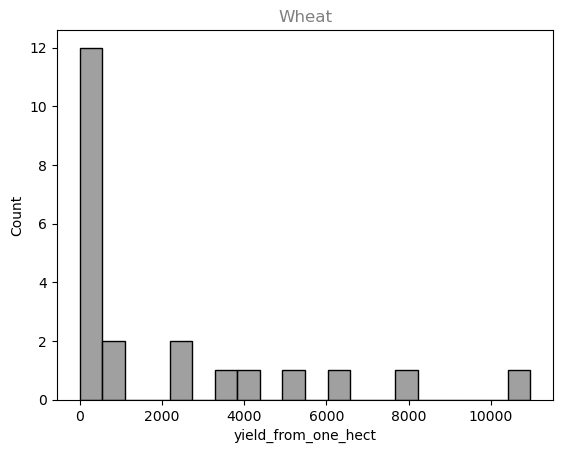

In [ ]:
wheat_tonnes_from_hect = crop_wether_soils_fertiliser_w_df_imputed['yield_from_one_hect']

sns.histplot(data=wheat_tonnes_from_hect, bins=20, kde=False, color='grey', edgecolor='black')
plt.title("Wheat", alpha=0.5)

For wheat yield following categories could be applied:
- low (less 2000),
- moderate(from 2001 to 8000),
- high (higher then 8001).
Add the category to the dataset 'crop_wether_soils_fertiliser_w_df_imputed'.

In [ ]:
category_wheat = pd.DataFrame({
    'Category': ['low', 'moderate', 'high'],
    'Range min': [0, 2001, 8001],
    'Range max': [2000, 8000, np.inf]
})
category_wheat

,Category,Range min,Range max
0,low,0,2000.0
1,moderate,2001,8000.0
2,high,8001,inf


In [ ]:
#genearete function to add ranges to the main dataset
def categorize_tonnes(row, category_df):
    for _,category in category_df.iterrows():
        if category['Range min'] <= row <= category['Range max']:
            return category['Category']
    return np.nan


crop_wether_soils_fertiliser_w_df_imputed['Category'] = crop_wether_soils_fertiliser_w_df_imputed['yield_from_one_hect'].apply(categorize_tonnes, args=(category_wheat,))
crop_wether_soils_fertiliser_w_df_imputed.head(10)

,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),May Total Rainfall (mm),June Total Rainfall (mm),...,May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value,yield_from_one_hect,Category
17,42.4,63.8,35.0,44.2,15.4,46.4,25.2,59.0,50.8,19.4,...,2.3,1.7,2.0,2.4,134.00000,0.800000,6.700000,0.52000,7695.754717,moderate
18,92.8,47.0,76.8,60.0,3.4,22.8,55.4,8.8,91.6,55.4,...,1.5,1.6,1.6,2.2,134.00000,0.800000,6.700000,0.52000,4008.620690,moderate
19,54.4,32.6,61.4,89.0,68.8,11.6,16.2,10.2,141.4,69.8,...,2.1,1.6,1.5,2.4,134.00000,0.800000,6.700000,0.52000,6286.764706,moderate
20,28.6,16.2,83.8,61.6,21.6,201.0,17.6,20.2,80.0,89.6,...,1.7,2.2,1.9,2.1,134.00000,0.800000,6.700000,0.52000,10958.041958,high
21,81.6,62.6,38.2,32.6,89.8,67.6,70.8,36.2,20.0,40.2,...,1.7,1.3,2.4,2.0,134.00000,0.800000,6.700000,0.52000,3778.186275,moderate
35,58.2,91.6,40.0,133.6,42.7,71.9,45.2,0.0,1.0,0.0,...,3.3,2.9,3.0,4.3,122.00000,0.903374,4.000000,0.42000,68.728522,low
36,97.4,85.2,164.4,54.8,66.6,34.8,77.8,19.6,56.4,208.8,...,2.2,2.7,3.2,3.2,122.00000,0.903374,4.000000,0.42000,48.254620,low
37,150.2,37.0,156.2,86.8,35.6,62.6,0.0,1.4,0.0,65.4,...,2.6,2.9,2.8,3.3,122.00000,0.903374,4.000000,0.42000,17.310253,low
38,167.0,0.0,96.4,74.2,24.2,170.6,404.6,112.6,144.6,89.6,...,2.9,3.6,3.7,2.9,122.00000,0.903374,4.000000,0.42000,21.556886,low
46,145.6,68.2,98.8,91.2,4.0,211.6,108.4,12.2,118.6,155.8,...,2.9,3.6,3.7,2.9,78.50236,1.220000,3.675442,0.36775,17.857143,low


In [ ]:
#prepare data for barley
crop_wether_soils_fertiliser_b_df = data.drop(columns=['Wheat Tonnes',
 'Wheat Hectares',
'Maize grain Tonnes',
 'Maize grain Hectares',])

#remove all rows with zero values in 'Barley Tonnes' column
crop_wether_soils_fertiliser_b_df = crop_wether_soils_fertiliser_b_df.loc[crop_wether_soils_fertiliser_b_df['Barley Tonnes'] != 0]
crop_wether_soils_fertiliser_b_df.head(5)

,Barley Tonnes,Barley Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value
1,600.0,200.0,122.8,75.4,56.4,55.6,36.4,22.0,56.8,65.4,...,2.5,2.4,2.6,2.5,2.5,3.9,133.606236,0.976667,3.453214,0.32562
2,1000.0,200.0,43.4,33.0,96.6,25.6,8.4,12.4,27.2,24.8,...,2.9,2.8,2.6,3.0,3.0,3.2,133.606236,0.976667,3.453214,0.32562
3,2200.0,300.0,124.0,126.2,28.4,0.0,54.0,59.0,48.4,81.4,...,2.8,2.7,2.9,2.7,3.1,3.4,133.606236,0.976667,3.453214,0.32562
4,400.0,100.0,105.2,109.4,152.8,97.0,5.4,64.6,107.8,22.6,...,3.3,2.8,2.7,3.0,3.5,2.8,133.606236,0.976667,3.453214,0.32562
17,261900.0,36700.0,42.4,63.8,35.0,44.2,15.4,46.4,25.2,59.0,...,1.8,1.8,2.3,1.7,2.0,2.4,134.000000,0.800000,6.700000,0.52000


In [ ]:
#find if there are any missed values in column 'Barley Hectares':
zero_values_b = crop_wether_soils_fertiliser_b_df[crop_wether_soils_fertiliser_b_df['Barley Hectares'] == 0]
zero_values_b

,Barley Tonnes,Barley Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value
47,14200.0,0.0,90.2,98.0,71.6,51.4,186.2,174.8,66.8,109.6,...,2.9,2.4,2.6,2.7,4.0,2.9,78.50236,1.22,3.675442,0.36775


To replace the zero values in the 'Barley Hectares' column with the mean value using kNN (k-nearest neighbors) with k = 4:

In [ ]:
imputer = KNNImputer(n_neighbors=4)
crop_wether_soils_fertiliser_b_df_imputed = crop_wether_soils_fertiliser_b_df.copy()  # Create a copy to avoid modifying the original DataFrame
crop_wether_soils_fertiliser_b_df_imputed['Barley Hectares'] = imputer.fit_transform(crop_wether_soils_fertiliser_b_df_imputed.drop(columns=['Barley Hectares']))[:, 1]
zero_values_b = crop_wether_soils_fertiliser_b_df_imputed[crop_wether_soils_fertiliser_b_df_imputed['Barley Hectares'] == 0]
zero_values_b

,Barley Tonnes,Barley Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value


In [ ]:
#add extra column
crop_wether_soils_fertiliser_b_df_imputed['yield_from_one_hect'] = crop_wether_soils_fertiliser_b_df_imputed['Barley Tonnes'] /crop_wether_soils_fertiliser_b_df_imputed['Barley Hectares']
crop_wether_soils_fertiliser_b_df_imputed = crop_wether_soils_fertiliser_b_df_imputed.drop(columns=['Barley Tonnes', 'Barley Hectares'])

crop_wether_soils_fertiliser_b_df_imputed

,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),May Total Rainfall (mm),June Total Rainfall (mm),...,April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value,yield_from_one_hect
1,122.8,75.4,56.4,55.6,36.4,22.0,56.8,65.4,55.6,65.6,...,2.4,2.6,2.5,2.5,3.9,133.606236,0.976667,3.453214,0.325620,4.885993
2,43.4,33.0,96.6,25.6,8.4,12.4,27.2,24.8,97.8,139.6,...,2.8,2.6,3.0,3.0,3.2,133.606236,0.976667,3.453214,0.325620,23.041475
3,124.0,126.2,28.4,0.0,54.0,59.0,48.4,81.4,54.8,93.4,...,2.7,2.9,2.7,3.1,3.4,133.606236,0.976667,3.453214,0.325620,17.741935
4,105.2,109.4,152.8,97.0,5.4,64.6,107.8,22.6,68.8,148.2,...,2.8,2.7,3.0,3.5,2.8,133.606236,0.976667,3.453214,0.325620,3.802281
17,42.4,63.8,35.0,44.2,15.4,46.4,25.2,59.0,50.8,19.4,...,1.8,2.3,1.7,2.0,2.4,134.000000,0.800000,6.700000,0.520000,6176.886792
18,92.8,47.0,76.8,60.0,3.4,22.8,55.4,8.8,91.6,55.4,...,2.1,1.5,1.6,1.6,2.2,134.000000,0.800000,6.700000,0.520000,2446.120690
19,54.4,32.6,61.4,89.0,68.8,11.6,16.2,10.2,141.4,69.8,...,2.3,2.1,1.6,1.5,2.4,134.000000,0.800000,6.700000,0.520000,3898.897059
20,28.6,16.2,83.8,61.6,21.6,201.0,17.6,20.2,80.0,89.6,...,1.6,1.7,2.2,1.9,2.1,134.000000,0.800000,6.700000,0.520000,7527.972028
21,81.6,62.6,38.2,32.6,89.8,67.6,70.8,36.2,20.0,40.2,...,1.5,1.7,1.3,2.4,2.0,134.000000,0.800000,6.700000,0.520000,2802.696078
35,58.2,91.6,40.0,133.6,42.7,71.9,45.2,0.0,1.0,0.0,...,2.5,3.3,2.9,3.0,4.3,122.000000,0.903374,4.000000,0.420000,154.639175


Text(0.5, 1.0, 'Barley')

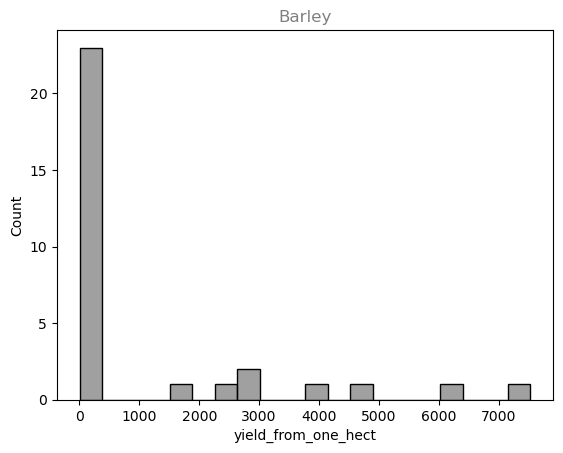

In [ ]:
barley_tonnes_for_hect = crop_wether_soils_fertiliser_b_df_imputed['yield_from_one_hect']

sns.histplot(data=barley_tonnes_for_hect, bins=20, kde=False, color='grey', edgecolor='black')
plt.title("Barley", alpha=0.5)

For barley yield following categories could be applied:
- low (less 2000),
- moderate(from 2001 to 6000),
- high (higher then 6001).
  
Add the category to the dataset 'crop_wether_soils_fertiliser_b_df_imputed'.

In [ ]:
category_barley = pd.DataFrame({
    'Category': ['low', 'moderate', 'high'],
    'Range min': [0, 2001, 6001],
    'Range max': [2000, 6000, np.inf]
})
category_barley

,Category,Range min,Range max
0,low,0,2000.0
1,moderate,2001,6000.0
2,high,6001,inf


In [ ]:
crop_wether_soils_fertiliser_b_df_imputed['Category'] = crop_wether_soils_fertiliser_b_df_imputed['yield_from_one_hect'].apply(categorize_tonnes, args=(category_barley,))
crop_wether_soils_fertiliser_b_df_imputed.head(5)

,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),May Total Rainfall (mm),June Total Rainfall (mm),...,May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value,yield_from_one_hect,Category
1,122.8,75.4,56.4,55.6,36.4,22.0,56.8,65.4,55.6,65.6,...,2.6,2.5,2.5,3.9,133.606236,0.976667,3.453214,0.32562,4.885993,low
2,43.4,33.0,96.6,25.6,8.4,12.4,27.2,24.8,97.8,139.6,...,2.6,3.0,3.0,3.2,133.606236,0.976667,3.453214,0.32562,23.041475,low
3,124.0,126.2,28.4,0.0,54.0,59.0,48.4,81.4,54.8,93.4,...,2.9,2.7,3.1,3.4,133.606236,0.976667,3.453214,0.32562,17.741935,low
4,105.2,109.4,152.8,97.0,5.4,64.6,107.8,22.6,68.8,148.2,...,2.7,3.0,3.5,2.8,133.606236,0.976667,3.453214,0.32562,3.802281,low
17,42.4,63.8,35.0,44.2,15.4,46.4,25.2,59.0,50.8,19.4,...,2.3,1.7,2.0,2.4,134.000000,0.800000,6.700000,0.52000,6176.886792,high


In [ ]:
#prepare data for maize
crop_wether_soils_fertiliser_m_df = data.drop(columns=['Barley Tonnes',
 'Barley Hectares',
'Wheat Tonnes',
 'Wheat Hectares',])

#remove all rows with zero values in 'Maize grain Tonnes' column
crop_wether_soils_fertiliser_m_df = crop_wether_soils_fertiliser_m_df.loc[crop_wether_soils_fertiliser_m_df['Maize grain Tonnes'] != 0]
crop_wether_soils_fertiliser_m_df.head(5)

,Maize grain Tonnes,Maize grain Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value
1,3400.0,300.0,122.8,75.4,56.4,55.6,36.4,22.0,56.8,65.4,...,2.5,2.4,2.6,2.5,2.5,3.9,133.606236,0.976667,3.453214,0.32562
2,2400.0,300.0,43.4,33.0,96.6,25.6,8.4,12.4,27.2,24.8,...,2.9,2.8,2.6,3.0,3.0,3.2,133.606236,0.976667,3.453214,0.32562
3,3800.0,300.0,124.0,126.2,28.4,0.0,54.0,59.0,48.4,81.4,...,2.8,2.7,2.9,2.7,3.1,3.4,133.606236,0.976667,3.453214,0.32562
4,8900.0,1000.0,105.2,109.4,152.8,97.0,5.4,64.6,107.8,22.6,...,3.3,2.8,2.7,3.0,3.5,2.8,133.606236,0.976667,3.453214,0.32562
5,5700.0,0.0,127.8,53.4,65.8,111.4,478.4,189.6,36.6,95.4,...,2.5,3.5,3.6,2.7,3.8,2.4,133.606236,0.976667,3.453214,0.32562


In [ ]:
#find if there are any missed values in column 'Barley Hectares':
zero_values_m = crop_wether_soils_fertiliser_m_df[crop_wether_soils_fertiliser_m_df['Maize grain Hectares'] == 0]
zero_values_m

,Maize grain Tonnes,Maize grain Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value
5,5700.0,0.0,127.8,53.4,65.8,111.4,478.4,189.6,36.6,95.4,...,2.5,3.5,3.6,2.7,3.8,2.4,133.606236,0.976667,3.453214,0.325620
85,300.0,0.0,177.4,224.4,84.8,329.2,86.0,100.8,190.4,79.4,...,2.9,2.6,3.2,2.7,3.4,3.2,125.099587,1.023333,5.785669,0.525917


In [ ]:
imputer = KNNImputer(n_neighbors=4)
crop_wether_soils_fertiliser_m_df_imputed = crop_wether_soils_fertiliser_m_df.copy() # Create a copy to avoid modifying the original DataFrame

crop_wether_soils_fertiliser_m_df_imputed['Maize grain Hectares'] = imputer.fit_transform(crop_wether_soils_fertiliser_m_df_imputed.drop(columns=['Maize grain Hectares']))[:, 1]
crop_wether_soils_fertiliser_m_df_imputed

,Maize grain Tonnes,Maize grain Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value
1,3400.0,122.8,122.8,75.4,56.4,55.6,36.4,22.0,56.8,65.4,...,2.5,2.4,2.6,2.5,2.5,3.9,133.606236,0.976667,3.453214,0.325620
2,2400.0,43.4,43.4,33.0,96.6,25.6,8.4,12.4,27.2,24.8,...,2.9,2.8,2.6,3.0,3.0,3.2,133.606236,0.976667,3.453214,0.325620
3,3800.0,124.0,124.0,126.2,28.4,0.0,54.0,59.0,48.4,81.4,...,2.8,2.7,2.9,2.7,3.1,3.4,133.606236,0.976667,3.453214,0.325620
4,8900.0,105.2,105.2,109.4,152.8,97.0,5.4,64.6,107.8,22.6,...,3.3,2.8,2.7,3.0,3.5,2.8,133.606236,0.976667,3.453214,0.325620
5,5700.0,127.8,127.8,53.4,65.8,111.4,478.4,189.6,36.6,95.4,...,2.5,3.5,3.6,2.7,3.8,2.4,133.606236,0.976667,3.453214,0.325620
9,29200.0,95.8,95.8,95.4,46.4,99.4,24.6,29.0,0.0,0.0,...,2.6,2.6,2.7,2.3,3.0,3.5,156.939209,0.971667,4.744962,0.488482
10,33700.0,32.6,32.6,25.0,0.0,33.4,16.8,16.8,56.4,41.2,...,2.8,2.6,2.4,2.7,2.8,3.1,156.939209,0.971667,4.744962,0.488482
11,36100.0,128.8,128.8,187.4,25.6,124.8,132.8,71.8,55.2,87.2,...,2.9,2.6,2.5,2.8,3.1,2.8,156.939209,0.971667,4.744962,0.488482
12,21700.0,224.0,224.0,102.0,206.0,192.6,36.4,173.4,151.6,35.2,...,3.9,3.3,3.2,4.1,4.4,3.5,156.939209,0.971667,4.744962,0.488482
13,23100.0,286.8,286.8,0.0,75.0,0.0,168.8,199.2,0.0,62.2,...,3.3,3.8,5.2,3.7,4.0,3.4,156.939209,0.971667,4.744962,0.488482


In [ ]:
crop_wether_soils_fertiliser_m_df_imputed = crop_wether_soils_fertiliser_m_df.copy()
crop_wether_soils_fertiliser_m_df_imputed['Maize grain Hectares'].replace(0, np.nan, inplace=True)
imputer = KNNImputer(n_neighbors=4)
imputed_data = imputer.fit_transform(crop_wether_soils_fertiliser_m_df_imputed)
crop_wether_soils_fertiliser_m_df_imputed = pd.DataFrame(imputed_data, columns=crop_wether_soils_fertiliser_m_df.columns)
zero_values_m = crop_wether_soils_fertiliser_m_df_imputed[crop_wether_soils_fertiliser_m_df_imputed['Maize grain Hectares'] == 0]
zero_values_m

C:\Users\dress\AppData\Local\Temp\ipykernel_15612\3033066930.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crop_wether_soils_fertiliser_m_df_imputed['Maize grain Hectares'].replace(0, np.nan, inplace=True)


,Maize grain Tonnes,Maize grain Hectares,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),...,March Mean Wind Speed (M/Sec),April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value


In [ ]:
#add extra column
crop_wether_soils_fertiliser_m_df_imputed['yield_from_one_hect'] = crop_wether_soils_fertiliser_m_df_imputed['Maize grain Tonnes'] /crop_wether_soils_fertiliser_m_df_imputed['Maize grain Hectares']
crop_wether_soils_fertiliser_m_df_imputed = crop_wether_soils_fertiliser_m_df_imputed.drop(columns=['Maize grain Tonnes', 'Maize grain Hectares'])

crop_wether_soils_fertiliser_m_df_imputed.head(5)

,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),May Total Rainfall (mm),June Total Rainfall (mm),...,April Mean Wind Speed (M/Sec),May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value,yield_from_one_hect
0,122.8,75.4,56.4,55.6,36.4,22.0,56.8,65.4,55.6,65.6,...,2.4,2.6,2.5,2.5,3.9,133.606236,0.976667,3.453214,0.32562,11.333333
1,43.4,33.0,96.6,25.6,8.4,12.4,27.2,24.8,97.8,139.6,...,2.8,2.6,3.0,3.0,3.2,133.606236,0.976667,3.453214,0.32562,8.000000
2,124.0,126.2,28.4,0.0,54.0,59.0,48.4,81.4,54.8,93.4,...,2.7,2.9,2.7,3.1,3.4,133.606236,0.976667,3.453214,0.32562,12.666667
3,105.2,109.4,152.8,97.0,5.4,64.6,107.8,22.6,68.8,148.2,...,2.8,2.7,3.0,3.5,2.8,133.606236,0.976667,3.453214,0.32562,8.900000
4,127.8,53.4,65.8,111.4,478.4,189.6,36.6,95.4,232.0,119.2,...,3.5,3.6,2.7,3.8,2.4,133.606236,0.976667,3.453214,0.32562,16.285714


Text(0.5, 1.0, 'Maize')

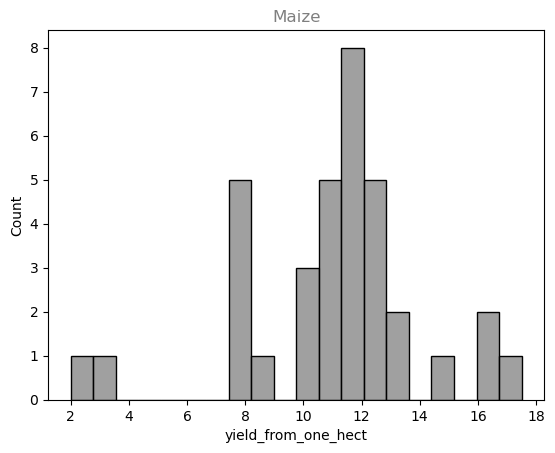

In [ ]:
#generate the plot
maize_tonnes = crop_wether_soils_fertiliser_m_df_imputed['yield_from_one_hect']

sns.histplot(data=maize_tonnes, bins=20, kde=False, color='grey', edgecolor='black')
plt.title("Maize", alpha=0.5)

For maize grain yield following categories could be applied:

    low (less 6),
    moderate(from 6.1 to 12),
    high (higher then 12.1).
    
    Add the category to the dataset 'crop_wether_soils_fertiliser_m_df_imputed'.



In [ ]:
category_maize = pd.DataFrame({
    'Category': ['low', 'moderate', 'high'],
    'Range min': [0, 6.1, 12.1],
    'Range max': [6, 12, np.inf]
})
category_maize

,Category,Range min,Range max
0,low,0.0,6.0
1,moderate,6.1,12.0
2,high,12.1,inf


In [ ]:
crop_wether_soils_fertiliser_m_df_imputed['Category'] = crop_wether_soils_fertiliser_m_df_imputed['yield_from_one_hect'].apply(categorize_tonnes, args=(category_maize,))
crop_wether_soils_fertiliser_m_df_imputed.head(5)

,September Total Rainfall (mm),October Total Rainfall (mm),November Total Rainfall (mm),December Total Rainfall (mm),January Total Rainfall (mm),February Total Rainfall (mm),March Total Rainfall (mm),April Total Rainfall (mm),May Total Rainfall (mm),June Total Rainfall (mm),...,May Mean Wind Speed (M/Sec),June Mean Wind Speed (M/Sec),July Mean Wind Speed (M/Sec),August Mean Wind Speed (M/Sec),AMN_value,Bulk_density_value,TotalC_value,TotalN_value,yield_from_one_hect,Category
0,122.8,75.4,56.4,55.6,36.4,22.0,56.8,65.4,55.6,65.6,...,2.6,2.5,2.5,3.9,133.606236,0.976667,3.453214,0.32562,11.333333,moderate
1,43.4,33.0,96.6,25.6,8.4,12.4,27.2,24.8,97.8,139.6,...,2.6,3.0,3.0,3.2,133.606236,0.976667,3.453214,0.32562,8.000000,moderate
2,124.0,126.2,28.4,0.0,54.0,59.0,48.4,81.4,54.8,93.4,...,2.9,2.7,3.1,3.4,133.606236,0.976667,3.453214,0.32562,12.666667,high
3,105.2,109.4,152.8,97.0,5.4,64.6,107.8,22.6,68.8,148.2,...,2.7,3.0,3.5,2.8,133.606236,0.976667,3.453214,0.32562,8.900000,moderate
4,127.8,53.4,65.8,111.4,478.4,189.6,36.6,95.4,232.0,119.2,...,3.6,2.7,3.8,2.4,133.606236,0.976667,3.453214,0.32562,16.285714,high


Use the following classification models to predict the category of crop yield for wheat, barley, and maize grain:

- Random forest classifier
- Decision tree classifier
- Gaussian Naive Bayes classifier

In [ ]:
crop_wether_soils_fertiliser_w_df_imputed.columns

Index(['September Total Rainfall (mm)', 'October Total Rainfall (mm)',
       'November Total Rainfall (mm)', 'December Total Rainfall (mm)',
       'January Total Rainfall (mm)', 'February Total Rainfall (mm)',
       'March Total Rainfall (mm)', 'April Total Rainfall (mm)',
       'May Total Rainfall (mm)', 'June Total Rainfall (mm)',
       'July Total Rainfall (mm)', 'August Total Rainfall (mm)',
       'September Wet Day - 1mm or more of Rain (day)',
       'October Wet Day - 1mm or more of Rain (day)',
       'November Wet Day - 1mm or more of Rain (day)',
       'December Wet Day - 1mm or more of Rain (day)',
       'January Wet Day - 1mm or more of Rain (day)',
       'February Wet Day - 1mm or more of Rain (day)',
       'March Wet Day - 1mm or more of Rain (day)',
       'April Wet Day - 1mm or more of Rain (day)',
       'May Wet Day - 1mm or more of Rain (day)',
       'June Wet Day - 1mm or more of Rain (day)',
       'July Wet Day - 1mm or more of Rain (day)',
       'Aug

In [ ]:
#split the data on training and test datasets - wheat data:
from sklearn.model_selection import train_test_split
X_w = crop_wether_soils_fertiliser_w_df_imputed.drop(['yield_from_one_hect','Category'], axis=1)
y_w = crop_wether_soils_fertiliser_w_df_imputed['Category']

# Split the dataset
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.25, random_state=42) #rendom set =42 , because there is a small dataset

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

nb = GaussianNB()
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
print("Test accuracy for NB (no feature selection):", nb.fit(X_train_w, y_train_w).score(X_test_w, y_test_w))
print("Test accuracy for DT (no feature selection):", dt.fit(X_train_w, y_train_w).score(X_test_w, y_test_w))
print("Test accuracy for RF (no feature selection):", rf.fit(X_train_w, y_train_w).score(X_test_w, y_test_w))

Test accuracy for NB (no feature selection): 0.6666666666666666
Test accuracy for DT (no feature selection): 0.5
Test accuracy for RF (no feature selection): 0.5


The accuracy of prediction for the rendom forest and  decision tree classifier models is lowest and  equal 0.5, compared to other model Gaussian Naive Bayes - 0.7. it means that the model in 70% of situations makes the accurate prediction.

Predict categories and compare them with the actual categories for wheat dataset applying Gaussian Naive Bayes classifier.

In [ ]:
# initialize and train the regressor
nb.fit(X_train_w, y_train_w)

GaussianNB()

In [ ]:
# create dataset with actual and predicted categories - wheat:
# predict and evaluate
y_pred_w = nb.predict(X_test_w)

# create dataset with actual and predicted values - wheat
results_wheat_df = pd.DataFrame({'Actual': y_test_w, 'Predicted': y_pred_w})
results_wheat_df['Crop_type'] = 'Wheat'
results_wheat_df

,Actual,Predicted,Crop_type
17,moderate,low,Wheat
54,low,low,Wheat
38,low,low,Wheat
18,moderate,low,Wheat
76,moderate,moderate,Wheat
35,low,low,Wheat


Run the same modelling with *barley* yield.

In [ ]:
#split the data on training and test datasets - barley data:
X_b = crop_wether_soils_fertiliser_b_df_imputed.drop(['yield_from_one_hect','Category'], axis=1)
y_b = crop_wether_soils_fertiliser_b_df_imputed['Category']

# Split the dataset
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.25, random_state=42)

nb = GaussianNB()
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

print("Test accuracy for NB (no feature selection):", nb.fit(X_train_b, y_train_b).score(X_test_b, y_test_b))
print("Test accuracy for DT (no feature selection):", dt.fit(X_train_b, y_train_b).score(X_test_b, y_test_b))
print("Test accuracy for RF (no feature selection):", rf.fit(X_train_b, y_train_b).score(X_test_b, y_test_b))

Test accuracy for NB (no feature selection): 1.0
Test accuracy for DT (no feature selection): 0.75
Test accuracy for RF (no feature selection): 1.0


The accuracy of barley yield prediction using Random Forest classifier and Gaussian Naive Bayes classifier is reported as 100%. However, this high accuracy suggests that the models may be overfitting. Apply random_state=1:

In [ ]:
#split the data on training and test datasets - barley data:
X_b = crop_wether_soils_fertiliser_b_df_imputed.drop(['yield_from_one_hect','Category'], axis=1)
y_b = crop_wether_soils_fertiliser_b_df_imputed['Category']

# Split the dataset
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.25, random_state=1)

nb = GaussianNB()
dt = DecisionTreeClassifier(max_depth=3, random_state=1)
rf = RandomForestClassifier(n_estimators=100, random_state=1)

print("Test accuracy for NB (no feature selection):", nb.fit(X_train_b, y_train_b).score(X_test_b, y_test_b))
print("Test accuracy for DT (no feature selection):", dt.fit(X_train_b, y_train_b).score(X_test_b, y_test_b))
print("Test accuracy for RF (no feature selection):", rf.fit(X_train_b, y_train_b).score(X_test_b, y_test_b))

Test accuracy for NB (no feature selection): 0.75
Test accuracy for DT (no feature selection): 0.75
Test accuracy for RF (no feature selection): 0.75


Applying random_state=1, it gives the equal aquary for all methods 0.75.

Predict categories and compare them with actula categories, applying decision tree classifier.

In [ ]:
# create dataset with actual and predicted categories - barley:
# predict and evaluate
y_pred_b = dt.predict(X_test_b)

# create dataset with actual and predicted categories
results_barley_df = pd.DataFrame({'Actual': y_test_b, 'Predicted': y_pred_b})
results_barley_df['Crop_type'] = 'Barley'
results_barley_df

,Actual,Predicted,Crop_type
116,low,low,Barley
4,low,low,Barley
75,moderate,high,Barley
85,low,low,Barley
83,low,low,Barley
78,moderate,moderate,Barley
76,low,high,Barley
54,low,low,Barley


In [ ]:
#split the data on training and test datasets - maize grain data:
X_m = crop_wether_soils_fertiliser_m_df_imputed.drop(['yield_from_one_hect','Category'], axis=1)
y_m = crop_wether_soils_fertiliser_m_df_imputed['Category']

# Split the dataset
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.25, random_state=42) #rendom set =42 , because there is a small dataset

nb = GaussianNB()
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
print("Test accuracy for NB (no feature selection):", nb.fit(X_train_m, y_train_m).score(X_test_m, y_test_m))
print("Test accuracy for DT (no feature selection):", dt.fit(X_train_m, y_train_m).score(X_test_m, y_test_m))
print("Test accuracy for RF (no feature selection):", rf.fit(X_train_m, y_train_m).score(X_test_m, y_test_m))

Test accuracy for NB (no feature selection): 0.14285714285714285
Test accuracy for DT (no feature selection): 0.14285714285714285
Test accuracy for RF (no feature selection): 0.14285714285714285


## Clustering


Using clustering to enhance the data to improve the prediction model performance.

In [ ]:
### Clustering Data for Wheat

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

columns = ['Wheat Tonnes',
 'Wheat Hectares',
 'September Total Rainfall (mm)',
 'October Total Rainfall (mm)',
 'November Total Rainfall (mm)',
 'December Total Rainfall (mm)',
 'January Total Rainfall (mm)',
 'February Total Rainfall (mm)',
 'March Total Rainfall (mm)',
 'April Total Rainfall (mm)',
 'May Total Rainfall (mm)',
 'June Total Rainfall (mm)',
 'July Total Rainfall (mm)',
 'August Total Rainfall (mm)',
 'September Wet Day - 1mm or more of Rain (day)',
 'October Wet Day - 1mm or more of Rain (day)',
 'November Wet Day - 1mm or more of Rain (day)',
 'December Wet Day - 1mm or more of Rain (day)',
 'January Wet Day - 1mm or more of Rain (day)',
 'February Wet Day - 1mm or more of Rain (day)',
 'March Wet Day - 1mm or more of Rain (day)',
 'April Wet Day - 1mm or more of Rain (day)',
 'May Wet Day - 1mm or more of Rain (day)',
 'June Wet Day - 1mm or more of Rain (day)',
 'July Wet Day - 1mm or more of Rain (day)',
 'August Wet Day - 1mm or more of Rain (day)',
 'September Mean Air Temperature (Celsius)',
 'October Mean Air Temperature (Celsius)',
 'November Mean Air Temperature (Celsius)',
 'December Mean Air Temperature (Celsius)',
 'January Mean Air Temperature (Celsius)',
 'February Mean Air Temperature (Celsius)',
 'March Mean Air Temperature (Celsius)',
 'April Mean Air Temperature (Celsius)',
 'May Mean Air Temperature (Celsius)',
 'June Mean Air Temperature (Celsius)',
 'July Mean Air Temperature (Celsius)',
 'August Mean Air Temperature (Celsius)',
 'September Total Sunshine (hrs)',
 'October Total Sunshine (hrs)',
 'November Total Sunshine (hrs)',
 'December Total Sunshine (hrs)',
 'January Total Sunshine (hrs)',
 'February Total Sunshine (hrs)',
 'March Total Sunshine (hrs)',
 'April Total Sunshine (hrs)',
 'May Total Sunshine (hrs)',
 'June Total Sunshine (hrs)',
 'July Total Sunshine (hrs)',
 'August Total Sunshine (hrs)',
 'September Mean Wind Speed (M/Sec)',
 'October Mean Wind Speed (M/Sec)',
 'November Mean Wind Speed (M/Sec)',
 'December Mean Wind Speed (M/Sec)',
 'January Mean Wind Speed (M/Sec)',
 'February Mean Wind Speed (M/Sec)',
 'March Mean Wind Speed (M/Sec)',
 'April Mean Wind Speed (M/Sec)',
 'May Mean Wind Speed (M/Sec)',
 'June Mean Wind Speed (M/Sec)',
 'July Mean Wind Speed (M/Sec)',
 'August Mean Wind Speed (M/Sec)',
 'AMN_value',
 'Bulk_density_value',
 'TotalC_value',
 'TotalN_value'
]

data_w = crop_wether_soils_fertiliser_df[columns]
data_w = data_w.loc[data_w['Wheat Tonnes'] != 0]

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_w)

# Apply K-Means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(scaled_data)

C:\Users\dress\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\dress\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\dress\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

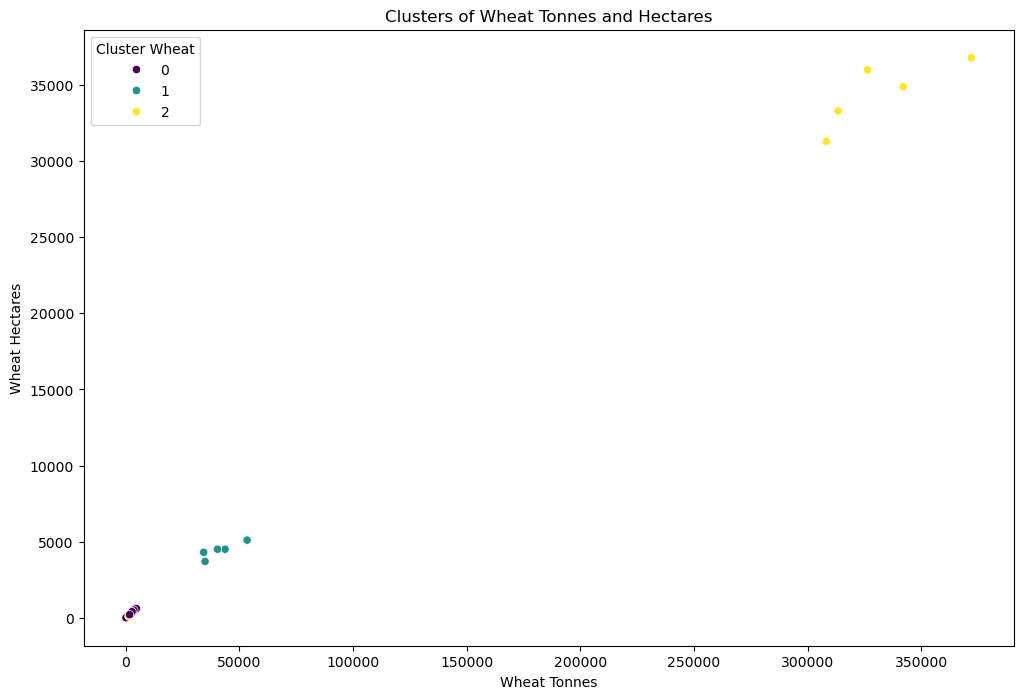

In [ ]:
data_w['Cluster Wheat'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=data_w['Wheat Tonnes'], y=data_w['Wheat Hectares'], hue=data_w['Cluster Wheat'], palette='viridis')
plt.title('Clusters of Wheat Tonnes and Hectares')
plt.show()

C:\Users\dress\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dress\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dress\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dress\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

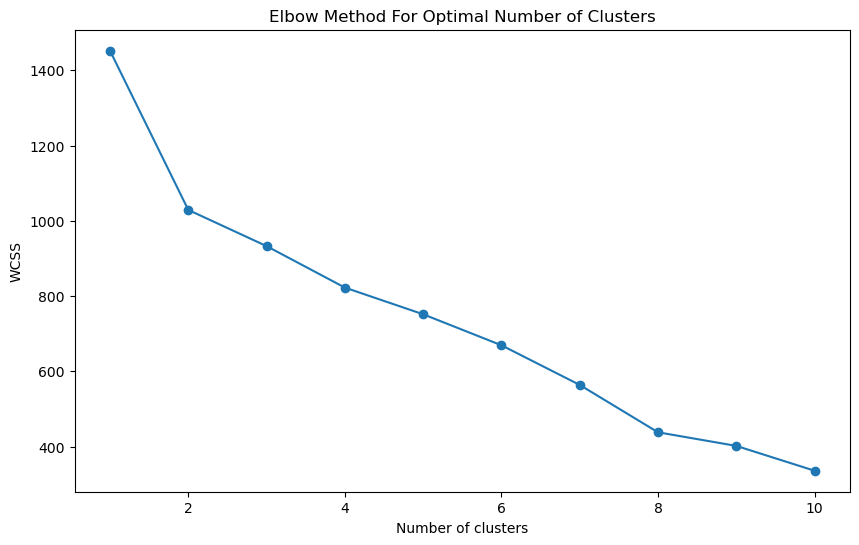

In [ ]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans

wcss = [] #Within-Cluster Sum of Square to check the compactness of the clusters formed to find best cluster
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

From the plot it is evident that 3 is the number of clusters most suitable for the data which may not overfit or underfit the dataset

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = data_w.drop(columns=['Wheat Tonnes'])
y = data_w['Wheat Tonnes']

# Split the data into training and testing sets
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)

# Train the model
rf_model.fit(X_train_w, y_train_w)

# Make predictions
y_pred_train = rf_model.predict(X_train_w)
y_pred_test_w = rf_model.predict(X_test_w)

# Evaluate the model
train_r2 = r2_score(y_train_w, y_pred_train)
test_r2 = r2_score(y_test_w, y_pred_test_w)

print(f'Training R2: {train_r2}')
print(f'Testing R2: {test_r2}')

Training R2: 0.9362327116255001
Testing R2: 0.3042794483296444


The random forest gave an accuracy of only 30.4% on testing data after it was rerun after clustering was done although it gave an accuracy of 93.6%on training data. We can see that the algorithm did not perform after it was applied after clustering was performed

### Clustering Data for Barley

C:\Users\dress\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


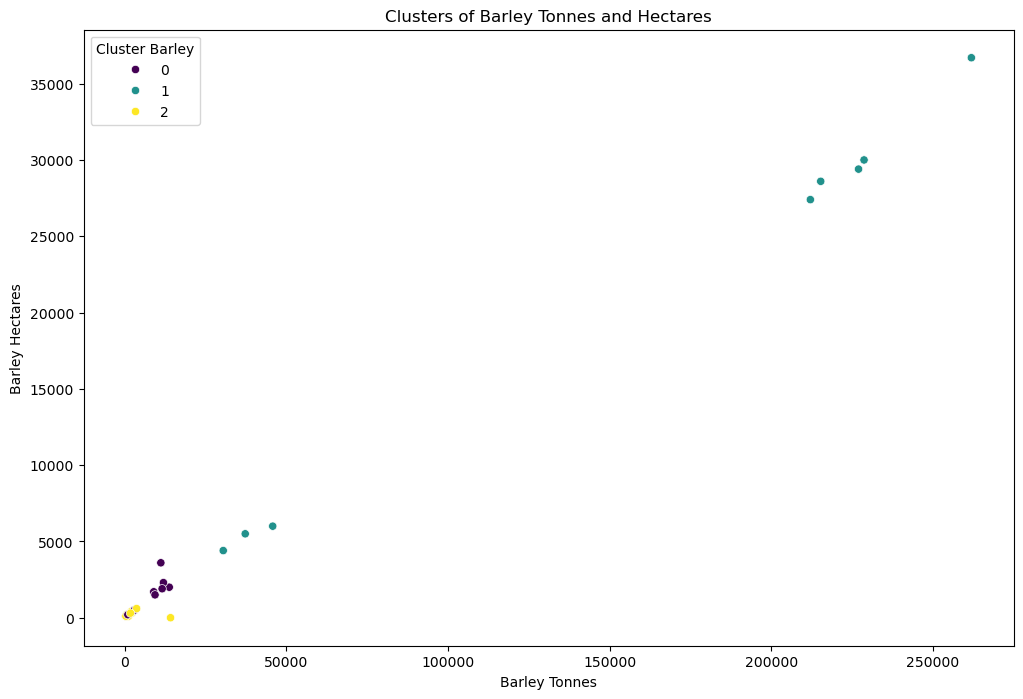

In [ ]:
columns = [
'Barley Tonnes',
 'Barley Hectares',
 'September Total Rainfall (mm)',
 'October Total Rainfall (mm)',
 'November Total Rainfall (mm)',
 'December Total Rainfall (mm)',
 'January Total Rainfall (mm)',
 'February Total Rainfall (mm)',
 'March Total Rainfall (mm)',
 'April Total Rainfall (mm)',
 'May Total Rainfall (mm)',
 'June Total Rainfall (mm)',
 'July Total Rainfall (mm)',
 'August Total Rainfall (mm)',
 'September Wet Day - 1mm or more of Rain (day)',
 'October Wet Day - 1mm or more of Rain (day)',
 'November Wet Day - 1mm or more of Rain (day)',
 'December Wet Day - 1mm or more of Rain (day)',
 'January Wet Day - 1mm or more of Rain (day)',
 'February Wet Day - 1mm or more of Rain (day)',
 'March Wet Day - 1mm or more of Rain (day)',
 'April Wet Day - 1mm or more of Rain (day)',
 'May Wet Day - 1mm or more of Rain (day)',
 'June Wet Day - 1mm or more of Rain (day)',
 'July Wet Day - 1mm or more of Rain (day)',
 'August Wet Day - 1mm or more of Rain (day)',
 'September Mean Air Temperature (Celsius)',
 'October Mean Air Temperature (Celsius)',
 'November Mean Air Temperature (Celsius)',
 'December Mean Air Temperature (Celsius)',
 'January Mean Air Temperature (Celsius)',
 'February Mean Air Temperature (Celsius)',
 'March Mean Air Temperature (Celsius)',
 'April Mean Air Temperature (Celsius)',
 'May Mean Air Temperature (Celsius)',
 'June Mean Air Temperature (Celsius)',
 'July Mean Air Temperature (Celsius)',
 'August Mean Air Temperature (Celsius)',
 'September Total Sunshine (hrs)',
 'October Total Sunshine (hrs)',
 'November Total Sunshine (hrs)',
 'December Total Sunshine (hrs)',
 'January Total Sunshine (hrs)',
 'February Total Sunshine (hrs)',
 'March Total Sunshine (hrs)',
 'April Total Sunshine (hrs)',
 'May Total Sunshine (hrs)',
 'June Total Sunshine (hrs)',
 'July Total Sunshine (hrs)',
 'August Total Sunshine (hrs)',
 'September Mean Wind Speed (M/Sec)',
 'October Mean Wind Speed (M/Sec)',
 'November Mean Wind Speed (M/Sec)',
 'December Mean Wind Speed (M/Sec)',
 'January Mean Wind Speed (M/Sec)',
 'February Mean Wind Speed (M/Sec)',
 'March Mean Wind Speed (M/Sec)',
 'April Mean Wind Speed (M/Sec)',
 'May Mean Wind Speed (M/Sec)',
 'June Mean Wind Speed (M/Sec)',
 'July Mean Wind Speed (M/Sec)',
 'August Mean Wind Speed (M/Sec)',
 'AMN_value',
 'Bulk_density_value',
 'TotalC_value',
 'TotalN_value'
]

data_b = crop_wether_soils_fertiliser_df[columns]
data_b = data_b.loc[data_b['Barley Tonnes'] != 0]
data_b

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_b)

# Apply K-Means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(scaled_data)

data_b['Cluster Barley'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=data_b['Barley Tonnes'], y=data_b['Barley Hectares'], hue=data_b['Cluster Barley'], palette='viridis')
plt.title('Clusters of Barley Tonnes and Hectares')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = data_b.drop(columns=['Barley Tonnes'])
y = data_b['Barley Tonnes']

# Split the data into training and testing sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42,n_estimators=100)

# Train the model
rf_model.fit(X_train_b, y_train_b)

# Make predictions
y_pred_train_b = rf_model.predict(X_train_b)
y_pred_test_b = rf_model.predict(X_test_b)

# Evaluate the model
train_r2 = r2_score(y_train_b, y_pred_train_b)
test_r2 = r2_score(y_test_b, y_pred_test_b)

print(f'Training R2: {train_r2}')
print(f'Testing R2: {test_r2}')

Training R2: 0.9754898569021322
Testing R2: 0.9852481829775469


The random forest gave an accuracy of 98.5% on testing data after it was rerun after clustering was done

### Clustering Data for Maize

C:\Users\dress\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


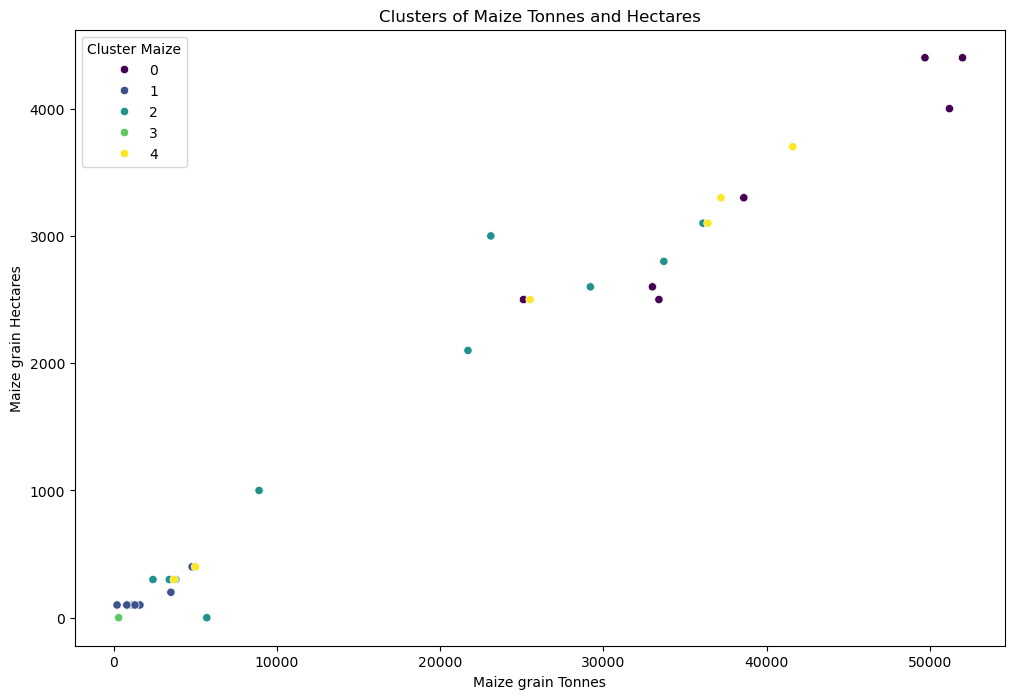

In [ ]:
columns = [
    'Maize grain Tonnes', 'Maize grain Hectares',
 'September Total Rainfall (mm)',
 'October Total Rainfall (mm)',
 'November Total Rainfall (mm)',
 'December Total Rainfall (mm)',
 'January Total Rainfall (mm)',
 'February Total Rainfall (mm)',
 'March Total Rainfall (mm)',
 'April Total Rainfall (mm)',
 'May Total Rainfall (mm)',
 'June Total Rainfall (mm)',
 'July Total Rainfall (mm)',
 'August Total Rainfall (mm)',
 'September Wet Day - 1mm or more of Rain (day)',
 'October Wet Day - 1mm or more of Rain (day)',
 'November Wet Day - 1mm or more of Rain (day)',
 'December Wet Day - 1mm or more of Rain (day)',
 'January Wet Day - 1mm or more of Rain (day)',
 'February Wet Day - 1mm or more of Rain (day)',
 'March Wet Day - 1mm or more of Rain (day)',
 'April Wet Day - 1mm or more of Rain (day)',
 'May Wet Day - 1mm or more of Rain (day)',
 'June Wet Day - 1mm or more of Rain (day)',
 'July Wet Day - 1mm or more of Rain (day)',
 'August Wet Day - 1mm or more of Rain (day)',
 'September Mean Air Temperature (Celsius)',
 'October Mean Air Temperature (Celsius)',
 'November Mean Air Temperature (Celsius)',
 'December Mean Air Temperature (Celsius)',
 'January Mean Air Temperature (Celsius)',
 'February Mean Air Temperature (Celsius)',
 'March Mean Air Temperature (Celsius)',
 'April Mean Air Temperature (Celsius)',
 'May Mean Air Temperature (Celsius)',
 'June Mean Air Temperature (Celsius)',
 'July Mean Air Temperature (Celsius)',
 'August Mean Air Temperature (Celsius)',
 'September Total Sunshine (hrs)',
 'October Total Sunshine (hrs)',
 'November Total Sunshine (hrs)',
 'December Total Sunshine (hrs)',
 'January Total Sunshine (hrs)',
 'February Total Sunshine (hrs)',
 'March Total Sunshine (hrs)',
 'April Total Sunshine (hrs)',
 'May Total Sunshine (hrs)',
 'June Total Sunshine (hrs)',
 'July Total Sunshine (hrs)',
 'August Total Sunshine (hrs)',
 'September Mean Wind Speed (M/Sec)',
 'October Mean Wind Speed (M/Sec)',
 'November Mean Wind Speed (M/Sec)',
 'December Mean Wind Speed (M/Sec)',
 'January Mean Wind Speed (M/Sec)',
 'February Mean Wind Speed (M/Sec)',
 'March Mean Wind Speed (M/Sec)',
 'April Mean Wind Speed (M/Sec)',
 'May Mean Wind Speed (M/Sec)',
 'June Mean Wind Speed (M/Sec)',
 'July Mean Wind Speed (M/Sec)',
 'August Mean Wind Speed (M/Sec)',
 'AMN_value',
 'Bulk_density_value',
 'TotalC_value',
 'TotalN_value']

data_m = crop_wether_soils_fertiliser_df[columns]
data_m = data_m.loc[data_m['Maize grain Tonnes'] != 0]
data_m

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_m)

# Apply K-Means clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(scaled_data)

data_m['Cluster Maize'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=data_m['Maize grain Tonnes'], y=data_m['Maize grain Hectares'], hue=data_m['Cluster Maize'], palette='viridis')
plt.title('Clusters of Maize Tonnes and Hectares')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = data_m.drop(columns=['Maize grain Tonnes'])
y = data_m['Maize grain Tonnes']

# Split the data into training and testing sets
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train_m, y_train_m)

# Make predictions
y_pred_train_m = rf_model.predict(X_train_m)
y_pred_test_m = rf_model.predict(X_test_m)

# Evaluate the model
train_r2 = r2_score(y_train_m, y_pred_train_m)
test_r2 = r2_score(y_test_m, y_pred_test_m)

print(f'Training R2: {train_r2}')
print(f'Testing R2: {test_r2}')

Training R2: 0.9771830098616645
Testing R2: 0.9499238659636564


The random forest gave an accuracy of 94.9% on testing data after it was rerun after clustering was done

### Conclusion

The project aims to identify the most effective model for predicting crop yield in New Zealand based on factors such as weather patterns, soil characteristics, and agricultural practices. It focuses on three main crops: wheat, barley, and maize, using data collected from 2019 to 2023 across all regions of New Zealand.

Weather data includes total rainfall, number of wet days, mean air temperature, total sunshine hours, and mean wind speed. Agricultural practices considered involve fertilizer application in each region. Soil characteristics encompass land use, soil types, and various soil nutrient levels.

Initially, data is consolidated from multiple sources into a single dataset for easier analysis. Visualization techniques are then applied to reveal key patterns in the data, analysis includes visualizing changes in total crop yield over the five-year period, analyzing regional crop yield patterns, and examining fertilizer application trends.

The second part of the project involves applying various machine learning techniques, including regression, classification, and clustering models, to predict crop yields.

Out of the regression models, the best ones for predicting Wheat and Maize yields are the ones that use soil characteristics and their interactions. The same is true for Barley however that model was a lot weaker than the other two.

For classification, the crop yield is categorized into ranges, and random forest, decision tree, and Gaussian Naive Bayes classifiers are applied to predict these categories. Analysis reveals that for wheat yield prediction the Gaussian Naive Bayes classifier  and  Random forest classifier have the highest accuracy, for the prediction of barley yield the Gaussian Naive Bayes classifier has the best result and for maize grain prediction the  Random forest classifier get the best prediction.

Clustering was applied in a attempt to further enrich the dataset for better prediction. The random forest was applied again after succesfull clustering which provided better results.

In conclusion, the project successfully identifies the most effective models for predicting crop yield in New Zealand and provides insights into regional crop yield variations and agricultural practices.